In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        for i in range(linear_layers - 2):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
        self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
        self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex_pre_act = nn.CELU()
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(self.convex_pre_act(linear))
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        #if not x.requires_grad:
        #    x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [3]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, X, Y):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2] + E_Q[||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        # Forward: omega -> theta
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y).detach()
        cycle_loss_y = torch.mean(diff ** 2)

        # Same for X
        grad_psi_theta_x = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega_x = self.psi_omega.gradient(self.to_omega(grad_psi_theta_x))

        diff_x = grad_psi_omega_x - self.to_omega(X).detach()
        
        cycle_loss_x = torch.mean(diff_x ** 2)
        cycle_loss = cycle_loss_y + self.to_theta(cycle_loss_x)
        
        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg # OMEGA

    def compute_reg(self):
        """
        Compute regularization of model params
        """
        reg_total = 0.0
        for p in self.psi_theta.parameters():
            reg_total += torch.sum(torch.abs(p))
        for p in self.psi_omega.parameters():
            reg_total += self.to_theta(torch.sum(torch.abs(p)))
        return reg_total

    def compute_loss(self, opt, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            opt: optimizer
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        X.requires_grad_(True)
        Y.requires_grad_(True)
        opt[0].zero_grad()
        opt[1].zero_grad()

        # Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(X, Y)

        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_omega_d = grad_psi_omega.detach() # heuristic from Appendix C.1

        opt[0].zero_grad()
        opt[1].zero_grad()
        
        # Compute neg W dist & correlations
        loss_W = torch.mean(self.psi_theta(self.to_theta(X)) - self.psi_theta(self.to_theta(grad_psi_omega_d)))
        #with torch.no_grad():
        #    loss_W_const = (- (self.to_omega(X) ** 2).sum(dim=(1, 2, 3)) / 2).mean() + \
        #    ((grad_psi_omega_d * self.to_omega(Y)).sum(dim=(1, 2, 3)) - (self.to_omega(Y) ** 2).sum(dim=(1, 2, 3)) / 2).mean()
        #loss_corr = self.compute_correlations(X, Y, grad_psi_omega_d)

        # Total loss
        if self.compute_extra_reg:
            loss_R = 1e-10 * self.compute_reg() #self.to_theta(self.compute_extra_R(X))
            loss_R_item = loss_R.item()
            #loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_R_item = None
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle

        # Gradient step
        loss_total.backward()
        opt[0].step()
        opt[1].step()
        opt[0].zero_grad()
        opt[1].zero_grad()

        return {
            'loss_corr': loss_W.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def pretrain_loss(self, X):
        X.requires_grad_(True)
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        loss_mse = F.mse_loss(grad_psi_theta, X)
        loss_mse.backward()

        return loss_mse

    def apply_pretrain_weights(self):
        self.psi_omega.load_state_dict(self.psi_theta.state_dict())

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [4]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3, pre_lr=1e-3, betas_theta=(0.8, 0.99), betas_omega=(0.4, 0.4)):
        self.loss_c = loss_c
        self.optimizers = [
            torch.optim.Adam(
                list(self.loss_c.psi_theta.parameters()),
                lr=lr, betas=betas_theta
            ),
            torch.optim.Adam(
                list(self.loss_c.psi_omega.parameters()),
                lr=lr, betas=betas_omega
        )]

        self.preoptimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()),
           lr=pre_lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}
        self.history_pre = []

    def step(self, X, Y):
        #self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(self.optimizers, X, Y)
        #self.optimizer.step()
        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def pretrain_step(self, X):
        self.preoptimizer.zero_grad()
        loss = self.loss_c.pretrain_loss(X)
        self.preoptimizer.step()
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()

        self.history_pre.append(loss)

        return loss

    def apply_pretrain(self):
        self.loss_c.apply_pretrain_weights()
        del self.preoptimizer

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

In [6]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val

        self.trainA = "trainA"
        self.testA = "testA"
        self.trainB = "trainB"
        self.testB = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.imagesA = os.listdir(os.path.join(root, self.trainA))
            self.imagesB = os.listdir(os.path.join(root, self.trainB))
        else:
            self.imagesA = os.listdir(os.path.join(root, self.testA))
            self.imagesB = os.listdir(os.path.join(root, self.testB))

        self.transforms_A = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.CenterCrop(200),
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(0.025, 0.025, 0.025, 0.025),
            #transforms.ToTensor(),
            #transforms.Lambda(lambda x: x+torch.randn_like(x) * 0.01),
            #transforms.Lambda(lambda t: t.clamp(0,1)),
        ])
        self.transforms_B = self.transforms_A

        self.pics = min(len(self.imagesA), len(self.imagesB))

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dirA, pic_dirB):
        img_pathA = os.path.join(self.root, pic_dirA, self.imagesA[idx])
        img_pathB = os.path.join(self.root, pic_dirB, self.imagesB[idx])

        # Load the image
        imgA = self.transforms_A(Image.open(img_pathA))#.resize((self.target_shape, self.target_shape))
        imgB = self.transforms_B(Image.open(img_pathB))#.resize((self.target_shape, self.target_shape))

        #return torch.stack([self.transforms_A(imgA), self.transforms_B(imgB)])#.permute(0, 3, 1, 2)

        out = torch.as_tensor(np.stack([
            np.asarray(imgA, dtype=np.float32), np.asarray(imgB, dtype=np.float32)
        ]) / 128.0 - 1.0).permute(0, 3, 1, 2)

        #out = out + torch.randn_like(out) * 0.01
        #out = out.clamp(0, 1)
        return out, {}

    @staticmethod
    def take(t, A: bool):
        if A:
            return t[:, 0]
        else:
            return t[:, 1]

    @staticmethod
    def to_image(t):
        t = t.clamp(-1, 1)
        return (t.permute(0, 2, 3, 1) + 1.0) * 128.0

    def get_train(self, idx):
        return self.get(idx, self.trainA, self.trainB)

    def get_val(self, idx):
        return self.get(idx, self.testA, self.testB)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [7]:
batch_size = 8
dataset = S2WDataset(path, 128)

datasetVal = S2WDataset(path, 128, is_val=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [8]:
psi_theta = ConvICNN()
psi_omega = ConvICNN()

In [9]:
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=35000.0, compute_extra_reg=True, devices=["cuda:0"])
trainer = W2GNTrainer(loss_c, lr=1e-4, pre_lr=1e-4)

In [69]:
# Pretrain
epochs = 5
for epoch in range(epochs):
    A_iter = iter(dataloader)
    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_src = next(A_iter)[0]
        X = dataloader.dataset.take(X_src, A=True)
        loss = trainer.pretrain_step(X.to(trainer.loss_c.theta_device()))
        print(f"Epoch {epoch}: MSE={loss:.4f}")

Epoch 1/5:   1%|▎                                    | 1/121 [00:00<00:44,  2.70it/s]

Epoch 0: MSE=0.3734


Epoch 1/5:   2%|▌                                    | 2/121 [00:00<00:40,  2.94it/s]

Epoch 0: MSE=1.1808


Epoch 1/5:   2%|▉                                    | 3/121 [00:01<00:38,  3.06it/s]

Epoch 0: MSE=1.9646


Epoch 1/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.13it/s]

Epoch 0: MSE=1.0787


Epoch 1/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.18it/s]

Epoch 0: MSE=0.7676


Epoch 1/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.17it/s]

Epoch 0: MSE=0.5648


Epoch 1/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.15it/s]

Epoch 0: MSE=0.7033


Epoch 1/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.17it/s]

Epoch 0: MSE=0.7694


Epoch 1/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.16it/s]

Epoch 0: MSE=0.6783


Epoch 1/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.16it/s]

Epoch 0: MSE=0.5462


Epoch 1/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.15it/s]

Epoch 0: MSE=0.3734


Epoch 1/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.14it/s]

Epoch 0: MSE=0.3294


Epoch 1/5:  11%|███▊                                | 13/121 [00:04<00:34,  3.17it/s]

Epoch 0: MSE=0.2970


Epoch 1/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.17it/s]

Epoch 0: MSE=0.2775


Epoch 1/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.19it/s]

Epoch 0: MSE=0.3125


Epoch 1/5:  13%|████▊                               | 16/121 [00:05<00:33,  3.17it/s]

Epoch 0: MSE=0.3173


Epoch 1/5:  14%|█████                               | 17/121 [00:05<00:32,  3.17it/s]

Epoch 0: MSE=0.2931


Epoch 1/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.17it/s]

Epoch 0: MSE=0.2325


Epoch 1/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.19it/s]

Epoch 0: MSE=0.2148


Epoch 1/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.16it/s]

Epoch 0: MSE=0.1711


Epoch 1/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.14it/s]

Epoch 0: MSE=0.2227


Epoch 1/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.16it/s]

Epoch 0: MSE=0.2112


Epoch 1/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.18it/s]

Epoch 0: MSE=0.1981


Epoch 1/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.20it/s]

Epoch 0: MSE=0.1743


Epoch 1/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.17it/s]

Epoch 0: MSE=0.1482


Epoch 1/5:  21%|███████▋                            | 26/121 [00:08<00:30,  3.15it/s]

Epoch 0: MSE=0.1410


Epoch 1/5:  22%|████████                            | 27/121 [00:08<00:29,  3.15it/s]

Epoch 0: MSE=0.1203


Epoch 1/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.15it/s]

Epoch 0: MSE=0.1102


Epoch 1/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.16it/s]

Epoch 0: MSE=0.0889


Epoch 1/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.14it/s]

Epoch 0: MSE=0.1091


Epoch 1/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.14it/s]

Epoch 0: MSE=0.0842


Epoch 1/5:  26%|█████████▌                          | 32/121 [00:10<00:28,  3.17it/s]

Epoch 0: MSE=0.1040


Epoch 1/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.16it/s]

Epoch 0: MSE=0.1081


Epoch 1/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.16it/s]

Epoch 0: MSE=0.0684


Epoch 1/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.14it/s]

Epoch 0: MSE=0.0765


Epoch 1/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.15it/s]

Epoch 0: MSE=0.0935


Epoch 1/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.18it/s]

Epoch 0: MSE=0.0643


Epoch 1/5:  31%|███████████▎                        | 38/121 [00:12<00:26,  3.19it/s]

Epoch 0: MSE=0.0845


Epoch 1/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.19it/s]

Epoch 0: MSE=0.0762


Epoch 1/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.16it/s]

Epoch 0: MSE=0.0657


Epoch 1/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.18it/s]

Epoch 0: MSE=0.0747


Epoch 1/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.19it/s]

Epoch 0: MSE=0.0688


Epoch 1/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.21it/s]

Epoch 0: MSE=0.0690


Epoch 1/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.19it/s]

Epoch 0: MSE=0.0577


Epoch 1/5:  37%|█████████████▍                      | 45/121 [00:14<00:24,  3.16it/s]

Epoch 0: MSE=0.0576


Epoch 1/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.18it/s]

Epoch 0: MSE=0.0622


Epoch 1/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.20it/s]

Epoch 0: MSE=0.0749


Epoch 1/5:  40%|██████████████▎                     | 48/121 [00:15<00:22,  3.21it/s]

Epoch 0: MSE=0.0552


Epoch 1/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 0: MSE=0.0688


Epoch 1/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.17it/s]

Epoch 0: MSE=0.0644


Epoch 1/5:  42%|███████████████▏                    | 51/121 [00:16<00:22,  3.17it/s]

Epoch 0: MSE=0.0543


Epoch 1/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 0: MSE=0.0650


Epoch 1/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.16it/s]

Epoch 0: MSE=0.0617


Epoch 1/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.14it/s]

Epoch 0: MSE=0.0655


Epoch 1/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.15it/s]

Epoch 0: MSE=0.0559


Epoch 1/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.15it/s]

Epoch 0: MSE=0.0691


Epoch 1/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.17it/s]

Epoch 0: MSE=0.0588


Epoch 1/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.16it/s]

Epoch 0: MSE=0.0524


Epoch 1/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.14it/s]

Epoch 0: MSE=0.0398


Epoch 1/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.16it/s]

Epoch 0: MSE=0.0580


Epoch 1/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.16it/s]

Epoch 0: MSE=0.0621


Epoch 1/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.16it/s]

Epoch 0: MSE=0.0494


Epoch 1/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.15it/s]

Epoch 0: MSE=0.0544


Epoch 1/5:  53%|███████████████████                 | 64/121 [00:20<00:18,  3.13it/s]

Epoch 0: MSE=0.0518


Epoch 1/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.13it/s]

Epoch 0: MSE=0.0532


Epoch 1/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.15it/s]

Epoch 0: MSE=0.0610


Epoch 1/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.17it/s]

Epoch 0: MSE=0.0583


Epoch 1/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.15it/s]

Epoch 0: MSE=0.0478


Epoch 1/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.14it/s]

Epoch 0: MSE=0.0548


Epoch 1/5:  58%|████████████████████▊               | 70/121 [00:22<00:16,  3.17it/s]

Epoch 0: MSE=0.0589


Epoch 1/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.19it/s]

Epoch 0: MSE=0.0480


Epoch 1/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.19it/s]

Epoch 0: MSE=0.0662


Epoch 1/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.16it/s]

Epoch 0: MSE=0.0476


Epoch 1/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.17it/s]

Epoch 0: MSE=0.0552


Epoch 1/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.19it/s]

Epoch 0: MSE=0.0495


Epoch 1/5:  63%|██████████████████████▌             | 76/121 [00:24<00:14,  3.21it/s]

Epoch 0: MSE=0.0600


Epoch 1/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.21it/s]

Epoch 0: MSE=0.0439


Epoch 1/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.18it/s]

Epoch 0: MSE=0.0456


Epoch 1/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.19it/s]

Epoch 0: MSE=0.0546


Epoch 1/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.21it/s]

Epoch 0: MSE=0.0638


Epoch 1/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.22it/s]

Epoch 0: MSE=0.0586


Epoch 1/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.21it/s]

Epoch 0: MSE=0.0612


Epoch 1/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.18it/s]

Epoch 0: MSE=0.0527


Epoch 1/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.20it/s]

Epoch 0: MSE=0.0499


Epoch 1/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.22it/s]

Epoch 0: MSE=0.0513


Epoch 1/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:10,  3.22it/s]

Epoch 0: MSE=0.0587


Epoch 1/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.20it/s]

Epoch 0: MSE=0.0434


Epoch 1/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.18it/s]

Epoch 0: MSE=0.0471


Epoch 1/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:09,  3.20it/s]

Epoch 0: MSE=0.0436


Epoch 1/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.22it/s]

Epoch 0: MSE=0.0458


Epoch 1/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.23it/s]

Epoch 0: MSE=0.0484


Epoch 1/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.19it/s]

Epoch 0: MSE=0.0474


Epoch 1/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.18it/s]

Epoch 0: MSE=0.0431


Epoch 1/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.21it/s]

Epoch 0: MSE=0.0498


Epoch 1/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.22it/s]

Epoch 0: MSE=0.0512


Epoch 1/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.22it/s]

Epoch 0: MSE=0.0395


Epoch 1/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.19it/s]

Epoch 0: MSE=0.0469


Epoch 1/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.19it/s]

Epoch 0: MSE=0.0513


Epoch 1/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.21it/s]

Epoch 0: MSE=0.0491


Epoch 1/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.22it/s]

Epoch 0: MSE=0.0402


Epoch 1/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.22it/s]

Epoch 0: MSE=0.0431


Epoch 1/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.19it/s]

Epoch 0: MSE=0.0531


Epoch 1/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.20it/s]

Epoch 0: MSE=0.0411


Epoch 1/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.21it/s]

Epoch 0: MSE=0.0457


Epoch 1/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:04,  3.22it/s]

Epoch 0: MSE=0.0424


Epoch 1/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.21it/s]

Epoch 0: MSE=0.0590


Epoch 1/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.18it/s]

Epoch 0: MSE=0.0448


Epoch 1/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.20it/s]

Epoch 0: MSE=0.0500


Epoch 1/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.21it/s]

Epoch 0: MSE=0.0379


Epoch 1/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.23it/s]

Epoch 0: MSE=0.0457


Epoch 1/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.20it/s]

Epoch 0: MSE=0.0529


Epoch 1/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.18it/s]

Epoch 0: MSE=0.0447


Epoch 1/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.20it/s]

Epoch 0: MSE=0.0482


Epoch 1/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.22it/s]

Epoch 0: MSE=0.0490


Epoch 1/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.23it/s]

Epoch 0: MSE=0.0364


Epoch 1/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.20it/s]

Epoch 0: MSE=0.0375


Epoch 1/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.18it/s]

Epoch 0: MSE=0.0449


Epoch 1/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.20it/s]

Epoch 0: MSE=0.0453


Epoch 1/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.22it/s]

Epoch 0: MSE=0.0332


Epoch 0: MSE=0.0576
Epoch 0: MSE=0.0491


Epoch 2/5:   1%|▎                                    | 1/121 [00:00<00:39,  3.00it/s]

Epoch 1: MSE=0.0377


Epoch 2/5:   2%|▌                                    | 2/121 [00:00<00:37,  3.14it/s]

Epoch 1: MSE=0.0423


Epoch 2/5:   2%|▉                                    | 3/121 [00:00<00:36,  3.19it/s]

Epoch 1: MSE=0.0476


Epoch 2/5:   3%|█▏                                   | 4/121 [00:01<00:36,  3.21it/s]

Epoch 1: MSE=0.0423


Epoch 2/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.18it/s]

Epoch 1: MSE=0.0380


Epoch 2/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.17it/s]

Epoch 1: MSE=0.0421


Epoch 2/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.20it/s]

Epoch 1: MSE=0.0467


Epoch 2/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.21it/s]

Epoch 1: MSE=0.0496


Epoch 2/5:   7%|██▊                                  | 9/121 [00:02<00:34,  3.21it/s]

Epoch 1: MSE=0.0426


Epoch 2/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.18it/s]

Epoch 1: MSE=0.0512


Epoch 2/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.18it/s]

Epoch 1: MSE=0.0408


Epoch 2/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.20it/s]

Epoch 1: MSE=0.0374


Epoch 2/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.21it/s]

Epoch 1: MSE=0.0393


Epoch 2/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.21it/s]

Epoch 1: MSE=0.0380


Epoch 2/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.18it/s]

Epoch 1: MSE=0.0358


Epoch 2/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.19it/s]

Epoch 1: MSE=0.0340


Epoch 2/5:  14%|█████                               | 17/121 [00:05<00:32,  3.21it/s]

Epoch 1: MSE=0.0369


Epoch 2/5:  15%|█████▎                              | 18/121 [00:05<00:31,  3.22it/s]

Epoch 1: MSE=0.0320


Epoch 2/5:  16%|█████▋                              | 19/121 [00:05<00:31,  3.21it/s]

Epoch 1: MSE=0.0397


Epoch 2/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.18it/s]

Epoch 1: MSE=0.0471


Epoch 2/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.17it/s]

Epoch 1: MSE=0.0473


Epoch 2/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.15it/s]

Epoch 1: MSE=0.0429


Epoch 2/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.18it/s]

Epoch 1: MSE=0.0401


Epoch 2/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 1: MSE=0.0357


Epoch 2/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.15it/s]

Epoch 1: MSE=0.0395


Epoch 2/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.18it/s]

Epoch 1: MSE=0.0368


Epoch 2/5:  22%|████████                            | 27/121 [00:08<00:29,  3.16it/s]

Epoch 1: MSE=0.0340


Epoch 2/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.16it/s]

Epoch 1: MSE=0.0465


Epoch 2/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.14it/s]

Epoch 1: MSE=0.0384


Epoch 2/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.15it/s]

Epoch 1: MSE=0.0390


Epoch 2/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.17it/s]

Epoch 1: MSE=0.0386


Epoch 2/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.18it/s]

Epoch 1: MSE=0.0430


Epoch 2/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.17it/s]

Epoch 1: MSE=0.0426


Epoch 2/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.16it/s]

Epoch 1: MSE=0.0348


Epoch 2/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.17it/s]

Epoch 1: MSE=0.0342


Epoch 2/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.19it/s]

Epoch 1: MSE=0.0373


Epoch 2/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.21it/s]

Epoch 1: MSE=0.0370


Epoch 2/5:  31%|███████████▎                        | 38/121 [00:11<00:25,  3.20it/s]

Epoch 1: MSE=0.0453


Epoch 2/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 1: MSE=0.0518


Epoch 2/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.19it/s]

Epoch 1: MSE=0.0324


Epoch 2/5:  34%|████████████▏                       | 41/121 [00:12<00:24,  3.21it/s]

Epoch 1: MSE=0.0325


Epoch 2/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.22it/s]

Epoch 1: MSE=0.0386


Epoch 2/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.20it/s]

Epoch 1: MSE=0.0332


Epoch 2/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.18it/s]

Epoch 1: MSE=0.0418


Epoch 2/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.20it/s]

Epoch 1: MSE=0.0451


Epoch 2/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.21it/s]

Epoch 1: MSE=0.0292


Epoch 2/5:  39%|█████████████▉                      | 47/121 [00:14<00:22,  3.22it/s]

Epoch 1: MSE=0.0383


Epoch 2/5:  40%|██████████████▎                     | 48/121 [00:15<00:22,  3.19it/s]

Epoch 1: MSE=0.0334


Epoch 2/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 1: MSE=0.0375


Epoch 2/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.20it/s]

Epoch 1: MSE=0.0337


Epoch 2/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.22it/s]

Epoch 1: MSE=0.0427


Epoch 2/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.22it/s]

Epoch 1: MSE=0.0392


Epoch 2/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.19it/s]

Epoch 1: MSE=0.0324


Epoch 2/5:  45%|████████████████                    | 54/121 [00:16<00:21,  3.19it/s]

Epoch 1: MSE=0.0415


Epoch 2/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.20it/s]

Epoch 1: MSE=0.0306


Epoch 2/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.22it/s]

Epoch 1: MSE=0.0304


Epoch 2/5:  47%|████████████████▉                   | 57/121 [00:17<00:19,  3.21it/s]

Epoch 1: MSE=0.0399


Epoch 2/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.18it/s]

Epoch 1: MSE=0.0395


Epoch 2/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.19it/s]

Epoch 1: MSE=0.0318


Epoch 2/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.21it/s]

Epoch 1: MSE=0.0342


Epoch 2/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.21it/s]

Epoch 1: MSE=0.0405


Epoch 2/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.20it/s]

Epoch 1: MSE=0.0376


Epoch 2/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.17it/s]

Epoch 1: MSE=0.0335


Epoch 2/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.19it/s]

Epoch 1: MSE=0.0451


Epoch 2/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.20it/s]

Epoch 1: MSE=0.0435


Epoch 2/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.21it/s]

Epoch 1: MSE=0.0350


Epoch 2/5:  55%|███████████████████▉                | 67/121 [00:21<00:16,  3.18it/s]

Epoch 1: MSE=0.0311


Epoch 2/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.16it/s]

Epoch 1: MSE=0.0465


Epoch 2/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.18it/s]

Epoch 1: MSE=0.0341


Epoch 2/5:  58%|████████████████████▊               | 70/121 [00:21<00:15,  3.20it/s]

Epoch 1: MSE=0.0378


Epoch 2/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.21it/s]

Epoch 1: MSE=0.0320


Epoch 2/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.17it/s]

Epoch 1: MSE=0.0302


Epoch 2/5:  60%|█████████████████████▋              | 73/121 [00:22<00:15,  3.16it/s]

Epoch 1: MSE=0.0436


Epoch 2/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.18it/s]

Epoch 1: MSE=0.0334


Epoch 2/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.20it/s]

Epoch 1: MSE=0.0348


Epoch 2/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.20it/s]

Epoch 1: MSE=0.0303


Epoch 2/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.17it/s]

Epoch 1: MSE=0.0257


Epoch 2/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.17it/s]

Epoch 1: MSE=0.0360


Epoch 2/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.18it/s]

Epoch 1: MSE=0.0290


Epoch 2/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.20it/s]

Epoch 1: MSE=0.0366


Epoch 2/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.19it/s]

Epoch 1: MSE=0.0284


Epoch 2/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.16it/s]

Epoch 1: MSE=0.0450


Epoch 2/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.17it/s]

Epoch 1: MSE=0.0438


Epoch 2/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.19it/s]

Epoch 1: MSE=0.0360


Epoch 2/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.20it/s]

Epoch 1: MSE=0.0343


Epoch 2/5:  71%|█████████████████████████▌          | 86/121 [00:26<00:10,  3.18it/s]

Epoch 1: MSE=0.0442


Epoch 2/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.16it/s]

Epoch 1: MSE=0.0330


Epoch 2/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.18it/s]

Epoch 1: MSE=0.0248


Epoch 2/5:  74%|██████████████████████████▍         | 89/121 [00:27<00:10,  3.20it/s]

Epoch 1: MSE=0.0354


Epoch 2/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.21it/s]

Epoch 1: MSE=0.0286


Epoch 2/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.17it/s]

Epoch 1: MSE=0.0410


Epoch 2/5:  76%|███████████████████████████▎        | 92/121 [00:28<00:09,  3.16it/s]

Epoch 1: MSE=0.0351


Epoch 2/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.18it/s]

Epoch 1: MSE=0.0347


Epoch 2/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.20it/s]

Epoch 1: MSE=0.0311


Epoch 2/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.20it/s]

Epoch 1: MSE=0.0285


Epoch 2/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.17it/s]

Epoch 1: MSE=0.0399


Epoch 2/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.17it/s]

Epoch 1: MSE=0.0291


Epoch 2/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.19it/s]

Epoch 1: MSE=0.0227


Epoch 2/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.20it/s]

Epoch 1: MSE=0.0396


Epoch 2/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.19it/s]

Epoch 1: MSE=0.0293


Epoch 2/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.16it/s]

Epoch 1: MSE=0.0338


Epoch 2/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.17it/s]

Epoch 1: MSE=0.0261


Epoch 2/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.19it/s]

Epoch 1: MSE=0.0284


Epoch 2/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.20it/s]

Epoch 1: MSE=0.0367


Epoch 2/5:  87%|██████████████████████████████▎    | 105/121 [00:32<00:05,  3.19it/s]

Epoch 1: MSE=0.0360


Epoch 2/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.16it/s]

Epoch 1: MSE=0.0315


Epoch 2/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.18it/s]

Epoch 1: MSE=0.0382


Epoch 2/5:  89%|███████████████████████████████▏   | 108/121 [00:33<00:04,  3.19it/s]

Epoch 1: MSE=0.0336


Epoch 2/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.20it/s]

Epoch 1: MSE=0.0340


Epoch 2/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.18it/s]

Epoch 1: MSE=0.0334


Epoch 2/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.16it/s]

Epoch 1: MSE=0.0263


Epoch 2/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.18it/s]

Epoch 1: MSE=0.0351


Epoch 2/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.20it/s]

Epoch 1: MSE=0.0305


Epoch 2/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.21it/s]

Epoch 1: MSE=0.0345


Epoch 2/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.17it/s]

Epoch 1: MSE=0.0431


Epoch 2/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.17it/s]

Epoch 1: MSE=0.0320


Epoch 2/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.18it/s]

Epoch 1: MSE=0.0304


Epoch 2/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.20it/s]

Epoch 1: MSE=0.0302


Epoch 2/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.19it/s]

Epoch 1: MSE=0.0397


Epoch 1: MSE=0.0283
Epoch 1: MSE=0.0339


Epoch 3/5:   1%|▎                                    | 1/121 [00:00<00:39,  3.07it/s]

Epoch 2: MSE=0.0348


Epoch 3/5:   2%|▌                                    | 2/121 [00:00<00:37,  3.16it/s]

Epoch 2: MSE=0.0233


Epoch 3/5:   2%|▉                                    | 3/121 [00:00<00:37,  3.18it/s]

Epoch 2: MSE=0.0297


Epoch 3/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.15it/s]

Epoch 2: MSE=0.0321


Epoch 3/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.16it/s]

Epoch 2: MSE=0.0306


Epoch 3/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.18it/s]

Epoch 2: MSE=0.0314


Epoch 3/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.20it/s]

Epoch 2: MSE=0.0290


Epoch 3/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.19it/s]

Epoch 2: MSE=0.0316


Epoch 3/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.16it/s]

Epoch 2: MSE=0.0302


Epoch 3/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.17it/s]

Epoch 2: MSE=0.0273


Epoch 3/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.19it/s]

Epoch 2: MSE=0.0316


Epoch 3/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.20it/s]

Epoch 2: MSE=0.0356


Epoch 3/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.19it/s]

Epoch 2: MSE=0.0269


Epoch 3/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.16it/s]

Epoch 2: MSE=0.0379


Epoch 3/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.18it/s]

Epoch 2: MSE=0.0409


Epoch 3/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.19it/s]

Epoch 2: MSE=0.0307


Epoch 3/5:  14%|█████                               | 17/121 [00:05<00:32,  3.20it/s]

Epoch 2: MSE=0.0291


Epoch 3/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.17it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  16%|█████▋                              | 19/121 [00:05<00:32,  3.16it/s]

Epoch 2: MSE=0.0283


Epoch 3/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.18it/s]

Epoch 2: MSE=0.0328


Epoch 3/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.19it/s]

Epoch 2: MSE=0.0289


Epoch 3/5:  18%|██████▌                             | 22/121 [00:06<00:30,  3.20it/s]

Epoch 2: MSE=0.0283


Epoch 3/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.17it/s]

Epoch 2: MSE=0.0293


Epoch 3/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 2: MSE=0.0287


Epoch 3/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.18it/s]

Epoch 2: MSE=0.0224


Epoch 3/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.20it/s]

Epoch 2: MSE=0.0306


Epoch 3/5:  22%|████████                            | 27/121 [00:08<00:29,  3.19it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.16it/s]

Epoch 2: MSE=0.0326


Epoch 3/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.17it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.18it/s]

Epoch 2: MSE=0.0279


Epoch 3/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.20it/s]

Epoch 2: MSE=0.0293


Epoch 3/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.18it/s]

Epoch 2: MSE=0.0274


Epoch 3/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.16it/s]

Epoch 2: MSE=0.0276


Epoch 3/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.18it/s]

Epoch 2: MSE=0.0262


Epoch 3/5:  29%|██████████▍                         | 35/121 [00:11<00:26,  3.19it/s]

Epoch 2: MSE=0.0323


Epoch 3/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.20it/s]

Epoch 2: MSE=0.0280


Epoch 3/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.18it/s]

Epoch 2: MSE=0.0332


Epoch 3/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.16it/s]

Epoch 2: MSE=0.0312


Epoch 3/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 2: MSE=0.0264


Epoch 3/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.19it/s]

Epoch 2: MSE=0.0375


Epoch 3/5:  34%|████████████▏                       | 41/121 [00:12<00:24,  3.20it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.17it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.16it/s]

Epoch 2: MSE=0.0399


Epoch 3/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.18it/s]

Epoch 2: MSE=0.0280


Epoch 3/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.19it/s]

Epoch 2: MSE=0.0341


Epoch 3/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.19it/s]

Epoch 2: MSE=0.0291


Epoch 3/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.16it/s]

Epoch 2: MSE=0.0333


Epoch 3/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.16it/s]

Epoch 2: MSE=0.0270


Epoch 3/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 2: MSE=0.0260


Epoch 3/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.19it/s]

Epoch 2: MSE=0.0331


Epoch 3/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.19it/s]

Epoch 2: MSE=0.0227


Epoch 3/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 2: MSE=0.0343


Epoch 3/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.17it/s]

Epoch 2: MSE=0.0254


Epoch 3/5:  45%|████████████████                    | 54/121 [00:16<00:21,  3.19it/s]

Epoch 2: MSE=0.0241


Epoch 3/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.20it/s]

Epoch 2: MSE=0.0338


Epoch 3/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.18it/s]

Epoch 2: MSE=0.0291


Epoch 3/5:  47%|████████████████▉                   | 57/121 [00:17<00:20,  3.15it/s]

Epoch 2: MSE=0.0301


Epoch 3/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.18it/s]

Epoch 2: MSE=0.0217


Epoch 3/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.19it/s]

Epoch 2: MSE=0.0267


Epoch 3/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.20it/s]

Epoch 2: MSE=0.0295


Epoch 3/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.17it/s]

Epoch 2: MSE=0.0313


Epoch 3/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.16it/s]

Epoch 2: MSE=0.0323


Epoch 3/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.18it/s]

Epoch 2: MSE=0.0266


Epoch 3/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.20it/s]

Epoch 2: MSE=0.0335


Epoch 3/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.20it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.17it/s]

Epoch 2: MSE=0.0357


Epoch 3/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.17it/s]

Epoch 2: MSE=0.0260


Epoch 3/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.18it/s]

Epoch 2: MSE=0.0282


Epoch 3/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.19it/s]

Epoch 2: MSE=0.0267


Epoch 3/5:  58%|████████████████████▊               | 70/121 [00:22<00:15,  3.19it/s]

Epoch 2: MSE=0.0260


Epoch 3/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.16it/s]

Epoch 2: MSE=0.0295


Epoch 3/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.17it/s]

Epoch 2: MSE=0.0224


Epoch 3/5:  60%|█████████████████████▋              | 73/121 [00:22<00:15,  3.19it/s]

Epoch 2: MSE=0.0271


Epoch 3/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.20it/s]

Epoch 2: MSE=0.0290


Epoch 3/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.18it/s]

Epoch 2: MSE=0.0293


Epoch 3/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.15it/s]

Epoch 2: MSE=0.0310


Epoch 3/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.18it/s]

Epoch 2: MSE=0.0201


Epoch 3/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.19it/s]

Epoch 2: MSE=0.0218


Epoch 3/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.20it/s]

Epoch 2: MSE=0.0249


Epoch 3/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.17it/s]

Epoch 2: MSE=0.0262


Epoch 3/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.15it/s]

Epoch 2: MSE=0.0271


Epoch 3/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.17it/s]

Epoch 2: MSE=0.0304


Epoch 3/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.19it/s]

Epoch 2: MSE=0.0267


Epoch 3/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.20it/s]

Epoch 2: MSE=0.0277


Epoch 3/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.16it/s]

Epoch 2: MSE=0.0242


Epoch 3/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.16it/s]

Epoch 2: MSE=0.0220


Epoch 3/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.18it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.19it/s]

Epoch 2: MSE=0.0328


Epoch 3/5:  74%|██████████████████████████▍         | 89/121 [00:27<00:10,  3.19it/s]

Epoch 2: MSE=0.0265


Epoch 3/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.16it/s]

Epoch 2: MSE=0.0307


Epoch 3/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.17it/s]

Epoch 2: MSE=0.0257


Epoch 3/5:  76%|███████████████████████████▎        | 92/121 [00:28<00:09,  3.18it/s]

Epoch 2: MSE=0.0249


Epoch 3/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.20it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.18it/s]

Epoch 2: MSE=0.0239


Epoch 3/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.15it/s]

Epoch 2: MSE=0.0249


Epoch 3/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.17it/s]

Epoch 2: MSE=0.0203


Epoch 3/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.19it/s]

Epoch 2: MSE=0.0217


Epoch 3/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.20it/s]

Epoch 2: MSE=0.0242


Epoch 3/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.18it/s]

Epoch 2: MSE=0.0243


Epoch 3/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.16it/s]

Epoch 2: MSE=0.0210


Epoch 3/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.18it/s]

Epoch 2: MSE=0.0208


Epoch 3/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.19it/s]

Epoch 2: MSE=0.0246


Epoch 3/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.20it/s]

Epoch 2: MSE=0.0274


Epoch 3/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.17it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.16it/s]

Epoch 2: MSE=0.0332


Epoch 3/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.18it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.19it/s]

Epoch 2: MSE=0.0254


Epoch 3/5:  89%|███████████████████████████████▏   | 108/121 [00:33<00:04,  3.19it/s]

Epoch 2: MSE=0.0230


Epoch 3/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.16it/s]

Epoch 2: MSE=0.0232


Epoch 3/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.16it/s]

Epoch 2: MSE=0.0247


Epoch 3/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.18it/s]

Epoch 2: MSE=0.0248


Epoch 3/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.19it/s]

Epoch 2: MSE=0.0271


Epoch 3/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.18it/s]

Epoch 2: MSE=0.0253


Epoch 3/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.15it/s]

Epoch 2: MSE=0.0199


Epoch 3/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.17it/s]

Epoch 2: MSE=0.0255


Epoch 3/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.18it/s]

Epoch 2: MSE=0.0224


Epoch 3/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.20it/s]

Epoch 2: MSE=0.0265


Epoch 3/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.17it/s]

Epoch 2: MSE=0.0208


Epoch 3/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.15it/s]

Epoch 2: MSE=0.0266


Epoch 2: MSE=0.0199
Epoch 2: MSE=0.0227


Epoch 4/5:   1%|▎                                    | 1/121 [00:00<00:39,  3.04it/s]

Epoch 3: MSE=0.0198


Epoch 4/5:   2%|▌                                    | 2/121 [00:00<00:38,  3.10it/s]

Epoch 3: MSE=0.0235


Epoch 4/5:   2%|▉                                    | 3/121 [00:00<00:38,  3.09it/s]

Epoch 3: MSE=0.0213


Epoch 4/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.15it/s]

Epoch 3: MSE=0.0241


Epoch 4/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.17it/s]

Epoch 3: MSE=0.0234


Epoch 4/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.19it/s]

Epoch 3: MSE=0.0278


Epoch 4/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.16it/s]

Epoch 3: MSE=0.0214


Epoch 4/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.15it/s]

Epoch 3: MSE=0.0279


Epoch 4/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.17it/s]

Epoch 3: MSE=0.0257


Epoch 4/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.19it/s]

Epoch 3: MSE=0.0209


Epoch 4/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.20it/s]

Epoch 3: MSE=0.0211


Epoch 4/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.16it/s]

Epoch 3: MSE=0.0244


Epoch 4/5:  11%|███▊                                | 13/121 [00:04<00:34,  3.16it/s]

Epoch 3: MSE=0.0228


Epoch 4/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.17it/s]

Epoch 3: MSE=0.0225


Epoch 4/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.19it/s]

Epoch 3: MSE=0.0195


Epoch 4/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.18it/s]

Epoch 3: MSE=0.0253


Epoch 4/5:  14%|█████                               | 17/121 [00:05<00:32,  3.15it/s]

Epoch 3: MSE=0.0215


Epoch 4/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.16it/s]

Epoch 3: MSE=0.0248


Epoch 4/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.18it/s]

Epoch 3: MSE=0.0237


Epoch 4/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.20it/s]

Epoch 3: MSE=0.0230


Epoch 4/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.18it/s]

Epoch 3: MSE=0.0266


Epoch 4/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.15it/s]

Epoch 3: MSE=0.0183


Epoch 4/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.17it/s]

Epoch 3: MSE=0.0218


Epoch 4/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.19it/s]

Epoch 3: MSE=0.0208


Epoch 4/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.20it/s]

Epoch 3: MSE=0.0232


Epoch 4/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.17it/s]

Epoch 3: MSE=0.0279


Epoch 4/5:  22%|████████                            | 27/121 [00:08<00:29,  3.15it/s]

Epoch 3: MSE=0.0277


Epoch 4/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.18it/s]

Epoch 3: MSE=0.0228


Epoch 4/5:  24%|████████▋                           | 29/121 [00:09<00:28,  3.19it/s]

Epoch 3: MSE=0.0243


Epoch 4/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.20it/s]

Epoch 3: MSE=0.0259


Epoch 4/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.16it/s]

Epoch 3: MSE=0.0206


Epoch 4/5:  26%|█████████▌                          | 32/121 [00:10<00:28,  3.16it/s]

Epoch 3: MSE=0.0238


Epoch 4/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.17it/s]

Epoch 3: MSE=0.0244


Epoch 4/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.19it/s]

Epoch 3: MSE=0.0256


Epoch 4/5:  29%|██████████▍                         | 35/121 [00:11<00:26,  3.19it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.15it/s]

Epoch 3: MSE=0.0190


Epoch 4/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.16it/s]

Epoch 3: MSE=0.0262


Epoch 4/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.18it/s]

Epoch 3: MSE=0.0219


Epoch 4/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.20it/s]

Epoch 3: MSE=0.0254


Epoch 4/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.18it/s]

Epoch 3: MSE=0.0258


Epoch 4/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.15it/s]

Epoch 3: MSE=0.0201


Epoch 4/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.17it/s]

Epoch 3: MSE=0.0206


Epoch 4/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.18it/s]

Epoch 3: MSE=0.0234


Epoch 4/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.20it/s]

Epoch 3: MSE=0.0238


Epoch 4/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.17it/s]

Epoch 3: MSE=0.0258


Epoch 4/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.14it/s]

Epoch 3: MSE=0.0177


Epoch 4/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.13it/s]

Epoch 3: MSE=0.0207


Epoch 4/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.15it/s]

Epoch 3: MSE=0.0247


Epoch 4/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.14it/s]

Epoch 3: MSE=0.0224


Epoch 4/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.13it/s]

Epoch 3: MSE=0.0274


Epoch 4/5:  42%|███████████████▏                    | 51/121 [00:16<00:22,  3.13it/s]

Epoch 3: MSE=0.0233


Epoch 4/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 3: MSE=0.0193


Epoch 4/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.17it/s]

Epoch 3: MSE=0.0225


Epoch 4/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.16it/s]

Epoch 3: MSE=0.0173


Epoch 4/5:  45%|████████████████▎                   | 55/121 [00:17<00:21,  3.14it/s]

Epoch 3: MSE=0.0185


Epoch 4/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.16it/s]

Epoch 3: MSE=0.0213


Epoch 4/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.18it/s]

Epoch 3: MSE=0.0236


Epoch 4/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.15it/s]

Epoch 3: MSE=0.0257


Epoch 4/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.14it/s]

Epoch 3: MSE=0.0215


Epoch 4/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.12it/s]

Epoch 3: MSE=0.0249


Epoch 4/5:  50%|██████████████████▏                 | 61/121 [00:19<00:19,  3.15it/s]

Epoch 3: MSE=0.0212


Epoch 4/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.14it/s]

Epoch 3: MSE=0.0179


Epoch 4/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.17it/s]

Epoch 3: MSE=0.0191


Epoch 4/5:  53%|███████████████████                 | 64/121 [00:20<00:18,  3.14it/s]

Epoch 3: MSE=0.0222


Epoch 4/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.12it/s]

Epoch 3: MSE=0.0178


Epoch 4/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.12it/s]

Epoch 3: MSE=0.0185


Epoch 4/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.13it/s]

Epoch 3: MSE=0.0168


Epoch 4/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.14it/s]

Epoch 3: MSE=0.0136


Epoch 4/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.13it/s]

Epoch 3: MSE=0.0220


Epoch 4/5:  58%|████████████████████▊               | 70/121 [00:22<00:16,  3.12it/s]

Epoch 3: MSE=0.0162


Epoch 4/5:  59%|█████████████████████               | 71/121 [00:22<00:16,  3.12it/s]

Epoch 3: MSE=0.0150


Epoch 4/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.13it/s]

Epoch 3: MSE=0.0198


Epoch 4/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.13it/s]

Epoch 3: MSE=0.0212


Epoch 4/5:  61%|██████████████████████              | 74/121 [00:23<00:15,  3.12it/s]

Epoch 3: MSE=0.0232


Epoch 4/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.13it/s]

Epoch 3: MSE=0.0195


Epoch 4/5:  63%|██████████████████████▌             | 76/121 [00:24<00:14,  3.14it/s]

Epoch 3: MSE=0.0231


Epoch 4/5:  64%|██████████████████████▉             | 77/121 [00:24<00:14,  3.14it/s]

Epoch 3: MSE=0.0187


Epoch 4/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.12it/s]

Epoch 3: MSE=0.0235


Epoch 4/5:  65%|███████████████████████▌            | 79/121 [00:25<00:13,  3.12it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  66%|███████████████████████▊            | 80/121 [00:25<00:13,  3.12it/s]

Epoch 3: MSE=0.0238


Epoch 4/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.15it/s]

Epoch 3: MSE=0.0174


Epoch 4/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.16it/s]

Epoch 3: MSE=0.0215


Epoch 4/5:  69%|████████████████████████▋           | 83/121 [00:26<00:12,  3.14it/s]

Epoch 3: MSE=0.0220


Epoch 4/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.14it/s]

Epoch 3: MSE=0.0148


Epoch 4/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.15it/s]

Epoch 3: MSE=0.0226


Epoch 4/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.17it/s]

Epoch 3: MSE=0.0192


Epoch 4/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.16it/s]

Epoch 3: MSE=0.0193


Epoch 4/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.14it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:10,  3.14it/s]

Epoch 3: MSE=0.0179


Epoch 4/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.13it/s]

Epoch 3: MSE=0.0196


Epoch 4/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.16it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.15it/s]

Epoch 3: MSE=0.0210


Epoch 4/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.13it/s]

Epoch 3: MSE=0.0176


Epoch 4/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.16it/s]

Epoch 3: MSE=0.0196


Epoch 4/5:  79%|████████████████████████████▎       | 95/121 [00:30<00:08,  3.18it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.19it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.16it/s]

Epoch 3: MSE=0.0162


Epoch 4/5:  81%|█████████████████████████████▏      | 98/121 [00:31<00:07,  3.15it/s]

Epoch 3: MSE=0.0211


Epoch 4/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.17it/s]

Epoch 3: MSE=0.0196


Epoch 4/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.19it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.19it/s]

Epoch 3: MSE=0.0205


Epoch 4/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:06,  3.16it/s]

Epoch 3: MSE=0.0183


Epoch 4/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.16it/s]

Epoch 3: MSE=0.0212


Epoch 4/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.17it/s]

Epoch 3: MSE=0.0197


Epoch 4/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.19it/s]

Epoch 3: MSE=0.0209


Epoch 4/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.18it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.15it/s]

Epoch 3: MSE=0.0149


Epoch 4/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.16it/s]

Epoch 3: MSE=0.0199


Epoch 4/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.18it/s]

Epoch 3: MSE=0.0179


Epoch 4/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.19it/s]

Epoch 3: MSE=0.0139


Epoch 4/5:  92%|████████████████████████████████   | 111/121 [00:35<00:03,  3.18it/s]

Epoch 3: MSE=0.0133


Epoch 4/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.15it/s]

Epoch 3: MSE=0.0187


Epoch 4/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.17it/s]

Epoch 3: MSE=0.0150


Epoch 4/5:  94%|████████████████████████████████▉  | 114/121 [00:36<00:02,  3.19it/s]

Epoch 3: MSE=0.0159


Epoch 4/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.20it/s]

Epoch 3: MSE=0.0174


Epoch 4/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.17it/s]

Epoch 3: MSE=0.0170


Epoch 4/5:  97%|█████████████████████████████████▊ | 117/121 [00:37<00:01,  3.15it/s]

Epoch 3: MSE=0.0195


Epoch 4/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.17it/s]

Epoch 3: MSE=0.0143


Epoch 4/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.19it/s]

Epoch 3: MSE=0.0174


Epoch 3: MSE=0.0174
Epoch 3: MSE=0.0129


Epoch 5/5:   1%|▎                                    | 1/121 [00:00<00:40,  2.94it/s]

Epoch 4: MSE=0.0167


Epoch 5/5:   2%|▌                                    | 2/121 [00:00<00:38,  3.10it/s]

Epoch 4: MSE=0.0206


Epoch 5/5:   2%|▉                                    | 3/121 [00:00<00:37,  3.15it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:   3%|█▏                                   | 4/121 [00:01<00:36,  3.18it/s]

Epoch 4: MSE=0.0186


Epoch 5/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.14it/s]

Epoch 4: MSE=0.0172


Epoch 5/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.14it/s]

Epoch 4: MSE=0.0194


Epoch 5/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.16it/s]

Epoch 4: MSE=0.0206


Epoch 5/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.18it/s]

Epoch 4: MSE=0.0209


Epoch 5/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.18it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.15it/s]

Epoch 4: MSE=0.0164


Epoch 5/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.16it/s]

Epoch 4: MSE=0.0192


Epoch 5/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.18it/s]

Epoch 4: MSE=0.0237


Epoch 5/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.19it/s]

Epoch 4: MSE=0.0257


Epoch 5/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.18it/s]

Epoch 4: MSE=0.0227


Epoch 5/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.15it/s]

Epoch 4: MSE=0.0196


Epoch 5/5:  13%|████▊                               | 16/121 [00:05<00:33,  3.17it/s]

Epoch 4: MSE=0.0236


Epoch 5/5:  14%|█████                               | 17/121 [00:05<00:32,  3.18it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.19it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.17it/s]

Epoch 4: MSE=0.0153


Epoch 5/5:  17%|█████▉                              | 20/121 [00:06<00:32,  3.15it/s]

Epoch 4: MSE=0.0195


Epoch 5/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.17it/s]

Epoch 4: MSE=0.0193


Epoch 5/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.19it/s]

Epoch 4: MSE=0.0211


Epoch 5/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.20it/s]

Epoch 4: MSE=0.0165


Epoch 5/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 4: MSE=0.0185


Epoch 5/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.15it/s]

Epoch 4: MSE=0.0151


Epoch 5/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.17it/s]

Epoch 4: MSE=0.0158


Epoch 5/5:  22%|████████                            | 27/121 [00:08<00:29,  3.19it/s]

Epoch 4: MSE=0.0191


Epoch 5/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.19it/s]

Epoch 4: MSE=0.0144


Epoch 5/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.16it/s]

Epoch 4: MSE=0.0171


Epoch 5/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.16it/s]

Epoch 4: MSE=0.0135


Epoch 5/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.18it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.19it/s]

Epoch 4: MSE=0.0140


Epoch 5/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.18it/s]

Epoch 4: MSE=0.0176


Epoch 5/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.15it/s]

Epoch 4: MSE=0.0137


Epoch 5/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.16it/s]

Epoch 4: MSE=0.0177


Epoch 5/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.18it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.19it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.17it/s]

Epoch 4: MSE=0.0122


Epoch 5/5:  32%|███████████▌                        | 39/121 [00:12<00:26,  3.15it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.15it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.15it/s]

Epoch 4: MSE=0.0156


Epoch 5/5:  35%|████████████▍                       | 42/121 [00:13<00:25,  3.15it/s]

Epoch 4: MSE=0.0158


Epoch 5/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.13it/s]

Epoch 4: MSE=0.0194


Epoch 5/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.13it/s]

Epoch 4: MSE=0.0172


Epoch 5/5:  37%|█████████████▍                      | 45/121 [00:14<00:24,  3.15it/s]

Epoch 4: MSE=0.0138


Epoch 5/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.17it/s]

Epoch 4: MSE=0.0149


Epoch 5/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.17it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.15it/s]

Epoch 4: MSE=0.0146


Epoch 5/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.15it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.17it/s]

Epoch 4: MSE=0.0179


Epoch 5/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.19it/s]

Epoch 4: MSE=0.0159


Epoch 5/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.18it/s]

Epoch 4: MSE=0.0138


Epoch 5/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.15it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.16it/s]

Epoch 4: MSE=0.0165


Epoch 5/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.18it/s]

Epoch 4: MSE=0.0169


Epoch 5/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.19it/s]

Epoch 4: MSE=0.0183


Epoch 5/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.17it/s]

Epoch 4: MSE=0.0171


Epoch 5/5:  48%|█████████████████▎                  | 58/121 [00:18<00:20,  3.15it/s]

Epoch 4: MSE=0.0184


Epoch 5/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.17it/s]

Epoch 4: MSE=0.0159


Epoch 5/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.18it/s]

Epoch 4: MSE=0.0164


Epoch 5/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.19it/s]

Epoch 4: MSE=0.0131


Epoch 5/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.16it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.15it/s]

Epoch 4: MSE=0.0220


Epoch 5/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.17it/s]

Epoch 4: MSE=0.0166


Epoch 5/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.19it/s]

Epoch 4: MSE=0.0150


Epoch 5/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.19it/s]

Epoch 4: MSE=0.0177


Epoch 5/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.16it/s]

Epoch 4: MSE=0.0132


Epoch 5/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.16it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.18it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  58%|████████████████████▊               | 70/121 [00:22<00:15,  3.19it/s]

Epoch 4: MSE=0.0145


Epoch 5/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.18it/s]

Epoch 4: MSE=0.0169


Epoch 5/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.15it/s]

Epoch 4: MSE=0.0186


Epoch 5/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.16it/s]

Epoch 4: MSE=0.0140


Epoch 5/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.18it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.19it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.17it/s]

Epoch 4: MSE=0.0126


Epoch 5/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.15it/s]

Epoch 4: MSE=0.0134


Epoch 5/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.17it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.18it/s]

Epoch 4: MSE=0.0145


Epoch 5/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.19it/s]

Epoch 4: MSE=0.0153


Epoch 5/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.16it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.13it/s]

Epoch 4: MSE=0.0134


Epoch 5/5:  69%|████████████████████████▋           | 83/121 [00:26<00:12,  3.16it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.15it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.15it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.13it/s]

Epoch 4: MSE=0.0130


Epoch 5/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.14it/s]

Epoch 4: MSE=0.0115


Epoch 5/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.13it/s]

Epoch 4: MSE=0.0165


Epoch 5/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:10,  3.13it/s]

Epoch 4: MSE=0.0132


Epoch 5/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.12it/s]

Epoch 4: MSE=0.0175


Epoch 5/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.11it/s]

Epoch 4: MSE=0.0153


Epoch 5/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.14it/s]

Epoch 4: MSE=0.0135


Epoch 5/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.16it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.18it/s]

Epoch 4: MSE=0.0113


Epoch 5/5:  79%|████████████████████████████▎       | 95/121 [00:30<00:08,  3.16it/s]

Epoch 4: MSE=0.0175


Epoch 5/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.14it/s]

Epoch 4: MSE=0.0157


Epoch 5/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.14it/s]

Epoch 4: MSE=0.0141


Epoch 5/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.15it/s]

Epoch 4: MSE=0.0138


Epoch 5/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.15it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.13it/s]

Epoch 4: MSE=0.0199


Epoch 5/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.13it/s]

Epoch 4: MSE=0.0198


Epoch 5/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:06,  3.14it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.15it/s]

Epoch 4: MSE=0.0182


Epoch 5/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.15it/s]

Epoch 4: MSE=0.0140


Epoch 5/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.13it/s]

Epoch 4: MSE=0.0149


Epoch 5/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.15it/s]

Epoch 4: MSE=0.0125


Epoch 5/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.17it/s]

Epoch 4: MSE=0.0146


Epoch 5/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.15it/s]

Epoch 4: MSE=0.0114


Epoch 5/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.14it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.12it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  92%|████████████████████████████████   | 111/121 [00:35<00:03,  3.15it/s]

Epoch 4: MSE=0.0135


Epoch 5/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.17it/s]

Epoch 4: MSE=0.0124


Epoch 5/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.19it/s]

Epoch 4: MSE=0.0149


Epoch 5/5:  94%|████████████████████████████████▉  | 114/121 [00:36<00:02,  3.16it/s]

Epoch 4: MSE=0.0123


Epoch 5/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.15it/s]

Epoch 4: MSE=0.0172


Epoch 5/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.17it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  97%|█████████████████████████████████▊ | 117/121 [00:37<00:01,  3.18it/s]

Epoch 4: MSE=0.0134


Epoch 5/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.19it/s]

Epoch 4: MSE=0.0131


Epoch 5/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.15it/s]

Epoch 4: MSE=0.0148


Epoch 4: MSE=0.0147
Epoch 4: MSE=0.0148


In [14]:
#torch.save(trainer.loss_c.psi_theta.state_dict(), "./psi_s2w2_theta.pt")
#torch.save(trainer.loss_c.psi_omega.state_dict(), "./psi_s2w2_omega.pt")

In [10]:
trainer.loss_c.psi_theta.load_state_dict(torch.load("./psi_s2w2_theta.pt"))
trainer.loss_c.psi_omega.load_state_dict(torch.load("./psi_s2w2_omega.pt"))

<All keys matched successfully>

In [11]:
trainer.apply_pretrain()

Epoch 1/30:   1%|▎                                   | 1/121 [00:01<03:34,  1.79s/it]


Epoch 0: W Dist=2564.7273, Cycle=0.0791, Reg=0.0000, Total=3949.7441


Epoch 1/30:   2%|▌                                   | 2/121 [00:03<03:10,  1.60s/it]


Epoch 0: W Dist=-8883.1289, Cycle=0.5177, Reg=0.0000, Total=177.4678


Epoch 1/30:   2%|▉                                   | 3/121 [00:04<03:01,  1.54s/it]


Epoch 0: W Dist=1245.6150, Cycle=0.0674, Reg=0.0000, Total=2424.6135


Epoch 1/30:   3%|█▏                                  | 4/121 [00:06<02:56,  1.51s/it]


Epoch 0: W Dist=-202.7214, Cycle=0.1323, Reg=0.0000, Total=2112.5139


Epoch 1/30:   4%|█▍                                  | 5/121 [00:07<02:53,  1.49s/it]


Epoch 0: W Dist=244.7941, Cycle=0.1453, Reg=0.0000, Total=2788.0894


Epoch 1/30:   5%|█▊                                  | 6/121 [00:09<02:50,  1.48s/it]


Epoch 0: W Dist=-1129.2122, Cycle=0.1072, Reg=0.0000, Total=746.0498


Epoch 1/30:   6%|██                                  | 7/121 [00:10<02:48,  1.48s/it]


Epoch 0: W Dist=-4571.7686, Cycle=0.0881, Reg=0.0000, Total=-3029.9773


Epoch 1/30:   7%|██▍                                 | 8/121 [00:12<02:47,  1.48s/it]


Epoch 0: W Dist=-332.1251, Cycle=0.0541, Reg=0.0000, Total=614.6206


Epoch 1/30:   7%|██▋                                 | 9/121 [00:13<02:46,  1.49s/it]


Epoch 0: W Dist=2782.9148, Cycle=0.0536, Reg=0.0000, Total=3721.5610


Epoch 1/30:   8%|██▉                                | 10/121 [00:15<02:45,  1.49s/it]


Epoch 0: W Dist=449.8894, Cycle=0.0337, Reg=0.0000, Total=1039.6783


Epoch 1/30:   9%|███▏                               | 11/121 [00:16<02:43,  1.49s/it]


Epoch 0: W Dist=-3170.7095, Cycle=0.0403, Reg=0.0000, Total=-2465.0059


Epoch 1/30:  10%|███▍                               | 12/121 [00:18<02:42,  1.49s/it]


Epoch 0: W Dist=1391.9480, Cycle=0.0343, Reg=0.0000, Total=1991.3522


Epoch 1/30:  11%|███▊                               | 13/121 [00:19<02:41,  1.49s/it]


Epoch 0: W Dist=48.6609, Cycle=0.0303, Reg=0.0000, Total=578.4327


Epoch 1/30:  12%|████                               | 14/121 [00:21<02:40,  1.50s/it]


Epoch 0: W Dist=-3567.3120, Cycle=0.0331, Reg=0.0000, Total=-2988.8560


Epoch 1/30:  12%|████▎                              | 15/121 [00:22<02:38,  1.49s/it]


Epoch 0: W Dist=-41.1915, Cycle=0.0255, Reg=0.0000, Total=405.1976


Epoch 1/30:  13%|████▋                              | 16/121 [00:24<02:36,  1.49s/it]


Epoch 0: W Dist=4905.3447, Cycle=0.0377, Reg=0.0000, Total=5564.3369


Epoch 1/30:  14%|████▉                              | 17/121 [00:25<02:34,  1.49s/it]


Epoch 0: W Dist=-1519.3889, Cycle=0.0256, Reg=0.0000, Total=-1072.2263


Epoch 1/30:  15%|█████▏                             | 18/121 [00:26<02:32,  1.48s/it]


Epoch 0: W Dist=413.9161, Cycle=0.0328, Reg=0.0000, Total=987.4374


Epoch 1/30:  16%|█████▍                             | 19/121 [00:28<02:31,  1.48s/it]


Epoch 0: W Dist=427.9561, Cycle=0.0454, Reg=0.0000, Total=1221.6816


Epoch 1/30:  17%|█████▊                             | 20/121 [00:29<02:29,  1.48s/it]


Epoch 0: W Dist=843.2264, Cycle=0.0404, Reg=0.0000, Total=1550.4564


Epoch 1/30:  17%|██████                             | 21/121 [00:31<02:27,  1.48s/it]


Epoch 0: W Dist=-285.5521, Cycle=0.0260, Reg=0.0000, Total=168.7721


Epoch 1/30:  18%|██████▎                            | 22/121 [00:32<02:26,  1.48s/it]


Epoch 0: W Dist=-3909.7898, Cycle=0.0336, Reg=0.0000, Total=-3321.3042


Epoch 1/30:  19%|██████▋                            | 23/121 [00:34<02:24,  1.48s/it]


Epoch 0: W Dist=2279.1367, Cycle=0.0325, Reg=0.0000, Total=2847.2148


Epoch 1/30:  20%|██████▉                            | 24/121 [00:35<02:23,  1.48s/it]


Epoch 0: W Dist=-1745.0715, Cycle=0.0200, Reg=0.0000, Total=-1395.8606


Epoch 1/30:  21%|███████▏                           | 25/121 [00:37<02:22,  1.48s/it]


Epoch 0: W Dist=-4581.6646, Cycle=0.0468, Reg=0.0000, Total=-3762.4551


Epoch 1/30:  21%|███████▌                           | 26/121 [00:38<02:20,  1.48s/it]


Epoch 0: W Dist=2609.4670, Cycle=0.0228, Reg=0.0000, Total=3007.6609


Epoch 1/30:  22%|███████▊                           | 27/121 [00:40<02:19,  1.48s/it]


Epoch 0: W Dist=1043.4625, Cycle=0.0269, Reg=0.0000, Total=1513.4126


Epoch 1/30:  23%|████████                           | 28/121 [00:41<02:17,  1.48s/it]


Epoch 0: W Dist=-1357.7181, Cycle=0.0299, Reg=0.0000, Total=-835.3019


Epoch 1/30:  24%|████████▍                          | 29/121 [00:43<02:16,  1.48s/it]


Epoch 0: W Dist=4949.9766, Cycle=0.0323, Reg=0.0000, Total=5514.8213


Epoch 1/30:  25%|████████▋                          | 30/121 [00:44<02:15,  1.49s/it]


Epoch 0: W Dist=1980.6060, Cycle=0.0307, Reg=0.0000, Total=2518.4043


Epoch 1/30:  26%|████████▉                          | 31/121 [00:46<02:14,  1.49s/it]


Epoch 0: W Dist=-4517.3389, Cycle=0.0356, Reg=0.0000, Total=-3894.8662


Epoch 1/30:  26%|█████████▎                         | 32/121 [00:47<02:12,  1.49s/it]


Epoch 0: W Dist=-1708.1953, Cycle=0.0281, Reg=0.0000, Total=-1215.6212


Epoch 1/30:  27%|█████████▌                         | 33/121 [00:49<02:10,  1.49s/it]


Epoch 0: W Dist=-5048.3203, Cycle=0.0289, Reg=0.0000, Total=-4543.1611


Epoch 1/30:  28%|█████████▊                         | 34/121 [00:50<02:09,  1.49s/it]


Epoch 0: W Dist=-427.6290, Cycle=0.0259, Reg=0.0000, Total=25.4655


Epoch 1/30:  29%|██████████                         | 35/121 [00:52<02:07,  1.49s/it]


Epoch 0: W Dist=3251.2083, Cycle=0.0361, Reg=0.0000, Total=3883.3735


Epoch 1/30:  30%|██████████▍                        | 36/121 [00:53<02:06,  1.49s/it]


Epoch 0: W Dist=1398.3428, Cycle=0.0286, Reg=0.0000, Total=1899.1860


Epoch 1/30:  31%|██████████▋                        | 37/121 [00:55<02:04,  1.49s/it]


Epoch 0: W Dist=1142.4274, Cycle=0.0313, Reg=0.0000, Total=1691.0392


Epoch 1/30:  31%|██████████▉                        | 38/121 [00:56<02:03,  1.49s/it]


Epoch 0: W Dist=2596.4468, Cycle=0.0204, Reg=0.0000, Total=2954.1882


Epoch 1/30:  32%|███████████▎                       | 39/121 [00:58<02:01,  1.49s/it]


Epoch 0: W Dist=-1394.6133, Cycle=0.0344, Reg=0.0000, Total=-793.2438


Epoch 1/30:  33%|███████████▌                       | 40/121 [00:59<02:00,  1.49s/it]


Epoch 0: W Dist=590.0697, Cycle=0.0417, Reg=0.0000, Total=1319.2412


Epoch 1/30:  34%|███████████▊                       | 41/121 [01:01<01:59,  1.50s/it]


Epoch 0: W Dist=-1192.8391, Cycle=0.0255, Reg=0.0000, Total=-746.6019


Epoch 1/30:  35%|████████████▏                      | 42/121 [01:02<01:58,  1.50s/it]


Epoch 0: W Dist=-2423.2190, Cycle=0.0201, Reg=0.0000, Total=-2072.2822


Epoch 1/30:  36%|████████████▍                      | 43/121 [01:04<01:57,  1.50s/it]


Epoch 0: W Dist=1845.4927, Cycle=0.0321, Reg=0.0000, Total=2407.5081


Epoch 1/30:  36%|████████████▋                      | 44/121 [01:05<01:55,  1.50s/it]


Epoch 0: W Dist=-3439.9512, Cycle=0.0215, Reg=0.0000, Total=-3064.2805


Epoch 1/30:  37%|█████████████                      | 45/121 [01:07<01:54,  1.51s/it]


Epoch 0: W Dist=777.0945, Cycle=0.0190, Reg=0.0000, Total=1110.2460


Epoch 1/30:  38%|█████████████▎                     | 46/121 [01:08<01:53,  1.51s/it]


Epoch 0: W Dist=-588.6771, Cycle=0.0256, Reg=0.0000, Total=-139.9535


Epoch 1/30:  39%|█████████████▌                     | 47/121 [01:10<01:51,  1.50s/it]


Epoch 0: W Dist=3805.1689, Cycle=0.0485, Reg=0.0000, Total=4654.4316


Epoch 1/30:  40%|█████████████▉                     | 48/121 [01:11<01:49,  1.50s/it]


Epoch 0: W Dist=1788.2703, Cycle=0.0202, Reg=0.0000, Total=2142.2363


Epoch 1/30:  40%|██████████████▏                    | 49/121 [01:13<01:47,  1.50s/it]


Epoch 0: W Dist=-1554.5093, Cycle=0.0479, Reg=0.0000, Total=-715.7393


Epoch 1/30:  41%|██████████████▍                    | 50/121 [01:14<01:46,  1.50s/it]


Epoch 0: W Dist=-785.4890, Cycle=0.0383, Reg=0.0000, Total=-115.7017


Epoch 1/30:  42%|██████████████▊                    | 51/121 [01:16<01:45,  1.50s/it]


Epoch 0: W Dist=728.3066, Cycle=0.0165, Reg=0.0000, Total=1017.8817


Epoch 1/30:  43%|███████████████                    | 52/121 [01:17<01:43,  1.50s/it]


Epoch 0: W Dist=-4277.8530, Cycle=0.0359, Reg=0.0000, Total=-3648.9331


Epoch 1/30:  44%|███████████████▎                   | 53/121 [01:19<01:42,  1.50s/it]


Epoch 0: W Dist=-1049.4515, Cycle=0.0215, Reg=0.0000, Total=-672.6083


Epoch 1/30:  45%|███████████████▌                   | 54/121 [01:20<01:41,  1.51s/it]


Epoch 0: W Dist=-920.3647, Cycle=0.0203, Reg=0.0000, Total=-564.8937


Epoch 1/30:  45%|███████████████▉                   | 55/121 [01:22<01:39,  1.51s/it]


Epoch 0: W Dist=2192.9170, Cycle=0.0209, Reg=0.0000, Total=2558.7139


Epoch 1/30:  46%|████████████████▏                  | 56/121 [01:23<01:38,  1.51s/it]


Epoch 0: W Dist=2820.7805, Cycle=0.0227, Reg=0.0000, Total=3218.5940


Epoch 1/30:  47%|████████████████▍                  | 57/121 [01:25<01:36,  1.51s/it]


Epoch 0: W Dist=1100.8359, Cycle=0.0269, Reg=0.0000, Total=1570.8951


Epoch 1/30:  48%|████████████████▊                  | 58/121 [01:26<01:35,  1.51s/it]


Epoch 0: W Dist=3356.2104, Cycle=0.0657, Reg=0.0000, Total=4505.7202


Epoch 1/30:  49%|█████████████████                  | 59/121 [01:28<01:33,  1.51s/it]


Epoch 0: W Dist=-1663.8840, Cycle=0.0347, Reg=0.0000, Total=-1057.0073


Epoch 1/30:  50%|█████████████████▎                 | 60/121 [01:29<01:31,  1.51s/it]


Epoch 0: W Dist=-5692.5752, Cycle=0.0399, Reg=0.0000, Total=-4994.0659


Epoch 1/30:  50%|█████████████████▋                 | 61/121 [01:31<01:30,  1.51s/it]


Epoch 0: W Dist=-2711.5732, Cycle=0.0298, Reg=0.0000, Total=-2190.4062


Epoch 1/30:  51%|█████████████████▉                 | 62/121 [01:32<01:28,  1.50s/it]


Epoch 0: W Dist=-2206.8462, Cycle=0.0242, Reg=0.0000, Total=-1782.9855


Epoch 1/30:  52%|██████████████████▏                | 63/121 [01:34<01:26,  1.50s/it]


Epoch 0: W Dist=-894.2451, Cycle=0.0638, Reg=0.0000, Total=221.8188


Epoch 1/30:  53%|██████████████████▌                | 64/121 [01:35<01:25,  1.50s/it]


Epoch 0: W Dist=2605.6848, Cycle=0.0271, Reg=0.0000, Total=3079.1567


Epoch 1/30:  54%|██████████████████▊                | 65/121 [01:37<01:23,  1.50s/it]


Epoch 0: W Dist=2631.3818, Cycle=0.0279, Reg=0.0000, Total=3120.0088


Epoch 1/30:  55%|███████████████████                | 66/121 [01:38<01:22,  1.50s/it]


Epoch 0: W Dist=-205.4957, Cycle=0.0216, Reg=0.0000, Total=173.1864


Epoch 1/30:  55%|███████████████████▍               | 67/121 [01:40<01:20,  1.50s/it]


Epoch 0: W Dist=760.4326, Cycle=0.0231, Reg=0.0000, Total=1164.0905


Epoch 1/30:  56%|███████████████████▋               | 68/121 [01:41<01:19,  1.50s/it]


Epoch 0: W Dist=943.2035, Cycle=0.0212, Reg=0.0000, Total=1313.7318


Epoch 1/30:  57%|███████████████████▉               | 69/121 [01:43<01:17,  1.50s/it]


Epoch 0: W Dist=105.3845, Cycle=0.0225, Reg=0.0000, Total=499.0259


Epoch 1/30:  58%|████████████████████▏              | 70/121 [01:44<01:16,  1.51s/it]


Epoch 0: W Dist=-1842.8237, Cycle=0.0196, Reg=0.0000, Total=-1499.0375


Epoch 1/30:  59%|████████████████████▌              | 71/121 [01:46<01:15,  1.51s/it]


Epoch 0: W Dist=150.4653, Cycle=0.0336, Reg=0.0000, Total=738.7985


Epoch 1/30:  60%|████████████████████▊              | 72/121 [01:47<01:14,  1.51s/it]


Epoch 0: W Dist=-2979.3428, Cycle=0.0446, Reg=0.0000, Total=-2198.4414


Epoch 1/30:  60%|█████████████████████              | 73/121 [01:49<01:12,  1.51s/it]


Epoch 0: W Dist=2830.2676, Cycle=0.0279, Reg=0.0000, Total=3317.8394


Epoch 1/30:  61%|█████████████████████▍             | 74/121 [01:50<01:10,  1.51s/it]


Epoch 0: W Dist=-1220.5962, Cycle=0.0280, Reg=0.0000, Total=-729.7659


Epoch 1/30:  62%|█████████████████████▋             | 75/121 [01:52<01:09,  1.51s/it]


Epoch 0: W Dist=-2833.6758, Cycle=0.0319, Reg=0.0000, Total=-2275.5354


Epoch 1/30:  63%|█████████████████████▉             | 76/121 [01:53<01:07,  1.51s/it]


Epoch 0: W Dist=2230.7515, Cycle=0.0301, Reg=0.0000, Total=2758.2144


Epoch 1/30:  64%|██████████████████████▎            | 77/121 [01:55<01:06,  1.50s/it]


Epoch 0: W Dist=1290.0568, Cycle=0.0235, Reg=0.0000, Total=1701.1344


Epoch 1/30:  64%|██████████████████████▌            | 78/121 [01:56<01:04,  1.50s/it]


Epoch 0: W Dist=-4070.5330, Cycle=0.0438, Reg=0.0000, Total=-3304.5603


Epoch 1/30:  65%|██████████████████████▊            | 79/121 [01:58<01:03,  1.50s/it]


Epoch 0: W Dist=900.4704, Cycle=0.0284, Reg=0.0000, Total=1398.2893


Epoch 1/30:  66%|███████████████████████▏           | 80/121 [01:59<01:01,  1.50s/it]


Epoch 0: W Dist=1457.1829, Cycle=0.0179, Reg=0.0000, Total=1770.7046


Epoch 1/30:  67%|███████████████████████▍           | 81/121 [02:01<01:00,  1.51s/it]


Epoch 0: W Dist=-955.4754, Cycle=0.0258, Reg=0.0000, Total=-503.3878


Epoch 1/30:  68%|███████████████████████▋           | 82/121 [02:02<00:58,  1.51s/it]


Epoch 0: W Dist=1221.7081, Cycle=0.0350, Reg=0.0000, Total=1834.8892


Epoch 1/30:  69%|████████████████████████           | 83/121 [02:04<00:57,  1.51s/it]


Epoch 0: W Dist=-1338.3225, Cycle=0.0236, Reg=0.0000, Total=-924.8896


Epoch 1/30:  69%|████████████████████████▎          | 84/121 [02:05<00:55,  1.51s/it]


Epoch 0: W Dist=1938.1732, Cycle=0.0301, Reg=0.0000, Total=2464.4431


Epoch 1/30:  70%|████████████████████████▌          | 85/121 [02:07<00:54,  1.51s/it]


Epoch 0: W Dist=402.4349, Cycle=0.0213, Reg=0.0000, Total=775.3246


Epoch 1/30:  71%|████████████████████████▉          | 86/121 [02:08<00:52,  1.51s/it]


Epoch 0: W Dist=-2759.4331, Cycle=0.0415, Reg=0.0000, Total=-2032.8960


Epoch 1/30:  72%|█████████████████████████▏         | 87/121 [02:10<00:51,  1.51s/it]


Epoch 0: W Dist=1368.8748, Cycle=0.0371, Reg=0.0000, Total=2017.5339


Epoch 1/30:  73%|█████████████████████████▍         | 88/121 [02:11<00:49,  1.51s/it]


Epoch 0: W Dist=-813.0273, Cycle=0.0247, Reg=0.0000, Total=-381.3648


Epoch 1/30:  74%|█████████████████████████▋         | 89/121 [02:13<00:48,  1.51s/it]


Epoch 0: W Dist=-7211.3486, Cycle=0.0381, Reg=0.0000, Total=-6544.7651


Epoch 1/30:  74%|██████████████████████████         | 90/121 [02:14<00:46,  1.52s/it]


Epoch 0: W Dist=576.7490, Cycle=0.0187, Reg=0.0000, Total=903.2798


Epoch 1/30:  75%|██████████████████████████▎        | 91/121 [02:16<00:45,  1.52s/it]


Epoch 0: W Dist=5671.6436, Cycle=0.0283, Reg=0.0000, Total=6166.4370


Epoch 1/30:  76%|██████████████████████████▌        | 92/121 [02:18<00:43,  1.51s/it]


Epoch 0: W Dist=-233.4150, Cycle=0.0199, Reg=0.0000, Total=115.2565


Epoch 1/30:  77%|██████████████████████████▉        | 93/121 [02:19<00:42,  1.51s/it]


Epoch 0: W Dist=-494.4575, Cycle=0.0362, Reg=0.0000, Total=138.6305


Epoch 1/30:  78%|███████████████████████████▏       | 94/121 [02:21<00:40,  1.51s/it]


Epoch 0: W Dist=3332.6914, Cycle=0.0574, Reg=0.0000, Total=4337.6729


Epoch 1/30:  79%|███████████████████████████▍       | 95/121 [02:22<00:39,  1.51s/it]


Epoch 0: W Dist=755.1130, Cycle=0.0237, Reg=0.0000, Total=1169.4316


Epoch 1/30:  79%|███████████████████████████▊       | 96/121 [02:24<00:37,  1.51s/it]


Epoch 0: W Dist=-2900.5977, Cycle=0.0263, Reg=0.0000, Total=-2439.8745


Epoch 1/30:  80%|████████████████████████████       | 97/121 [02:25<00:36,  1.50s/it]


Epoch 0: W Dist=-1579.2898, Cycle=0.0272, Reg=0.0000, Total=-1104.0297


Epoch 1/30:  81%|████████████████████████████▎      | 98/121 [02:27<00:34,  1.50s/it]


Epoch 0: W Dist=-6931.8613, Cycle=0.0323, Reg=0.0000, Total=-6367.4688


Epoch 1/30:  82%|████████████████████████████▋      | 99/121 [02:28<00:33,  1.50s/it]


Epoch 0: W Dist=-372.3080, Cycle=0.0173, Reg=0.0000, Total=-68.8614


Epoch 1/30:  83%|████████████████████████████      | 100/121 [02:30<00:31,  1.50s/it]


Epoch 0: W Dist=3974.2488, Cycle=0.0293, Reg=0.0000, Total=4487.6206


Epoch 1/30:  83%|████████████████████████████▍     | 101/121 [02:31<00:30,  1.51s/it]


Epoch 0: W Dist=3258.9924, Cycle=0.0202, Reg=0.0000, Total=3613.2588


Epoch 1/30:  84%|████████████████████████████▋     | 102/121 [02:33<00:28,  1.52s/it]


Epoch 0: W Dist=5134.6143, Cycle=0.0370, Reg=0.0000, Total=5782.7729


Epoch 1/30:  85%|████████████████████████████▉     | 103/121 [02:34<00:27,  1.53s/it]


Epoch 0: W Dist=608.1295, Cycle=0.0193, Reg=0.0000, Total=945.5409


Epoch 1/30:  86%|█████████████████████████████▏    | 104/121 [02:36<00:26,  1.55s/it]


Epoch 0: W Dist=-4724.3687, Cycle=0.0309, Reg=0.0000, Total=-4184.4658


Epoch 1/30:  87%|█████████████████████████████▌    | 105/121 [02:37<00:25,  1.57s/it]


Epoch 0: W Dist=100.1627, Cycle=0.0282, Reg=0.0000, Total=592.8262


Epoch 1/30:  88%|█████████████████████████████▊    | 106/121 [02:39<00:23,  1.57s/it]


Epoch 0: W Dist=-5284.9619, Cycle=0.0259, Reg=0.0000, Total=-4831.6938


Epoch 1/30:  88%|██████████████████████████████    | 107/121 [02:40<00:21,  1.56s/it]


Epoch 0: W Dist=-5308.3896, Cycle=0.0281, Reg=0.0000, Total=-4815.8979


Epoch 1/30:  89%|██████████████████████████████▎   | 108/121 [02:42<00:20,  1.55s/it]


Epoch 0: W Dist=-1652.6798, Cycle=0.0199, Reg=0.0000, Total=-1304.1173


Epoch 1/30:  90%|██████████████████████████████▋   | 109/121 [02:44<00:18,  1.54s/it]


Epoch 0: W Dist=4559.2207, Cycle=0.0242, Reg=0.0000, Total=4982.0898


Epoch 1/30:  91%|██████████████████████████████▉   | 110/121 [02:45<00:16,  1.52s/it]


Epoch 0: W Dist=4765.6758, Cycle=0.0353, Reg=0.0000, Total=5383.3599


Epoch 1/30:  92%|███████████████████████████████▏  | 111/121 [02:47<00:15,  1.52s/it]


Epoch 0: W Dist=2032.4944, Cycle=0.0249, Reg=0.0000, Total=2469.0518


Epoch 1/30:  93%|███████████████████████████████▍  | 112/121 [02:48<00:13,  1.51s/it]


Epoch 0: W Dist=3557.1091, Cycle=0.0459, Reg=0.0000, Total=4359.6064


Epoch 1/30:  93%|███████████████████████████████▊  | 113/121 [02:50<00:12,  1.51s/it]


Epoch 0: W Dist=2948.7710, Cycle=0.0296, Reg=0.0000, Total=3466.2529


Epoch 1/30:  94%|████████████████████████████████  | 114/121 [02:51<00:10,  1.51s/it]


Epoch 0: W Dist=-3335.4102, Cycle=0.0201, Reg=0.0000, Total=-2984.3887


Epoch 1/30:  95%|████████████████████████████████▎ | 115/121 [02:53<00:09,  1.50s/it]


Epoch 0: W Dist=-3772.0386, Cycle=0.0376, Reg=0.0000, Total=-3114.7683


Epoch 1/30:  96%|████████████████████████████████▌ | 116/121 [02:54<00:07,  1.50s/it]


Epoch 0: W Dist=-1575.3922, Cycle=0.0462, Reg=0.0000, Total=-766.3597


Epoch 1/30:  97%|████████████████████████████████▉ | 117/121 [02:56<00:06,  1.50s/it]


Epoch 0: W Dist=-3146.4705, Cycle=0.0304, Reg=0.0000, Total=-2614.3159


Epoch 1/30:  98%|█████████████████████████████████▏| 118/121 [02:57<00:04,  1.50s/it]


Epoch 0: W Dist=2703.9014, Cycle=0.0257, Reg=0.0000, Total=3153.9429


Epoch 1/30:  98%|█████████████████████████████████▍| 119/121 [02:59<00:03,  1.50s/it]


Epoch 0: W Dist=2174.9119, Cycle=0.0521, Reg=0.0000, Total=3086.3628


Epoch 1/30:  99%|█████████████████████████████████▋| 120/121 [03:00<00:01,  1.50s/it]


Epoch 0: W Dist=-2015.0275, Cycle=0.0174, Reg=0.0000, Total=-1710.8655



Epoch 0: W Dist=-4343.4370, Cycle=0.1261, Reg=0.0000, Total=-2135.9009


/tmp/ipykernel_347597/850110865.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Epoch 2/30:   1%|▎                                   | 1/121 [00:01<03:07,  1.56s/it]


Epoch 1: W Dist=751.9221, Cycle=0.0333, Reg=0.0000, Total=1334.4585


Epoch 2/30:   2%|▌                                   | 2/121 [00:03<03:03,  1.54s/it]


Epoch 1: W Dist=3234.6494, Cycle=0.0536, Reg=0.0000, Total=4173.5234


Epoch 2/30:   2%|▉                                   | 3/121 [00:04<03:00,  1.53s/it]


Epoch 1: W Dist=1623.6610, Cycle=0.0361, Reg=0.0000, Total=2255.9626


Epoch 2/30:   3%|█▏                                  | 4/121 [00:06<02:58,  1.53s/it]


Epoch 1: W Dist=-6028.0713, Cycle=0.0430, Reg=0.0000, Total=-5275.1372


Epoch 2/30:   4%|█▍                                  | 5/121 [00:07<02:56,  1.52s/it]


Epoch 1: W Dist=-291.8556, Cycle=0.0187, Reg=0.0000, Total=35.4912


Epoch 2/30:   5%|█▊                                  | 6/121 [00:09<02:54,  1.52s/it]


Epoch 1: W Dist=-55.4860, Cycle=0.0262, Reg=0.0000, Total=403.1090


Epoch 2/30:   6%|██                                  | 7/121 [00:10<02:53,  1.53s/it]


Epoch 1: W Dist=-277.1122, Cycle=0.0224, Reg=0.0000, Total=114.0722


Epoch 2/30:   7%|██▍                                 | 8/121 [00:12<02:52,  1.53s/it]


Epoch 1: W Dist=1288.6808, Cycle=0.0260, Reg=0.0000, Total=1743.8113


Epoch 2/30:   7%|██▋                                 | 9/121 [00:13<02:50,  1.52s/it]


Epoch 1: W Dist=707.4492, Cycle=0.0347, Reg=0.0000, Total=1314.8732


Epoch 2/30:   8%|██▉                                | 10/121 [00:15<02:49,  1.53s/it]


Epoch 1: W Dist=-357.5850, Cycle=0.0469, Reg=0.0000, Total=463.9146


Epoch 2/30:   9%|███▏                               | 11/121 [00:16<02:47,  1.52s/it]


Epoch 1: W Dist=302.7124, Cycle=0.0433, Reg=0.0000, Total=1060.5986


Epoch 2/30:  10%|███▍                               | 12/121 [00:18<02:45,  1.52s/it]


Epoch 1: W Dist=-3077.3911, Cycle=0.0355, Reg=0.0000, Total=-2455.9033


Epoch 2/30:  11%|███▊                               | 13/121 [00:19<02:43,  1.52s/it]


Epoch 1: W Dist=1142.7111, Cycle=0.0213, Reg=0.0000, Total=1516.0312


Epoch 2/30:  12%|████                               | 14/121 [00:21<02:41,  1.51s/it]


Epoch 1: W Dist=2754.9893, Cycle=0.0244, Reg=0.0000, Total=3182.8481


Epoch 2/30:  12%|████▎                              | 15/121 [00:22<02:40,  1.52s/it]


Epoch 1: W Dist=-1692.2949, Cycle=0.0232, Reg=0.0000, Total=-1286.7013


Epoch 2/30:  13%|████▋                              | 16/121 [00:24<02:39,  1.52s/it]


Epoch 1: W Dist=1984.9607, Cycle=0.0265, Reg=0.0000, Total=2448.8596


Epoch 2/30:  14%|████▉                              | 17/121 [00:25<02:37,  1.51s/it]


Epoch 1: W Dist=-225.9885, Cycle=0.0196, Reg=0.0000, Total=117.3058


Epoch 2/30:  15%|█████▏                             | 18/121 [00:27<02:35,  1.51s/it]


Epoch 1: W Dist=-4440.1074, Cycle=0.0485, Reg=0.0000, Total=-3591.6855


Epoch 2/30:  16%|█████▍                             | 19/121 [00:28<02:33,  1.51s/it]


Epoch 1: W Dist=803.7496, Cycle=0.0314, Reg=0.0000, Total=1353.9924


Epoch 2/30:  17%|█████▊                             | 20/121 [00:30<02:31,  1.50s/it]


Epoch 1: W Dist=-1427.8782, Cycle=0.0248, Reg=0.0000, Total=-994.0350


Epoch 2/30:  17%|██████                             | 21/121 [00:31<02:30,  1.50s/it]


Epoch 1: W Dist=640.2490, Cycle=0.0328, Reg=0.0000, Total=1214.0806


Epoch 2/30:  18%|██████▎                            | 22/121 [00:33<02:28,  1.50s/it]


Epoch 1: W Dist=2041.3563, Cycle=0.0332, Reg=0.0000, Total=2622.2715


Epoch 2/30:  19%|██████▋                            | 23/121 [00:34<02:27,  1.50s/it]


Epoch 1: W Dist=-2081.0371, Cycle=0.0158, Reg=0.0000, Total=-1804.0930


Epoch 2/30:  20%|██████▉                            | 24/121 [00:36<02:26,  1.51s/it]


Epoch 1: W Dist=-4387.0117, Cycle=0.0436, Reg=0.0000, Total=-3624.5591


Epoch 2/30:  21%|███████▏                           | 25/121 [00:37<02:25,  1.51s/it]


Epoch 1: W Dist=1494.9436, Cycle=0.0189, Reg=0.0000, Total=1825.3644


Epoch 2/30:  21%|███████▌                           | 26/121 [00:39<02:23,  1.51s/it]


Epoch 1: W Dist=895.0209, Cycle=0.0247, Reg=0.0000, Total=1327.7444


Epoch 2/30:  22%|███████▊                           | 27/121 [00:40<02:22,  1.51s/it]


Epoch 1: W Dist=-1611.8425, Cycle=0.0219, Reg=0.0000, Total=-1228.1830


Epoch 2/30:  23%|████████                           | 28/121 [00:42<02:20,  1.51s/it]


Epoch 1: W Dist=1589.7845, Cycle=0.0191, Reg=0.0000, Total=1924.0153


Epoch 2/30:  24%|████████▍                          | 29/121 [00:43<02:19,  1.52s/it]


Epoch 1: W Dist=2042.9713, Cycle=0.0165, Reg=0.0000, Total=2331.9436


Epoch 2/30:  25%|████████▋                          | 30/121 [00:45<02:18,  1.52s/it]


Epoch 1: W Dist=2309.2163, Cycle=0.0181, Reg=0.0000, Total=2626.1821


Epoch 2/30:  26%|████████▉                          | 31/121 [00:47<02:16,  1.52s/it]


Epoch 1: W Dist=1049.1328, Cycle=0.0326, Reg=0.0000, Total=1618.9927


Epoch 2/30:  26%|█████████▎                         | 32/121 [00:48<02:15,  1.52s/it]


Epoch 1: W Dist=-3566.7627, Cycle=0.0193, Reg=0.0000, Total=-3228.8386


Epoch 2/30:  27%|█████████▌                         | 33/121 [00:50<02:13,  1.52s/it]


Epoch 1: W Dist=-3047.9097, Cycle=0.0210, Reg=0.0000, Total=-2680.5808


Epoch 2/30:  28%|█████████▊                         | 34/121 [00:51<02:12,  1.52s/it]


Epoch 1: W Dist=-1899.4972, Cycle=0.0285, Reg=0.0000, Total=-1400.1583


Epoch 2/30:  29%|██████████                         | 35/121 [00:53<02:10,  1.52s/it]


Epoch 1: W Dist=1031.0652, Cycle=0.0199, Reg=0.0000, Total=1378.7107


Epoch 2/30:  30%|██████████▍                        | 36/121 [00:54<02:09,  1.52s/it]


Epoch 1: W Dist=2241.3818, Cycle=0.0163, Reg=0.0000, Total=2526.0056


Epoch 2/30:  31%|██████████▋                        | 37/121 [00:56<02:07,  1.52s/it]


Epoch 1: W Dist=2073.2756, Cycle=0.0152, Reg=0.0000, Total=2339.6602


Epoch 2/30:  31%|██████████▉                        | 38/121 [00:57<02:06,  1.52s/it]


Epoch 1: W Dist=3043.1045, Cycle=0.0238, Reg=0.0000, Total=3459.8921


Epoch 2/30:  32%|███████████▎                       | 39/121 [00:59<02:04,  1.52s/it]


Epoch 1: W Dist=-3249.0864, Cycle=0.0156, Reg=0.0000, Total=-2975.4573


Epoch 2/30:  33%|███████████▌                       | 40/121 [01:00<02:03,  1.52s/it]


Epoch 1: W Dist=-1692.0842, Cycle=0.0161, Reg=0.0000, Total=-1409.9896


Epoch 2/30:  34%|███████████▊                       | 41/121 [01:02<02:01,  1.52s/it]


Epoch 1: W Dist=-6820.0757, Cycle=0.0415, Reg=0.0000, Total=-6094.5396


Epoch 2/30:  35%|████████████▏                      | 42/121 [01:03<01:59,  1.52s/it]


Epoch 1: W Dist=581.3528, Cycle=0.0164, Reg=0.0000, Total=867.8754


Epoch 2/30:  36%|████████████▍                      | 43/121 [01:05<01:58,  1.51s/it]


Epoch 1: W Dist=4875.7461, Cycle=0.0180, Reg=0.0000, Total=5190.6929


Epoch 2/30:  36%|████████████▋                      | 44/121 [01:06<01:56,  1.51s/it]


Epoch 1: W Dist=-226.6802, Cycle=0.0142, Reg=0.0000, Total=21.9080


Epoch 2/30:  37%|█████████████                      | 45/121 [01:08<01:54,  1.51s/it]


Epoch 1: W Dist=-1619.7632, Cycle=0.0300, Reg=0.0000, Total=-1095.3007


Epoch 2/30:  38%|█████████████▎                     | 46/121 [01:09<01:53,  1.51s/it]


Epoch 1: W Dist=2996.1636, Cycle=0.0430, Reg=0.0000, Total=3749.0461


Epoch 2/30:  39%|█████████████▌                     | 47/121 [01:11<01:52,  1.52s/it]


Epoch 1: W Dist=-5.1106, Cycle=0.0215, Reg=0.0000, Total=371.0512


Epoch 2/30:  40%|█████████████▉                     | 48/121 [01:12<01:50,  1.52s/it]


Epoch 1: W Dist=-1567.3154, Cycle=0.0340, Reg=0.0000, Total=-973.0681


Epoch 2/30:  40%|██████████████▏                    | 49/121 [01:14<01:49,  1.51s/it]


Epoch 1: W Dist=2496.5503, Cycle=0.0427, Reg=0.0000, Total=3243.0615


Epoch 2/30:  41%|██████████████▍                    | 50/121 [01:15<01:47,  1.52s/it]


Epoch 1: W Dist=-483.8856, Cycle=0.0181, Reg=0.0000, Total=-167.2448


Epoch 2/30:  42%|██████████████▊                    | 51/121 [01:17<01:46,  1.52s/it]


Epoch 1: W Dist=-6860.1758, Cycle=0.0336, Reg=0.0000, Total=-6271.8359


Epoch 2/30:  43%|███████████████                    | 52/121 [01:18<01:44,  1.52s/it]


Epoch 1: W Dist=-394.5271, Cycle=0.0200, Reg=0.0000, Total=-43.9215


Epoch 2/30:  44%|███████████████▎                   | 53/121 [01:20<01:43,  1.51s/it]


Epoch 1: W Dist=4068.1821, Cycle=0.0195, Reg=0.0000, Total=4409.6128


Epoch 2/30:  45%|███████████████▌                   | 54/121 [01:21<01:41,  1.51s/it]


Epoch 1: W Dist=1261.8499, Cycle=0.0157, Reg=0.0000, Total=1535.9768


Epoch 2/30:  45%|███████████████▉                   | 55/121 [01:23<01:39,  1.51s/it]


Epoch 1: W Dist=1064.0161, Cycle=0.0185, Reg=0.0000, Total=1387.0038


Epoch 2/30:  46%|████████████████▏                  | 56/121 [01:24<01:38,  1.51s/it]


Epoch 1: W Dist=164.8783, Cycle=0.0314, Reg=0.0000, Total=714.0059


Epoch 2/30:  47%|████████████████▍                  | 57/121 [01:26<01:37,  1.52s/it]


Epoch 1: W Dist=159.5432, Cycle=0.0293, Reg=0.0000, Total=672.6806


Epoch 2/30:  48%|████████████████▊                  | 58/121 [01:27<01:35,  1.52s/it]


Epoch 1: W Dist=-1289.5859, Cycle=0.0332, Reg=0.0000, Total=-708.0836


Epoch 2/30:  49%|█████████████████                  | 59/121 [01:29<01:34,  1.52s/it]


Epoch 1: W Dist=-3688.2468, Cycle=0.0258, Reg=0.0000, Total=-3236.1196


Epoch 2/30:  50%|█████████████████▎                 | 60/121 [01:31<01:32,  1.52s/it]


Epoch 1: W Dist=-637.0005, Cycle=0.0226, Reg=0.0000, Total=-241.9608


Epoch 2/30:  50%|█████████████████▋                 | 61/121 [01:32<01:30,  1.52s/it]


Epoch 1: W Dist=485.5591, Cycle=0.0285, Reg=0.0000, Total=985.1605


Epoch 2/30:  51%|█████████████████▉                 | 62/121 [01:34<01:29,  1.51s/it]


Epoch 1: W Dist=1444.3297, Cycle=0.0137, Reg=0.0000, Total=1683.7095


Epoch 2/30:  52%|██████████████████▏                | 63/121 [01:35<01:27,  1.51s/it]


Epoch 1: W Dist=-848.1558, Cycle=0.0216, Reg=0.0000, Total=-469.3475


Epoch 2/30:  53%|██████████████████▌                | 64/121 [01:37<01:26,  1.52s/it]


Epoch 1: W Dist=498.6873, Cycle=0.0207, Reg=0.0000, Total=861.7648


Epoch 2/30:  54%|██████████████████▊                | 65/121 [01:38<01:25,  1.52s/it]


Epoch 1: W Dist=-3782.0117, Cycle=0.0533, Reg=0.0000, Total=-2848.7520


Epoch 2/30:  55%|███████████████████                | 66/121 [01:40<01:24,  1.53s/it]


Epoch 1: W Dist=3031.3745, Cycle=0.0304, Reg=0.0000, Total=3563.0085


Epoch 2/30:  55%|███████████████████▍               | 67/121 [01:41<01:22,  1.53s/it]


Epoch 1: W Dist=-1104.7197, Cycle=0.0289, Reg=0.0000, Total=-599.8196


Epoch 2/30:  56%|███████████████████▋               | 68/121 [01:43<01:21,  1.54s/it]


Epoch 1: W Dist=111.6589, Cycle=0.0293, Reg=0.0000, Total=624.4660


Epoch 2/30:  57%|███████████████████▉               | 69/121 [01:44<01:19,  1.53s/it]


Epoch 1: W Dist=-140.9678, Cycle=0.0272, Reg=0.0000, Total=335.8936


Epoch 2/30:  58%|████████████████████▏              | 70/121 [01:46<01:17,  1.52s/it]


Epoch 1: W Dist=-2235.0698, Cycle=0.0309, Reg=0.0000, Total=-1695.0570


Epoch 2/30:  59%|████████████████████▌              | 71/121 [01:47<01:15,  1.52s/it]


Epoch 1: W Dist=2080.2090, Cycle=0.0169, Reg=0.0000, Total=2376.5957


Epoch 2/30:  60%|████████████████████▊              | 72/121 [01:49<01:14,  1.51s/it]


Epoch 1: W Dist=-201.6851, Cycle=0.0232, Reg=0.0000, Total=204.0120


Epoch 2/30:  60%|█████████████████████              | 73/121 [01:50<01:12,  1.51s/it]


Epoch 1: W Dist=-1063.7920, Cycle=0.0207, Reg=0.0000, Total=-702.3334


Epoch 2/30:  61%|█████████████████████▍             | 74/121 [01:52<01:10,  1.51s/it]


Epoch 1: W Dist=-1312.3130, Cycle=0.0464, Reg=0.0000, Total=-500.9271


Epoch 2/30:  62%|█████████████████████▋             | 75/121 [01:53<01:09,  1.51s/it]


Epoch 1: W Dist=57.9863, Cycle=0.0372, Reg=0.0000, Total=708.4854


Epoch 2/30:  63%|█████████████████████▉             | 76/121 [01:55<01:07,  1.51s/it]


Epoch 1: W Dist=806.2649, Cycle=0.0244, Reg=0.0000, Total=1232.6284


Epoch 2/30:  64%|██████████████████████▎            | 77/121 [01:56<01:06,  1.51s/it]


Epoch 1: W Dist=409.9594, Cycle=0.0213, Reg=0.0000, Total=782.3898


Epoch 2/30:  64%|██████████████████████▌            | 78/121 [01:58<01:05,  1.51s/it]


Epoch 1: W Dist=-380.4871, Cycle=0.0262, Reg=0.0000, Total=78.6913


Epoch 2/30:  65%|██████████████████████▊            | 79/121 [01:59<01:03,  1.51s/it]


Epoch 1: W Dist=252.9993, Cycle=0.0236, Reg=0.0000, Total=665.2379


Epoch 2/30:  66%|███████████████████████▏           | 80/121 [02:01<01:01,  1.51s/it]


Epoch 1: W Dist=2541.1526, Cycle=0.0318, Reg=0.0000, Total=3097.3416


Epoch 2/30:  67%|███████████████████████▍           | 81/121 [02:02<01:00,  1.51s/it]


Epoch 1: W Dist=-891.1532, Cycle=0.0173, Reg=0.0000, Total=-589.0327


Epoch 2/30:  68%|███████████████████████▋           | 82/121 [02:04<00:58,  1.50s/it]


Epoch 1: W Dist=-2676.1079, Cycle=0.0276, Reg=0.0000, Total=-2193.1765


Epoch 2/30:  69%|████████████████████████           | 83/121 [02:05<00:57,  1.50s/it]


Epoch 1: W Dist=77.7753, Cycle=0.0288, Reg=0.0000, Total=581.7780


Epoch 2/30:  69%|████████████████████████▎          | 84/121 [02:07<00:55,  1.51s/it]


Epoch 1: W Dist=-1375.7290, Cycle=0.0235, Reg=0.0000, Total=-964.6786


Epoch 2/30:  70%|████████████████████████▌          | 85/121 [02:08<00:54,  1.51s/it]


Epoch 1: W Dist=1182.1250, Cycle=0.0183, Reg=0.0000, Total=1501.8872


Epoch 2/30:  71%|████████████████████████▉          | 86/121 [02:10<00:52,  1.51s/it]


Epoch 1: W Dist=1855.5388, Cycle=0.0143, Reg=0.0000, Total=2105.8223


Epoch 2/30:  72%|█████████████████████████▏         | 87/121 [02:11<00:51,  1.51s/it]


Epoch 1: W Dist=-2116.2942, Cycle=0.0222, Reg=0.0000, Total=-1727.6836


Epoch 2/30:  73%|█████████████████████████▍         | 88/121 [02:13<00:49,  1.51s/it]


Epoch 1: W Dist=4508.7974, Cycle=0.0263, Reg=0.0000, Total=4968.7002


Epoch 2/30:  74%|█████████████████████████▋         | 89/121 [02:14<00:48,  1.51s/it]


Epoch 1: W Dist=-469.1474, Cycle=0.0141, Reg=0.0000, Total=-221.8405


Epoch 2/30:  74%|██████████████████████████         | 90/121 [02:16<00:46,  1.51s/it]


Epoch 1: W Dist=-1699.0828, Cycle=0.0281, Reg=0.0000, Total=-1207.9999


Epoch 2/30:  75%|██████████████████████████▎        | 91/121 [02:17<00:45,  1.51s/it]


Epoch 1: W Dist=-315.0730, Cycle=0.0395, Reg=0.0000, Total=376.2440


Epoch 2/30:  76%|██████████████████████████▌        | 92/121 [02:19<00:43,  1.51s/it]


Epoch 1: W Dist=-6413.2417, Cycle=0.0231, Reg=0.0000, Total=-6008.3926


Epoch 2/30:  77%|██████████████████████████▉        | 93/121 [02:20<00:42,  1.51s/it]


Epoch 1: W Dist=-1800.4314, Cycle=0.0319, Reg=0.0000, Total=-1242.8604


Epoch 2/30:  78%|███████████████████████████▏       | 94/121 [02:22<00:40,  1.51s/it]


Epoch 1: W Dist=1731.0535, Cycle=0.0206, Reg=0.0000, Total=2091.9133


Epoch 2/30:  79%|███████████████████████████▍       | 95/121 [02:23<00:39,  1.51s/it]


Epoch 1: W Dist=2770.5425, Cycle=0.0167, Reg=0.0000, Total=3062.8472


Epoch 2/30:  79%|███████████████████████████▊       | 96/121 [02:25<00:37,  1.51s/it]


Epoch 1: W Dist=-133.4407, Cycle=0.0175, Reg=0.0000, Total=172.7716


Epoch 2/30:  80%|████████████████████████████       | 97/121 [02:26<00:36,  1.51s/it]


Epoch 1: W Dist=5267.6226, Cycle=0.0179, Reg=0.0000, Total=5580.2012


Epoch 2/30:  81%|████████████████████████████▎      | 98/121 [02:28<00:34,  1.51s/it]


Epoch 1: W Dist=-180.0220, Cycle=0.0154, Reg=0.0000, Total=88.9668


Epoch 2/30:  82%|████████████████████████████▋      | 99/121 [02:29<00:33,  1.51s/it]


Epoch 1: W Dist=-3764.4985, Cycle=0.0264, Reg=0.0000, Total=-3301.8052


Epoch 2/30:  83%|████████████████████████████      | 100/121 [02:31<00:31,  1.52s/it]


Epoch 1: W Dist=2165.9565, Cycle=0.0357, Reg=0.0000, Total=2790.1848


Epoch 2/30:  83%|████████████████████████████▍     | 101/121 [02:33<00:30,  1.52s/it]


Epoch 1: W Dist=-888.1156, Cycle=0.0170, Reg=0.0000, Total=-590.1311


Epoch 2/30:  84%|████████████████████████████▋     | 102/121 [02:34<00:28,  1.51s/it]


Epoch 1: W Dist=-431.2633, Cycle=0.0234, Reg=0.0000, Total=-21.3311


Epoch 2/30:  85%|████████████████████████████▉     | 103/121 [02:36<00:27,  1.51s/it]


Epoch 1: W Dist=-2977.4834, Cycle=0.0163, Reg=0.0000, Total=-2691.9265


Epoch 2/30:  86%|█████████████████████████████▏    | 104/121 [02:37<00:25,  1.51s/it]


Epoch 1: W Dist=-5100.6392, Cycle=0.0935, Reg=0.0000, Total=-3463.8555


Epoch 2/30:  87%|█████████████████████████████▌    | 105/121 [02:39<00:24,  1.51s/it]


Epoch 1: W Dist=711.0217, Cycle=0.0239, Reg=0.0000, Total=1128.4524


Epoch 2/30:  88%|█████████████████████████████▊    | 106/121 [02:40<00:22,  1.52s/it]


Epoch 1: W Dist=1163.3921, Cycle=0.0258, Reg=0.0000, Total=1614.7695


Epoch 2/30:  88%|██████████████████████████████    | 107/121 [02:42<00:21,  1.52s/it]


Epoch 1: W Dist=-1427.5450, Cycle=0.0202, Reg=0.0000, Total=-1073.3087


Epoch 2/30:  89%|██████████████████████████████▎   | 108/121 [02:43<00:19,  1.52s/it]


Epoch 1: W Dist=-1750.7537, Cycle=0.0182, Reg=0.0000, Total=-1432.7135


Epoch 2/30:  90%|██████████████████████████████▋   | 109/121 [02:45<00:18,  1.52s/it]


Epoch 1: W Dist=2155.4558, Cycle=0.0135, Reg=0.0000, Total=2391.5288


Epoch 2/30:  91%|██████████████████████████████▉   | 110/121 [02:46<00:16,  1.52s/it]


Epoch 1: W Dist=3163.1067, Cycle=0.0227, Reg=0.0000, Total=3561.1528


Epoch 2/30:  92%|███████████████████████████████▏  | 111/121 [02:48<00:15,  1.52s/it]


Epoch 1: W Dist=3805.8784, Cycle=0.0157, Reg=0.0000, Total=4080.8425


Epoch 2/30:  93%|███████████████████████████████▍  | 112/121 [02:49<00:13,  1.52s/it]


Epoch 1: W Dist=948.1702, Cycle=0.0574, Reg=0.0000, Total=1953.0759


Epoch 2/30:  93%|███████████████████████████████▊  | 113/121 [02:51<00:12,  1.52s/it]


Epoch 1: W Dist=-2047.4594, Cycle=0.0182, Reg=0.0000, Total=-1729.4377


Epoch 2/30:  94%|████████████████████████████████  | 114/121 [02:52<00:10,  1.52s/it]


Epoch 1: W Dist=-4929.1143, Cycle=0.0573, Reg=0.0000, Total=-3926.8779


Epoch 2/30:  95%|████████████████████████████████▎ | 115/121 [02:54<00:09,  1.52s/it]


Epoch 1: W Dist=-2156.4453, Cycle=0.0158, Reg=0.0000, Total=-1880.1936


Epoch 2/30:  96%|████████████████████████████████▌ | 116/121 [02:55<00:07,  1.52s/it]


Epoch 1: W Dist=-1228.3940, Cycle=0.0161, Reg=0.0000, Total=-946.6357


Epoch 2/30:  97%|████████████████████████████████▉ | 117/121 [02:57<00:06,  1.51s/it]


Epoch 1: W Dist=-406.8673, Cycle=0.0442, Reg=0.0000, Total=366.0457


Epoch 2/30:  98%|█████████████████████████████████▏| 118/121 [02:58<00:04,  1.51s/it]


Epoch 1: W Dist=1682.3923, Cycle=0.0387, Reg=0.0000, Total=2359.3604


Epoch 2/30:  98%|█████████████████████████████████▍| 119/121 [03:00<00:03,  1.51s/it]


Epoch 1: W Dist=510.2213, Cycle=0.0242, Reg=0.0000, Total=933.3344


Epoch 2/30:  99%|█████████████████████████████████▋| 120/121 [03:01<00:01,  1.51s/it]


Epoch 1: W Dist=-2470.7576, Cycle=0.0230, Reg=0.0000, Total=-2067.4985



Epoch 1: W Dist=2819.1738, Cycle=0.0159, Reg=0.0000, Total=3097.2732


Epoch 3/30:   1%|▎                                   | 1/121 [00:01<03:15,  1.63s/it]


Epoch 2: W Dist=3283.6580, Cycle=0.0248, Reg=0.0000, Total=3717.8301


Epoch 3/30:   2%|▌                                   | 2/121 [00:03<03:06,  1.57s/it]


Epoch 2: W Dist=-2580.5190, Cycle=0.0158, Reg=0.0000, Total=-2304.0032


Epoch 3/30:   2%|▉                                   | 3/121 [00:04<03:01,  1.54s/it]


Epoch 2: W Dist=-598.9965, Cycle=0.0152, Reg=0.0000, Total=-332.8800


Epoch 3/30:   3%|█▏                                  | 4/121 [00:06<02:58,  1.53s/it]


Epoch 2: W Dist=-600.3951, Cycle=0.0230, Reg=0.0000, Total=-197.0370


Epoch 3/30:   4%|█▍                                  | 5/121 [00:07<02:55,  1.51s/it]


Epoch 2: W Dist=-2006.0593, Cycle=0.0307, Reg=0.0000, Total=-1469.3394


Epoch 3/30:   5%|█▊                                  | 6/121 [00:09<02:53,  1.51s/it]


Epoch 2: W Dist=926.8007, Cycle=0.0296, Reg=0.0000, Total=1444.1606


Epoch 3/30:   6%|██                                  | 7/121 [00:10<02:51,  1.50s/it]


Epoch 2: W Dist=951.8089, Cycle=0.0154, Reg=0.0000, Total=1221.5334


Epoch 3/30:   7%|██▍                                 | 8/121 [00:12<02:49,  1.50s/it]


Epoch 2: W Dist=-5646.9121, Cycle=0.0203, Reg=0.0000, Total=-5291.8164


Epoch 3/30:   7%|██▋                                 | 9/121 [00:13<02:48,  1.51s/it]


Epoch 2: W Dist=1296.7783, Cycle=0.0134, Reg=0.0000, Total=1531.8000


Epoch 3/30:   8%|██▉                                | 10/121 [00:15<02:47,  1.51s/it]


Epoch 2: W Dist=1890.0647, Cycle=0.0193, Reg=0.0000, Total=2227.6211


Epoch 3/30:   9%|███▏                               | 11/121 [00:16<02:46,  1.51s/it]


Epoch 2: W Dist=4262.5986, Cycle=0.0166, Reg=0.0000, Total=4552.7578


Epoch 3/30:  10%|███▍                               | 12/121 [00:18<02:44,  1.51s/it]


Epoch 2: W Dist=1320.4839, Cycle=0.0396, Reg=0.0000, Total=2014.0677


Epoch 3/30:  11%|███▊                               | 13/121 [00:19<02:43,  1.51s/it]


Epoch 2: W Dist=1016.1796, Cycle=0.0160, Reg=0.0000, Total=1295.5829


Epoch 3/30:  12%|████                               | 14/121 [00:21<02:41,  1.51s/it]


Epoch 2: W Dist=-3216.7468, Cycle=0.0237, Reg=0.0000, Total=-2801.4397


Epoch 3/30:  12%|████▎                              | 15/121 [00:22<02:39,  1.51s/it]


Epoch 2: W Dist=-2070.7666, Cycle=0.0140, Reg=0.0000, Total=-1825.0895


Epoch 3/30:  13%|████▋                              | 16/121 [00:24<02:38,  1.51s/it]


Epoch 2: W Dist=-6850.5645, Cycle=0.0648, Reg=0.0000, Total=-5716.2275


Epoch 3/30:  14%|████▉                              | 17/121 [00:25<02:36,  1.51s/it]


Epoch 2: W Dist=1645.5330, Cycle=0.0129, Reg=0.0000, Total=1871.6882


Epoch 3/30:  15%|█████▏                             | 18/121 [00:27<02:34,  1.50s/it]


Epoch 2: W Dist=-688.2432, Cycle=0.0268, Reg=0.0000, Total=-219.1194


Epoch 3/30:  16%|█████▍                             | 19/121 [00:28<02:33,  1.51s/it]


Epoch 2: W Dist=1679.8590, Cycle=0.0275, Reg=0.0000, Total=2160.6702


Epoch 3/30:  17%|█████▊                             | 20/121 [00:30<02:32,  1.51s/it]


Epoch 2: W Dist=221.5170, Cycle=0.0298, Reg=0.0000, Total=743.4641


Epoch 3/30:  17%|██████                             | 21/121 [00:31<02:32,  1.52s/it]


Epoch 2: W Dist=3280.6074, Cycle=0.0277, Reg=0.0000, Total=3766.0146


Epoch 3/30:  18%|██████▎                            | 22/121 [00:33<02:30,  1.52s/it]


Epoch 2: W Dist=-150.3637, Cycle=0.0205, Reg=0.0000, Total=208.4423


Epoch 3/30:  19%|██████▋                            | 23/121 [00:34<02:28,  1.52s/it]


Epoch 2: W Dist=-672.0478, Cycle=0.0222, Reg=0.0000, Total=-282.8408


Epoch 3/30:  20%|██████▉                            | 24/121 [00:36<02:26,  1.51s/it]


Epoch 2: W Dist=-537.7999, Cycle=0.0176, Reg=0.0000, Total=-229.8134


Epoch 3/30:  21%|███████▏                           | 25/121 [00:37<02:24,  1.51s/it]


Epoch 2: W Dist=826.2982, Cycle=0.0260, Reg=0.0000, Total=1281.9867


Epoch 3/30:  21%|███████▌                           | 26/121 [00:39<02:22,  1.50s/it]


Epoch 2: W Dist=-980.0667, Cycle=0.0172, Reg=0.0000, Total=-678.4932


Epoch 3/30:  22%|███████▊                           | 27/121 [00:40<02:21,  1.50s/it]


Epoch 2: W Dist=748.6605, Cycle=0.0176, Reg=0.0000, Total=1056.3374


Epoch 3/30:  23%|████████                           | 28/121 [00:42<02:19,  1.50s/it]


Epoch 2: W Dist=195.9773, Cycle=0.0119, Reg=0.0000, Total=403.6007


Epoch 3/30:  24%|████████▍                          | 29/121 [00:43<02:17,  1.50s/it]


Epoch 2: W Dist=-1406.5840, Cycle=0.0162, Reg=0.0000, Total=-1123.8385


Epoch 3/30:  25%|████████▋                          | 30/121 [00:45<02:16,  1.50s/it]


Epoch 2: W Dist=14.8490, Cycle=0.0316, Reg=0.0000, Total=567.7794


Epoch 3/30:  26%|████████▉                          | 31/121 [00:46<02:15,  1.51s/it]


Epoch 2: W Dist=-933.0459, Cycle=0.0209, Reg=0.0000, Total=-567.8107


Epoch 3/30:  26%|█████████▎                         | 32/121 [00:48<02:14,  1.51s/it]


Epoch 2: W Dist=1146.1035, Cycle=0.0151, Reg=0.0000, Total=1409.7732


Epoch 3/30:  27%|█████████▌                         | 33/121 [00:49<02:12,  1.50s/it]


Epoch 2: W Dist=-3102.7686, Cycle=0.0129, Reg=0.0000, Total=-2877.5759


Epoch 3/30:  28%|█████████▊                         | 34/121 [00:51<02:10,  1.50s/it]


Epoch 2: W Dist=-3483.6560, Cycle=0.0744, Reg=0.0000, Total=-2181.3831


Epoch 3/30:  29%|██████████                         | 35/121 [00:52<02:09,  1.51s/it]


Epoch 2: W Dist=1377.1160, Cycle=0.0190, Reg=0.0000, Total=1709.0583


Epoch 3/30:  30%|██████████▍                        | 36/121 [00:54<02:07,  1.51s/it]


Epoch 2: W Dist=2292.4309, Cycle=0.0355, Reg=0.0000, Total=2913.1387


Epoch 3/30:  31%|██████████▋                        | 37/121 [00:55<02:06,  1.51s/it]


Epoch 2: W Dist=-950.2246, Cycle=0.0163, Reg=0.0000, Total=-665.3447


Epoch 3/30:  31%|██████████▉                        | 38/121 [00:57<02:05,  1.52s/it]


Epoch 2: W Dist=-352.7403, Cycle=0.0249, Reg=0.0000, Total=83.3022


Epoch 3/30:  32%|███████████▎                       | 39/121 [00:58<02:03,  1.51s/it]


Epoch 2: W Dist=1753.7722, Cycle=0.0281, Reg=0.0000, Total=2245.4453


Epoch 3/30:  33%|███████████▌                       | 40/121 [01:00<02:02,  1.51s/it]


Epoch 2: W Dist=-2297.0654, Cycle=0.0175, Reg=0.0000, Total=-1990.9988


Epoch 3/30:  34%|███████████▊                       | 41/121 [01:02<02:02,  1.53s/it]


Epoch 2: W Dist=-1414.1814, Cycle=0.0324, Reg=0.0000, Total=-846.5952


Epoch 3/30:  35%|████████████▏                      | 42/121 [01:03<02:00,  1.52s/it]


Epoch 2: W Dist=-1216.5671, Cycle=0.0267, Reg=0.0000, Total=-749.3325


Epoch 3/30:  36%|████████████▍                      | 43/121 [01:05<01:58,  1.52s/it]


Epoch 2: W Dist=2626.7393, Cycle=0.0243, Reg=0.0000, Total=3051.1279


Epoch 3/30:  36%|████████████▋                      | 44/121 [01:06<01:57,  1.52s/it]


Epoch 2: W Dist=2534.3853, Cycle=0.0253, Reg=0.0000, Total=2976.2751


Epoch 3/30:  37%|█████████████                      | 45/121 [01:08<01:55,  1.52s/it]


Epoch 2: W Dist=575.1088, Cycle=0.0271, Reg=0.0000, Total=1049.1824


Epoch 3/30:  38%|█████████████▎                     | 46/121 [01:09<01:54,  1.52s/it]


Epoch 2: W Dist=-5301.4795, Cycle=0.0285, Reg=0.0000, Total=-4801.8652


Epoch 3/30:  39%|█████████████▌                     | 47/121 [01:11<01:52,  1.53s/it]


Epoch 2: W Dist=773.8094, Cycle=0.0199, Reg=0.0000, Total=1121.4209


Epoch 3/30:  40%|█████████████▉                     | 48/121 [01:12<01:51,  1.52s/it]


Epoch 2: W Dist=660.4485, Cycle=0.0176, Reg=0.0000, Total=969.2292


Epoch 3/30:  40%|██████████████▏                    | 49/121 [01:14<01:49,  1.53s/it]


Epoch 2: W Dist=-1847.1404, Cycle=0.0222, Reg=0.0000, Total=-1459.2045


Epoch 3/30:  41%|██████████████▍                    | 50/121 [01:15<01:47,  1.52s/it]


Epoch 2: W Dist=1319.1272, Cycle=0.0225, Reg=0.0000, Total=1713.0068


Epoch 3/30:  42%|██████████████▊                    | 51/121 [01:17<01:46,  1.52s/it]


Epoch 2: W Dist=-450.6711, Cycle=0.0129, Reg=0.0000, Total=-224.9541


Epoch 3/30:  43%|███████████████                    | 52/121 [01:18<01:44,  1.51s/it]


Epoch 2: W Dist=-1681.0359, Cycle=0.0378, Reg=0.0000, Total=-1019.9116


Epoch 3/30:  44%|███████████████▎                   | 53/121 [01:20<01:42,  1.51s/it]


Epoch 2: W Dist=1481.6656, Cycle=0.0309, Reg=0.0000, Total=2023.1880


Epoch 3/30:  45%|███████████████▌                   | 54/121 [01:21<01:40,  1.51s/it]


Epoch 2: W Dist=298.8994, Cycle=0.0200, Reg=0.0000, Total=648.4614


Epoch 3/30:  45%|███████████████▉                   | 55/121 [01:23<01:39,  1.51s/it]


Epoch 2: W Dist=-3477.8743, Cycle=0.0523, Reg=0.0000, Total=-2562.7744


Epoch 3/30:  46%|████████████████▏                  | 56/121 [01:24<01:38,  1.52s/it]


Epoch 2: W Dist=4171.0786, Cycle=0.0297, Reg=0.0000, Total=4691.6548


Epoch 3/30:  47%|████████████████▍                  | 57/121 [01:26<01:37,  1.52s/it]


Epoch 2: W Dist=1738.2502, Cycle=0.0389, Reg=0.0000, Total=2418.7041


Epoch 3/30:  48%|████████████████▊                  | 58/121 [01:27<01:35,  1.52s/it]


Epoch 2: W Dist=-3434.7012, Cycle=0.0151, Reg=0.0000, Total=-3171.0200


Epoch 3/30:  49%|█████████████████                  | 59/121 [01:29<01:33,  1.51s/it]


Epoch 2: W Dist=-2663.0625, Cycle=0.0237, Reg=0.0000, Total=-2248.3916


Epoch 3/30:  50%|█████████████████▎                 | 60/121 [01:30<01:32,  1.51s/it]


Epoch 2: W Dist=-1145.3398, Cycle=0.0217, Reg=0.0000, Total=-765.8190


Epoch 3/30:  50%|█████████████████▋                 | 61/121 [01:32<01:30,  1.51s/it]


Epoch 2: W Dist=-1061.7169, Cycle=0.0315, Reg=0.0000, Total=-510.0939


Epoch 3/30:  51%|█████████████████▉                 | 62/121 [01:33<01:28,  1.50s/it]


Epoch 2: W Dist=1484.7317, Cycle=0.0239, Reg=0.0000, Total=1902.4460


Epoch 3/30:  52%|██████████████████▏                | 63/121 [01:35<01:26,  1.50s/it]


Epoch 2: W Dist=957.9754, Cycle=0.0194, Reg=0.0000, Total=1296.9973


Epoch 3/30:  53%|██████████████████▌                | 64/121 [01:36<01:25,  1.50s/it]


Epoch 2: W Dist=332.6215, Cycle=0.0259, Reg=0.0000, Total=785.7769


Epoch 3/30:  54%|██████████████████▊                | 65/121 [01:38<01:23,  1.50s/it]


Epoch 2: W Dist=2697.3623, Cycle=0.0400, Reg=0.0000, Total=3397.0305


Epoch 3/30:  55%|███████████████████                | 66/121 [01:39<01:22,  1.49s/it]


Epoch 2: W Dist=-2555.5706, Cycle=0.0230, Reg=0.0000, Total=-2153.4961


Epoch 3/30:  55%|███████████████████▍               | 67/121 [01:41<01:20,  1.49s/it]


Epoch 2: W Dist=-4897.3682, Cycle=0.0500, Reg=0.0000, Total=-4023.0610


Epoch 3/30:  56%|███████████████████▋               | 68/121 [01:42<01:19,  1.50s/it]


Epoch 2: W Dist=-841.4577, Cycle=0.0178, Reg=0.0000, Total=-530.0419


Epoch 3/30:  57%|███████████████████▉               | 69/121 [01:44<01:18,  1.51s/it]


Epoch 2: W Dist=2053.9448, Cycle=0.0179, Reg=0.0000, Total=2368.0122


Epoch 3/30:  58%|████████████████████▏              | 70/121 [01:45<01:17,  1.52s/it]


Epoch 2: W Dist=36.3831, Cycle=0.0196, Reg=0.0000, Total=378.8689


Epoch 3/30:  59%|████████████████████▌              | 71/121 [01:47<01:15,  1.52s/it]


Epoch 2: W Dist=1134.4550, Cycle=0.0177, Reg=0.0000, Total=1444.6573


Epoch 3/30:  60%|████████████████████▊              | 72/121 [01:48<01:14,  1.52s/it]


Epoch 2: W Dist=-247.1636, Cycle=0.0169, Reg=0.0000, Total=48.3120


Epoch 3/30:  60%|█████████████████████              | 73/121 [01:50<01:12,  1.52s/it]


Epoch 2: W Dist=707.9866, Cycle=0.0130, Reg=0.0000, Total=935.7698


Epoch 3/30:  61%|█████████████████████▍             | 74/121 [01:51<01:11,  1.53s/it]


Epoch 2: W Dist=996.4047, Cycle=0.0189, Reg=0.0000, Total=1327.4150


Epoch 3/30:  62%|█████████████████████▋             | 75/121 [01:53<01:10,  1.53s/it]


Epoch 2: W Dist=1082.3624, Cycle=0.0238, Reg=0.0000, Total=1498.2416


Epoch 3/30:  63%|█████████████████████▉             | 76/121 [01:54<01:08,  1.52s/it]


Epoch 2: W Dist=-3513.6985, Cycle=0.0181, Reg=0.0000, Total=-3197.3848


Epoch 3/30:  64%|██████████████████████▎            | 77/121 [01:56<01:07,  1.52s/it]


Epoch 2: W Dist=3281.5483, Cycle=0.0188, Reg=0.0000, Total=3611.3882


Epoch 3/30:  64%|██████████████████████▌            | 78/121 [01:58<01:05,  1.52s/it]


Epoch 2: W Dist=-1538.2472, Cycle=0.0194, Reg=0.0000, Total=-1199.0674


Epoch 3/30:  65%|██████████████████████▊            | 79/121 [01:59<01:03,  1.51s/it]


Epoch 2: W Dist=-6326.0371, Cycle=0.0742, Reg=0.0000, Total=-5028.3701


Epoch 3/30:  66%|███████████████████████▏           | 80/121 [02:01<01:01,  1.51s/it]


Epoch 2: W Dist=496.3565, Cycle=0.0141, Reg=0.0000, Total=742.7721


Epoch 3/30:  67%|███████████████████████▍           | 81/121 [02:02<01:00,  1.52s/it]


Epoch 2: W Dist=-550.6015, Cycle=0.0238, Reg=0.0000, Total=-134.2686


Epoch 3/30:  68%|███████████████████████▋           | 82/121 [02:04<00:59,  1.52s/it]


Epoch 2: W Dist=-818.4156, Cycle=0.0220, Reg=0.0000, Total=-432.9792


Epoch 3/30:  69%|████████████████████████           | 83/121 [02:05<00:57,  1.52s/it]


Epoch 2: W Dist=88.4496, Cycle=0.0179, Reg=0.0000, Total=402.1894


Epoch 3/30:  69%|████████████████████████▎          | 84/121 [02:07<00:56,  1.52s/it]


Epoch 2: W Dist=3915.2500, Cycle=0.0195, Reg=0.0000, Total=4255.9985


Epoch 3/30:  70%|████████████████████████▌          | 85/121 [02:08<00:54,  1.52s/it]


Epoch 2: W Dist=3102.9424, Cycle=0.0121, Reg=0.0000, Total=3315.1951


Epoch 3/30:  71%|████████████████████████▉          | 86/121 [02:10<00:53,  1.53s/it]


Epoch 2: W Dist=757.1535, Cycle=0.0258, Reg=0.0000, Total=1208.5441


Epoch 3/30:  72%|█████████████████████████▏         | 87/121 [02:11<00:51,  1.53s/it]


Epoch 2: W Dist=-3448.0322, Cycle=0.0143, Reg=0.0000, Total=-3198.2292


Epoch 3/30:  73%|█████████████████████████▍         | 88/121 [02:13<00:50,  1.53s/it]


Epoch 2: W Dist=-2147.4736, Cycle=0.0114, Reg=0.0000, Total=-1948.5479


Epoch 3/30:  74%|█████████████████████████▋         | 89/121 [02:14<00:48,  1.52s/it]


Epoch 2: W Dist=1865.0178, Cycle=0.0149, Reg=0.0000, Total=2126.0610


Epoch 3/30:  74%|██████████████████████████         | 90/121 [02:16<00:47,  1.52s/it]


Epoch 2: W Dist=-1973.9130, Cycle=0.0151, Reg=0.0000, Total=-1709.5322


Epoch 3/30:  75%|██████████████████████████▎        | 91/121 [02:17<00:45,  1.52s/it]


Epoch 2: W Dist=-6008.1055, Cycle=0.0570, Reg=0.0000, Total=-5010.0708


Epoch 3/30:  76%|██████████████████████████▌        | 92/121 [02:19<00:43,  1.51s/it]


Epoch 2: W Dist=385.5117, Cycle=0.0110, Reg=0.0000, Total=577.5475


Epoch 3/30:  77%|██████████████████████████▉        | 93/121 [02:20<00:42,  1.51s/it]


Epoch 2: W Dist=3017.0747, Cycle=0.0215, Reg=0.0000, Total=3392.4556


Epoch 3/30:  78%|███████████████████████████▏       | 94/121 [02:22<00:40,  1.51s/it]


Epoch 2: W Dist=671.2213, Cycle=0.0129, Reg=0.0000, Total=896.9967


Epoch 3/30:  79%|███████████████████████████▍       | 95/121 [02:23<00:39,  1.51s/it]


Epoch 2: W Dist=-385.2858, Cycle=0.0170, Reg=0.0000, Total=-87.6114


Epoch 3/30:  79%|███████████████████████████▊       | 96/121 [02:25<00:37,  1.51s/it]


Epoch 2: W Dist=3124.6465, Cycle=0.0346, Reg=0.0000, Total=3730.7791


Epoch 3/30:  80%|████████████████████████████       | 97/121 [02:26<00:36,  1.52s/it]


Epoch 2: W Dist=-2113.3015, Cycle=0.0200, Reg=0.0000, Total=-1763.1915


Epoch 3/30:  81%|████████████████████████████▎      | 98/121 [02:28<00:34,  1.51s/it]


Epoch 2: W Dist=-4019.0654, Cycle=0.0301, Reg=0.0000, Total=-3492.1455


Epoch 3/30:  82%|████████████████████████████▋      | 99/121 [02:29<00:33,  1.51s/it]


Epoch 2: W Dist=-1396.7065, Cycle=0.0210, Reg=0.0000, Total=-1029.1697


Epoch 3/30:  83%|████████████████████████████      | 100/121 [02:31<00:31,  1.51s/it]


Epoch 2: W Dist=1814.9285, Cycle=0.0150, Reg=0.0000, Total=2077.0630


Epoch 3/30:  83%|████████████████████████████▍     | 101/121 [02:32<00:30,  1.51s/it]


Epoch 2: W Dist=1820.0718, Cycle=0.0195, Reg=0.0000, Total=2161.1367


Epoch 3/30:  84%|████████████████████████████▋     | 102/121 [02:34<00:28,  1.52s/it]


Epoch 2: W Dist=94.7950, Cycle=0.0160, Reg=0.0000, Total=375.2451


Epoch 3/30:  85%|████████████████████████████▉     | 103/121 [02:35<00:27,  1.52s/it]


Epoch 2: W Dist=1469.1565, Cycle=0.0275, Reg=0.0000, Total=1951.2529


Epoch 3/30:  86%|█████████████████████████████▏    | 104/121 [02:37<00:25,  1.52s/it]


Epoch 2: W Dist=503.4096, Cycle=0.0138, Reg=0.0000, Total=744.6367


Epoch 3/30:  87%|█████████████████████████████▌    | 105/121 [02:38<00:24,  1.51s/it]


Epoch 2: W Dist=-3083.3169, Cycle=0.0154, Reg=0.0000, Total=-2813.1716


Epoch 3/30:  88%|█████████████████████████████▊    | 106/121 [02:40<00:22,  1.51s/it]


Epoch 2: W Dist=-1705.8850, Cycle=0.0193, Reg=0.0000, Total=-1368.0114


Epoch 3/30:  88%|██████████████████████████████    | 107/121 [02:41<00:21,  1.51s/it]


Epoch 2: W Dist=1194.3333, Cycle=0.0147, Reg=0.0000, Total=1451.7380


Epoch 3/30:  89%|██████████████████████████████▎   | 108/121 [02:43<00:19,  1.51s/it]


Epoch 2: W Dist=-2767.3784, Cycle=0.0357, Reg=0.0000, Total=-2142.9917


Epoch 3/30:  90%|██████████████████████████████▋   | 109/121 [02:45<00:18,  1.52s/it]


Epoch 2: W Dist=2922.8472, Cycle=0.0201, Reg=0.0000, Total=3273.7583


Epoch 3/30:  91%|██████████████████████████████▉   | 110/121 [02:46<00:16,  1.52s/it]


Epoch 2: W Dist=2527.3853, Cycle=0.0219, Reg=0.0000, Total=2910.2690


Epoch 3/30:  92%|███████████████████████████████▏  | 111/121 [02:48<00:15,  1.51s/it]


Epoch 2: W Dist=970.0048, Cycle=0.0153, Reg=0.0000, Total=1237.0739


Epoch 3/30:  93%|███████████████████████████████▍  | 112/121 [02:49<00:13,  1.51s/it]


Epoch 2: W Dist=2384.6738, Cycle=0.0324, Reg=0.0000, Total=2951.1729


Epoch 3/30:  93%|███████████████████████████████▊  | 113/121 [02:51<00:12,  1.51s/it]


Epoch 2: W Dist=-6064.4150, Cycle=0.0141, Reg=0.0000, Total=-5816.9136


Epoch 3/30:  94%|████████████████████████████████  | 114/121 [02:52<00:10,  1.51s/it]


Epoch 2: W Dist=-4378.3843, Cycle=0.0450, Reg=0.0000, Total=-3590.4741


Epoch 3/30:  95%|████████████████████████████████▎ | 115/121 [02:54<00:09,  1.50s/it]


Epoch 2: W Dist=-688.4785, Cycle=0.0172, Reg=0.0000, Total=-386.6489


Epoch 3/30:  96%|████████████████████████████████▌ | 116/121 [02:55<00:07,  1.51s/it]


Epoch 2: W Dist=1408.2754, Cycle=0.0119, Reg=0.0000, Total=1617.1633


Epoch 3/30:  97%|████████████████████████████████▉ | 117/121 [02:57<00:06,  1.50s/it]


Epoch 2: W Dist=-525.9811, Cycle=0.0160, Reg=0.0000, Total=-246.2553


Epoch 3/30:  98%|█████████████████████████████████▏| 118/121 [02:58<00:04,  1.50s/it]


Epoch 2: W Dist=2807.2034, Cycle=0.0199, Reg=0.0000, Total=3155.6025


Epoch 3/30:  98%|█████████████████████████████████▍| 119/121 [03:00<00:03,  1.50s/it]


Epoch 2: W Dist=338.3461, Cycle=0.0118, Reg=0.0000, Total=544.0069


Epoch 3/30:  99%|█████████████████████████████████▋| 120/121 [03:01<00:01,  1.50s/it]


Epoch 2: W Dist=-427.1190, Cycle=0.0129, Reg=0.0000, Total=-201.6507



Epoch 2: W Dist=-1240.7380, Cycle=0.0240, Reg=0.0000, Total=-820.6478


Epoch 4/30:   1%|▎                                   | 1/121 [00:01<03:02,  1.52s/it]


Epoch 3: W Dist=-5672.8408, Cycle=0.0399, Reg=0.0000, Total=-4974.9087


Epoch 4/30:   2%|▌                                   | 2/121 [00:03<02:59,  1.51s/it]


Epoch 3: W Dist=1850.8813, Cycle=0.0125, Reg=0.0000, Total=2069.8401


Epoch 4/30:   2%|▉                                   | 3/121 [00:04<02:57,  1.50s/it]


Epoch 3: W Dist=1841.9418, Cycle=0.0259, Reg=0.0000, Total=2294.6680


Epoch 4/30:   3%|█▏                                  | 4/121 [00:06<02:55,  1.50s/it]


Epoch 3: W Dist=285.5194, Cycle=0.0160, Reg=0.0000, Total=566.1987


Epoch 4/30:   4%|█▍                                  | 5/121 [00:07<02:54,  1.50s/it]


Epoch 3: W Dist=3489.5012, Cycle=0.0191, Reg=0.0000, Total=3823.9326


Epoch 4/30:   5%|█▊                                  | 6/121 [00:09<02:53,  1.51s/it]


Epoch 3: W Dist=1184.2856, Cycle=0.0122, Reg=0.0000, Total=1397.4491


Epoch 4/30:   6%|██                                  | 7/121 [00:10<02:52,  1.51s/it]


Epoch 3: W Dist=-2146.3389, Cycle=0.0154, Reg=0.0000, Total=-1876.9458


Epoch 4/30:   7%|██▍                                 | 8/121 [00:12<02:51,  1.52s/it]


Epoch 3: W Dist=322.2208, Cycle=0.0207, Reg=0.0000, Total=683.7896


Epoch 4/30:   7%|██▋                                 | 9/121 [00:13<02:49,  1.51s/it]


Epoch 3: W Dist=-3580.3042, Cycle=0.0369, Reg=0.0000, Total=-2934.5964


Epoch 4/30:   8%|██▉                                | 10/121 [00:15<02:47,  1.51s/it]


Epoch 3: W Dist=-652.3627, Cycle=0.0192, Reg=0.0000, Total=-316.8243


Epoch 4/30:   9%|███▏                               | 11/121 [00:16<02:45,  1.51s/it]


Epoch 3: W Dist=-72.4589, Cycle=0.0142, Reg=0.0000, Total=176.6509


Epoch 4/30:  10%|███▍                               | 12/121 [00:18<02:44,  1.51s/it]


Epoch 3: W Dist=-1302.2939, Cycle=0.0192, Reg=0.0000, Total=-966.2136


Epoch 4/30:  11%|███▊                               | 13/121 [00:19<02:42,  1.51s/it]


Epoch 3: W Dist=333.6843, Cycle=0.0176, Reg=0.0000, Total=641.0585


Epoch 4/30:  12%|████                               | 14/121 [00:21<02:40,  1.50s/it]


Epoch 3: W Dist=742.5241, Cycle=0.0122, Reg=0.0000, Total=955.5569


Epoch 4/30:  12%|████▎                              | 15/121 [00:22<02:39,  1.51s/it]


Epoch 3: W Dist=3186.1528, Cycle=0.0171, Reg=0.0000, Total=3485.5486


Epoch 4/30:  13%|████▋                              | 16/121 [00:24<02:38,  1.51s/it]


Epoch 3: W Dist=526.4557, Cycle=0.0267, Reg=0.0000, Total=993.2252


Epoch 4/30:  14%|████▉                              | 17/121 [00:25<02:36,  1.51s/it]


Epoch 3: W Dist=1197.3999, Cycle=0.0275, Reg=0.0000, Total=1678.9253


Epoch 4/30:  15%|█████▏                             | 18/121 [00:27<02:35,  1.51s/it]


Epoch 3: W Dist=-1257.6223, Cycle=0.0172, Reg=0.0000, Total=-957.0851


Epoch 4/30:  16%|█████▍                             | 19/121 [00:28<02:34,  1.51s/it]


Epoch 3: W Dist=-1638.5728, Cycle=0.0190, Reg=0.0000, Total=-1305.3036


Epoch 4/30:  17%|█████▊                             | 20/121 [00:30<02:32,  1.51s/it]


Epoch 3: W Dist=-2438.1877, Cycle=0.0284, Reg=0.0000, Total=-1941.0583


Epoch 4/30:  17%|██████                             | 21/121 [00:31<02:30,  1.51s/it]


Epoch 3: W Dist=-4652.7393, Cycle=0.0438, Reg=0.0000, Total=-3885.4067


Epoch 4/30:  18%|██████▎                            | 22/121 [00:33<02:29,  1.51s/it]


Epoch 3: W Dist=3336.7473, Cycle=0.0188, Reg=0.0000, Total=3666.0183


Epoch 4/30:  19%|██████▋                            | 23/121 [00:34<02:27,  1.51s/it]


Epoch 3: W Dist=4765.2358, Cycle=0.0463, Reg=0.0000, Total=5576.0981


Epoch 4/30:  20%|██████▉                            | 24/121 [00:36<02:25,  1.50s/it]


Epoch 3: W Dist=1181.3984, Cycle=0.0311, Reg=0.0000, Total=1724.7880


Epoch 4/30:  21%|███████▏                           | 25/121 [00:37<02:24,  1.50s/it]


Epoch 3: W Dist=-3085.5305, Cycle=0.0188, Reg=0.0000, Total=-2756.0142


Epoch 4/30:  21%|███████▌                           | 26/121 [00:39<02:22,  1.50s/it]


Epoch 3: W Dist=289.0431, Cycle=0.0161, Reg=0.0000, Total=570.5975


Epoch 4/30:  22%|███████▊                           | 27/121 [00:40<02:20,  1.50s/it]


Epoch 3: W Dist=543.9419, Cycle=0.0202, Reg=0.0000, Total=897.1140


Epoch 4/30:  23%|████████                           | 28/121 [00:42<02:19,  1.50s/it]


Epoch 3: W Dist=-2650.5364, Cycle=0.0280, Reg=0.0000, Total=-2161.1714


Epoch 4/30:  24%|████████▍                          | 29/121 [00:43<02:18,  1.50s/it]


Epoch 3: W Dist=691.0646, Cycle=0.0178, Reg=0.0000, Total=1001.7365


Epoch 4/30:  25%|████████▋                          | 30/121 [00:45<02:16,  1.50s/it]


Epoch 3: W Dist=884.5729, Cycle=0.0129, Reg=0.0000, Total=1110.7345


Epoch 4/30:  26%|████████▉                          | 31/121 [00:46<02:15,  1.50s/it]


Epoch 3: W Dist=134.8809, Cycle=0.0137, Reg=0.0000, Total=375.2678


Epoch 4/30:  26%|█████████▎                         | 32/121 [00:48<02:14,  1.51s/it]


Epoch 3: W Dist=1098.6982, Cycle=0.0273, Reg=0.0000, Total=1575.8783


Epoch 4/30:  27%|█████████▌                         | 33/121 [00:49<02:13,  1.52s/it]


Epoch 3: W Dist=-1809.5818, Cycle=0.0215, Reg=0.0000, Total=-1433.3789


Epoch 4/30:  28%|█████████▊                         | 34/121 [00:51<02:11,  1.51s/it]


Epoch 3: W Dist=590.9986, Cycle=0.0124, Reg=0.0000, Total=808.5864


Epoch 4/30:  29%|██████████                         | 35/121 [00:52<02:09,  1.51s/it]


Epoch 3: W Dist=-260.4268, Cycle=0.0124, Reg=0.0000, Total=-43.1716


Epoch 4/30:  30%|██████████▍                        | 36/121 [00:54<02:08,  1.51s/it]


Epoch 3: W Dist=-4050.5208, Cycle=0.0295, Reg=0.0000, Total=-3533.9558


Epoch 4/30:  31%|██████████▋                        | 37/121 [00:55<02:06,  1.51s/it]


Epoch 3: W Dist=924.5506, Cycle=0.0142, Reg=0.0000, Total=1173.1401


Epoch 4/30:  31%|██████████▉                        | 38/121 [00:57<02:05,  1.51s/it]


Epoch 3: W Dist=-538.6172, Cycle=0.0210, Reg=0.0000, Total=-171.9283


Epoch 4/30:  32%|███████████▎                       | 39/121 [00:58<02:03,  1.51s/it]


Epoch 3: W Dist=2790.7646, Cycle=0.0121, Reg=0.0000, Total=3002.5190


Epoch 4/30:  33%|███████████▌                       | 40/121 [01:00<02:02,  1.51s/it]


Epoch 3: W Dist=-2713.5159, Cycle=0.0155, Reg=0.0000, Total=-2441.9609


Epoch 4/30:  34%|███████████▊                       | 41/121 [01:01<02:01,  1.52s/it]


Epoch 3: W Dist=533.8312, Cycle=0.0157, Reg=0.0000, Total=809.1794


Epoch 4/30:  35%|████████████▏                      | 42/121 [01:03<01:59,  1.52s/it]


Epoch 3: W Dist=3342.4160, Cycle=0.0171, Reg=0.0000, Total=3641.1987


Epoch 4/30:  36%|████████████▍                      | 43/121 [01:04<01:58,  1.52s/it]


Epoch 3: W Dist=-470.6207, Cycle=0.0158, Reg=0.0000, Total=-194.7541


Epoch 4/30:  36%|████████████▋                      | 44/121 [01:06<01:57,  1.52s/it]


Epoch 3: W Dist=-1135.2859, Cycle=0.0269, Reg=0.0000, Total=-665.0730


Epoch 4/30:  37%|█████████████                      | 45/121 [01:07<01:55,  1.52s/it]


Epoch 3: W Dist=-3249.5066, Cycle=0.0391, Reg=0.0000, Total=-2565.5845


Epoch 4/30:  38%|█████████████▎                     | 46/121 [01:09<01:54,  1.53s/it]


Epoch 3: W Dist=-340.3362, Cycle=0.0164, Reg=0.0000, Total=-53.6733


Epoch 4/30:  39%|█████████████▌                     | 47/121 [01:10<01:52,  1.53s/it]


Epoch 3: W Dist=-347.5698, Cycle=0.0171, Reg=0.0000, Total=-47.4650


Epoch 4/30:  40%|█████████████▉                     | 48/121 [01:12<01:51,  1.52s/it]


Epoch 3: W Dist=-332.1089, Cycle=0.0185, Reg=0.0000, Total=-7.9842


Epoch 4/30:  40%|██████████████▏                    | 49/121 [01:14<01:49,  1.53s/it]


Epoch 3: W Dist=730.1891, Cycle=0.0171, Reg=0.0000, Total=1030.1333


Epoch 4/30:  41%|██████████████▍                    | 50/121 [01:15<01:48,  1.53s/it]


Epoch 3: W Dist=2437.7437, Cycle=0.0169, Reg=0.0000, Total=2734.1494


Epoch 4/30:  42%|██████████████▊                    | 51/121 [01:17<01:46,  1.52s/it]


Epoch 3: W Dist=2419.0647, Cycle=0.0367, Reg=0.0000, Total=3062.0330


Epoch 4/30:  43%|███████████████                    | 52/121 [01:18<01:45,  1.52s/it]


Epoch 3: W Dist=-651.1504, Cycle=0.0157, Reg=0.0000, Total=-376.6796


Epoch 4/30:  44%|███████████████▎                   | 53/121 [01:20<01:43,  1.52s/it]


Epoch 3: W Dist=-7711.1108, Cycle=0.0517, Reg=0.0000, Total=-6806.5078


Epoch 4/30:  45%|███████████████▌                   | 54/121 [01:21<01:42,  1.52s/it]


Epoch 3: W Dist=-132.8454, Cycle=0.0138, Reg=0.0000, Total=108.1841


Epoch 4/30:  45%|███████████████▉                   | 55/121 [01:23<01:40,  1.52s/it]


Epoch 3: W Dist=1700.7821, Cycle=0.0162, Reg=0.0000, Total=1983.9762


Epoch 4/30:  46%|████████████████▏                  | 56/121 [01:24<01:39,  1.52s/it]


Epoch 3: W Dist=3190.7578, Cycle=0.0141, Reg=0.0000, Total=3437.9094


Epoch 4/30:  47%|████████████████▍                  | 57/121 [01:26<01:37,  1.53s/it]


Epoch 3: W Dist=185.4580, Cycle=0.0234, Reg=0.0000, Total=595.1009


Epoch 4/30:  48%|████████████████▊                  | 58/121 [01:27<01:36,  1.53s/it]


Epoch 3: W Dist=144.4773, Cycle=0.0134, Reg=0.0000, Total=378.1675


Epoch 4/30:  49%|█████████████████                  | 59/121 [01:29<01:34,  1.53s/it]


Epoch 3: W Dist=1867.1481, Cycle=0.0263, Reg=0.0000, Total=2327.0801


Epoch 4/30:  50%|█████████████████▎                 | 60/121 [01:30<01:32,  1.52s/it]


Epoch 3: W Dist=-4414.6895, Cycle=0.0134, Reg=0.0000, Total=-4180.8867


Epoch 4/30:  50%|█████████████████▋                 | 61/121 [01:32<01:30,  1.51s/it]


Epoch 3: W Dist=-5614.9897, Cycle=0.0249, Reg=0.0000, Total=-5179.8467


Epoch 4/30:  51%|█████████████████▉                 | 62/121 [01:33<01:28,  1.51s/it]


Epoch 3: W Dist=1114.0715, Cycle=0.0161, Reg=0.0000, Total=1395.6860


Epoch 4/30:  52%|██████████████████▏                | 63/121 [01:35<01:27,  1.50s/it]


Epoch 3: W Dist=3732.5981, Cycle=0.0171, Reg=0.0000, Total=4031.8716


Epoch 4/30:  53%|██████████████████▌                | 64/121 [01:36<01:25,  1.50s/it]


Epoch 3: W Dist=1761.9896, Cycle=0.0360, Reg=0.0000, Total=2391.6138


Epoch 4/30:  54%|██████████████████▊                | 65/121 [01:38<01:23,  1.50s/it]


Epoch 3: W Dist=2474.7075, Cycle=0.0137, Reg=0.0000, Total=2714.9600


Epoch 4/30:  55%|███████████████████                | 66/121 [01:39<01:22,  1.50s/it]


Epoch 3: W Dist=-35.0754, Cycle=0.0183, Reg=0.0000, Total=285.7214


Epoch 4/30:  55%|███████████████████▍               | 67/121 [01:41<01:21,  1.51s/it]


Epoch 3: W Dist=-3155.1357, Cycle=0.0137, Reg=0.0000, Total=-2915.2666


Epoch 4/30:  56%|███████████████████▋               | 68/121 [01:42<01:20,  1.51s/it]


Epoch 3: W Dist=-1280.9092, Cycle=0.0212, Reg=0.0000, Total=-910.5564


Epoch 4/30:  57%|███████████████████▉               | 69/121 [01:44<01:18,  1.52s/it]


Epoch 3: W Dist=-2329.5122, Cycle=0.0487, Reg=0.0000, Total=-1477.4111


Epoch 4/30:  58%|████████████████████▏              | 70/121 [01:45<01:17,  1.52s/it]


Epoch 3: W Dist=1562.6084, Cycle=0.0183, Reg=0.0000, Total=1883.7170


Epoch 4/30:  59%|████████████████████▌              | 71/121 [01:47<01:15,  1.52s/it]


Epoch 3: W Dist=1591.2112, Cycle=0.0316, Reg=0.0000, Total=2144.1069


Epoch 4/30:  60%|████████████████████▊              | 72/121 [01:48<01:14,  1.52s/it]


Epoch 3: W Dist=-2490.1599, Cycle=0.0205, Reg=0.0000, Total=-2131.1323


Epoch 4/30:  60%|█████████████████████              | 73/121 [01:50<01:13,  1.52s/it]


Epoch 3: W Dist=-1278.7000, Cycle=0.0119, Reg=0.0000, Total=-1070.1846


Epoch 4/30:  61%|█████████████████████▍             | 74/121 [01:51<01:11,  1.52s/it]


Epoch 3: W Dist=567.1638, Cycle=0.0135, Reg=0.0000, Total=803.4108


Epoch 4/30:  62%|█████████████████████▋             | 75/121 [01:53<01:09,  1.52s/it]


Epoch 3: W Dist=1444.3167, Cycle=0.0117, Reg=0.0000, Total=1648.5240


Epoch 4/30:  63%|█████████████████████▉             | 76/121 [01:54<01:08,  1.52s/it]


Epoch 3: W Dist=2347.2175, Cycle=0.0273, Reg=0.0000, Total=2824.1831


Epoch 4/30:  64%|██████████████████████▎            | 77/121 [01:56<01:06,  1.52s/it]


Epoch 3: W Dist=-92.4725, Cycle=0.0115, Reg=0.0000, Total=108.8358


Epoch 4/30:  64%|██████████████████████▌            | 78/121 [01:58<01:05,  1.52s/it]


Epoch 3: W Dist=934.0815, Cycle=0.0098, Reg=0.0000, Total=1105.2983


Epoch 4/30:  65%|██████████████████████▊            | 79/121 [01:59<01:03,  1.52s/it]


Epoch 3: W Dist=28.0558, Cycle=0.0198, Reg=0.0000, Total=374.7973


Epoch 4/30:  66%|███████████████████████▏           | 80/121 [02:01<01:02,  1.52s/it]


Epoch 3: W Dist=-380.3867, Cycle=0.0159, Reg=0.0000, Total=-102.1748


Epoch 4/30:  67%|███████████████████████▍           | 81/121 [02:02<01:00,  1.52s/it]


Epoch 3: W Dist=-497.0316, Cycle=0.0314, Reg=0.0000, Total=52.6699


Epoch 4/30:  68%|███████████████████████▋           | 82/121 [02:04<00:59,  1.51s/it]


Epoch 3: W Dist=-2575.3884, Cycle=0.0175, Reg=0.0000, Total=-2268.6033


Epoch 4/30:  69%|████████████████████████           | 83/121 [02:05<00:57,  1.51s/it]


Epoch 3: W Dist=-4873.6748, Cycle=0.0138, Reg=0.0000, Total=-4631.5635


Epoch 4/30:  69%|████████████████████████▎          | 84/121 [02:07<00:55,  1.51s/it]


Epoch 3: W Dist=1059.0320, Cycle=0.0118, Reg=0.0000, Total=1266.1567


Epoch 4/30:  70%|████████████████████████▌          | 85/121 [02:08<00:54,  1.51s/it]


Epoch 3: W Dist=4652.8066, Cycle=0.0241, Reg=0.0000, Total=5074.7642


Epoch 4/30:  71%|████████████████████████▉          | 86/121 [02:10<00:53,  1.52s/it]


Epoch 3: W Dist=1289.6021, Cycle=0.0152, Reg=0.0000, Total=1555.1215


Epoch 4/30:  72%|█████████████████████████▏         | 87/121 [02:11<00:51,  1.52s/it]


Epoch 3: W Dist=5724.4834, Cycle=0.0188, Reg=0.0000, Total=6053.8892


Epoch 4/30:  73%|█████████████████████████▍         | 88/121 [02:13<00:49,  1.51s/it]


Epoch 3: W Dist=-1779.8812, Cycle=0.0131, Reg=0.0000, Total=-1549.9515


Epoch 4/30:  74%|█████████████████████████▋         | 89/121 [02:14<00:48,  1.51s/it]


Epoch 3: W Dist=-5841.8706, Cycle=0.0451, Reg=0.0000, Total=-5053.4795


Epoch 4/30:  74%|██████████████████████████         | 90/121 [02:16<00:46,  1.51s/it]


Epoch 3: W Dist=-1875.1094, Cycle=0.0267, Reg=0.0000, Total=-1408.2747


Epoch 4/30:  75%|██████████████████████████▎        | 91/121 [02:17<00:45,  1.51s/it]


Epoch 3: W Dist=-395.6848, Cycle=0.0153, Reg=0.0000, Total=-128.7848


Epoch 4/30:  76%|██████████████████████████▌        | 92/121 [02:19<00:43,  1.50s/it]


Epoch 3: W Dist=-1515.9253, Cycle=0.0194, Reg=0.0000, Total=-1176.3151


Epoch 4/30:  77%|██████████████████████████▉        | 93/121 [02:20<00:42,  1.50s/it]


Epoch 3: W Dist=3235.0330, Cycle=0.0227, Reg=0.0000, Total=3632.9087


Epoch 4/30:  78%|███████████████████████████▏       | 94/121 [02:22<00:40,  1.50s/it]


Epoch 3: W Dist=-137.8239, Cycle=0.0118, Reg=0.0000, Total=68.7427


Epoch 4/30:  79%|███████████████████████████▍       | 95/121 [02:23<00:38,  1.50s/it]


Epoch 3: W Dist=-2365.6082, Cycle=0.0229, Reg=0.0000, Total=-1965.0354


Epoch 4/30:  79%|███████████████████████████▊       | 96/121 [02:25<00:37,  1.50s/it]


Epoch 3: W Dist=2300.3594, Cycle=0.0233, Reg=0.0000, Total=2708.2915


Epoch 4/30:  80%|████████████████████████████       | 97/121 [02:26<00:35,  1.50s/it]


Epoch 3: W Dist=759.0609, Cycle=0.0129, Reg=0.0000, Total=984.5667


Epoch 4/30:  81%|████████████████████████████▎      | 98/121 [02:28<00:34,  1.50s/it]


Epoch 3: W Dist=-96.7943, Cycle=0.0120, Reg=0.0000, Total=112.9842


Epoch 4/30:  82%|████████████████████████████▋      | 99/121 [02:29<00:33,  1.50s/it]


Epoch 3: W Dist=-2003.3347, Cycle=0.0151, Reg=0.0000, Total=-1738.8114


Epoch 4/30:  83%|████████████████████████████      | 100/121 [02:31<00:31,  1.51s/it]


Epoch 3: W Dist=-5222.4854, Cycle=0.0580, Reg=0.0000, Total=-4207.2104


Epoch 4/30:  83%|████████████████████████████▍     | 101/121 [02:32<00:30,  1.51s/it]


Epoch 3: W Dist=1385.1603, Cycle=0.0145, Reg=0.0000, Total=1638.2437


Epoch 4/30:  84%|████████████████████████████▋     | 102/121 [02:34<00:28,  1.51s/it]


Epoch 3: W Dist=1795.4309, Cycle=0.0243, Reg=0.0000, Total=2220.9822


Epoch 4/30:  85%|████████████████████████████▉     | 103/121 [02:35<00:27,  1.51s/it]


Epoch 3: W Dist=-511.5801, Cycle=0.0110, Reg=0.0000, Total=-318.4472


Epoch 4/30:  86%|█████████████████████████████▏    | 104/121 [02:37<00:25,  1.50s/it]


Epoch 3: W Dist=-1558.5707, Cycle=0.0250, Reg=0.0000, Total=-1121.2878


Epoch 4/30:  87%|█████████████████████████████▌    | 105/121 [02:38<00:24,  1.50s/it]


Epoch 3: W Dist=2310.5596, Cycle=0.0320, Reg=0.0000, Total=2871.1079


Epoch 4/30:  88%|█████████████████████████████▊    | 106/121 [02:40<00:22,  1.50s/it]


Epoch 3: W Dist=1283.8804, Cycle=0.0246, Reg=0.0000, Total=1714.5087


Epoch 4/30:  88%|██████████████████████████████    | 107/121 [02:41<00:21,  1.50s/it]


Epoch 3: W Dist=-3566.4158, Cycle=0.0164, Reg=0.0000, Total=-3278.6252


Epoch 4/30:  89%|██████████████████████████████▎   | 108/121 [02:43<00:19,  1.50s/it]


Epoch 3: W Dist=-3195.4023, Cycle=0.0198, Reg=0.0000, Total=-2849.6123


Epoch 4/30:  90%|██████████████████████████████▋   | 109/121 [02:44<00:18,  1.51s/it]


Epoch 3: W Dist=-721.1936, Cycle=0.0107, Reg=0.0000, Total=-533.6694


Epoch 4/30:  91%|██████████████████████████████▉   | 110/121 [02:46<00:16,  1.51s/it]


Epoch 3: W Dist=5526.8579, Cycle=0.0228, Reg=0.0000, Total=5926.1851


Epoch 4/30:  92%|███████████████████████████████▏  | 111/121 [02:47<00:15,  1.51s/it]


Epoch 3: W Dist=5073.8252, Cycle=0.0609, Reg=0.0000, Total=6139.0303


Epoch 4/30:  93%|███████████████████████████████▍  | 112/121 [02:49<00:13,  1.51s/it]


Epoch 3: W Dist=914.6463, Cycle=0.0367, Reg=0.0000, Total=1557.1938


Epoch 4/30:  93%|███████████████████████████████▊  | 113/121 [02:50<00:12,  1.50s/it]


Epoch 3: W Dist=-1222.8234, Cycle=0.0183, Reg=0.0000, Total=-902.4371


Epoch 4/30:  94%|████████████████████████████████  | 114/121 [02:52<00:10,  1.50s/it]


Epoch 3: W Dist=-3227.9780, Cycle=0.0234, Reg=0.0000, Total=-2817.6304


Epoch 4/30:  95%|████████████████████████████████▎ | 115/121 [02:53<00:09,  1.50s/it]


Epoch 3: W Dist=-2781.0576, Cycle=0.0195, Reg=0.0000, Total=-2440.6775


Epoch 4/30:  96%|████████████████████████████████▌ | 116/121 [02:55<00:07,  1.51s/it]


Epoch 3: W Dist=-1002.4297, Cycle=0.0841, Reg=0.0000, Total=469.2756


Epoch 4/30:  97%|████████████████████████████████▉ | 117/121 [02:56<00:06,  1.51s/it]


Epoch 3: W Dist=247.2961, Cycle=0.0481, Reg=0.0000, Total=1088.9451


Epoch 4/30:  98%|█████████████████████████████████▏| 118/121 [02:58<00:04,  1.51s/it]


Epoch 3: W Dist=1282.7114, Cycle=0.0596, Reg=0.0000, Total=2325.0093


Epoch 4/30:  98%|█████████████████████████████████▍| 119/121 [02:59<00:03,  1.51s/it]


Epoch 3: W Dist=-1793.7072, Cycle=0.0166, Reg=0.0000, Total=-1503.5442


Epoch 4/30:  99%|█████████████████████████████████▋| 120/121 [03:01<00:01,  1.52s/it]


Epoch 3: W Dist=-4036.9385, Cycle=0.0703, Reg=0.0000, Total=-2806.7991



Epoch 3: W Dist=2849.0508, Cycle=0.0151, Reg=0.0000, Total=3113.7480


Epoch 5/30:   1%|▎                                   | 1/121 [00:01<03:06,  1.55s/it]


Epoch 4: W Dist=1714.4968, Cycle=0.0412, Reg=0.0000, Total=2435.8193


Epoch 5/30:   2%|▌                                   | 2/121 [00:03<03:01,  1.52s/it]


Epoch 4: W Dist=403.6589, Cycle=0.0225, Reg=0.0000, Total=797.1029


Epoch 5/30:   2%|▉                                   | 3/121 [00:04<02:59,  1.52s/it]


Epoch 4: W Dist=-8531.4482, Cycle=0.0265, Reg=0.0000, Total=-8067.5176


Epoch 5/30:   3%|█▏                                  | 4/121 [00:06<02:57,  1.52s/it]


Epoch 4: W Dist=-3444.1670, Cycle=0.0176, Reg=0.0000, Total=-3136.2080


Epoch 5/30:   4%|█▍                                  | 5/121 [00:07<02:56,  1.52s/it]


Epoch 4: W Dist=3697.5999, Cycle=0.0127, Reg=0.0000, Total=3920.4421


Epoch 5/30:   5%|█▊                                  | 6/121 [00:09<02:54,  1.52s/it]


Epoch 4: W Dist=7713.5786, Cycle=0.0229, Reg=0.0000, Total=8113.4873


Epoch 5/30:   6%|██                                  | 7/121 [00:10<02:52,  1.52s/it]


Epoch 4: W Dist=978.9976, Cycle=0.0144, Reg=0.0000, Total=1231.1815


Epoch 5/30:   7%|██▍                                 | 8/121 [00:12<02:50,  1.51s/it]


Epoch 4: W Dist=-6639.0322, Cycle=0.0340, Reg=0.0000, Total=-6044.4556


Epoch 5/30:   7%|██▋                                 | 9/121 [00:13<02:49,  1.51s/it]


Epoch 4: W Dist=420.1906, Cycle=0.0166, Reg=0.0000, Total=710.7795


Epoch 5/30:   8%|██▉                                | 10/121 [00:15<02:47,  1.51s/it]


Epoch 4: W Dist=2224.1399, Cycle=0.0117, Reg=0.0000, Total=2429.5515


Epoch 5/30:   9%|███▏                               | 11/121 [00:16<02:46,  1.51s/it]


Epoch 4: W Dist=1634.0122, Cycle=0.0120, Reg=0.0000, Total=1843.6746


Epoch 5/30:  10%|███▍                               | 12/121 [00:18<02:44,  1.51s/it]


Epoch 4: W Dist=1359.3582, Cycle=0.0126, Reg=0.0000, Total=1579.7074


Epoch 5/30:  11%|███▊                               | 13/121 [00:19<02:42,  1.51s/it]


Epoch 4: W Dist=-360.4598, Cycle=0.0168, Reg=0.0000, Total=-66.6123


Epoch 5/30:  12%|████                               | 14/121 [00:21<02:41,  1.51s/it]


Epoch 4: W Dist=1165.1997, Cycle=0.0422, Reg=0.0000, Total=1904.3533


Epoch 5/30:  12%|████▎                              | 15/121 [00:22<02:39,  1.50s/it]


Epoch 4: W Dist=-1533.5454, Cycle=0.0177, Reg=0.0000, Total=-1223.7111


Epoch 5/30:  13%|████▋                              | 16/121 [00:24<02:38,  1.51s/it]


Epoch 4: W Dist=-8329.1777, Cycle=0.0278, Reg=0.0000, Total=-7842.4727


Epoch 5/30:  14%|████▉                              | 17/121 [00:25<02:36,  1.51s/it]


Epoch 4: W Dist=1980.0054, Cycle=0.0110, Reg=0.0000, Total=2171.8083


Epoch 5/30:  15%|█████▏                             | 18/121 [00:27<02:35,  1.51s/it]


Epoch 4: W Dist=2179.3625, Cycle=0.0274, Reg=0.0000, Total=2659.4900


Epoch 5/30:  16%|█████▍                             | 19/121 [00:28<02:33,  1.50s/it]


Epoch 4: W Dist=-305.0752, Cycle=0.0150, Reg=0.0000, Total=-42.6291


Epoch 5/30:  17%|█████▊                             | 20/121 [00:30<02:32,  1.51s/it]


Epoch 4: W Dist=836.9210, Cycle=0.0126, Reg=0.0000, Total=1057.9324


Epoch 5/30:  17%|██████                             | 21/121 [00:31<02:30,  1.51s/it]


Epoch 4: W Dist=74.1505, Cycle=0.0123, Reg=0.0000, Total=290.2472


Epoch 5/30:  18%|██████▎                            | 22/121 [00:33<02:29,  1.51s/it]


Epoch 4: W Dist=-276.8017, Cycle=0.0116, Reg=0.0000, Total=-74.3230


Epoch 5/30:  19%|██████▋                            | 23/121 [00:34<02:27,  1.50s/it]


Epoch 4: W Dist=-557.9822, Cycle=0.0169, Reg=0.0000, Total=-262.2806


Epoch 5/30:  20%|██████▉                            | 24/121 [00:36<02:25,  1.50s/it]


Epoch 4: W Dist=3557.8892, Cycle=0.0266, Reg=0.0000, Total=4022.7664


Epoch 5/30:  21%|███████▏                           | 25/121 [00:37<02:23,  1.50s/it]


Epoch 4: W Dist=-1894.9977, Cycle=0.0160, Reg=0.0000, Total=-1614.8738


Epoch 5/30:  21%|███████▌                           | 26/121 [00:39<02:21,  1.49s/it]


Epoch 4: W Dist=-4677.2671, Cycle=0.0148, Reg=0.0000, Total=-4418.8135


Epoch 5/30:  22%|███████▊                           | 27/121 [00:40<02:20,  1.49s/it]


Epoch 4: W Dist=1004.5450, Cycle=0.0173, Reg=0.0000, Total=1307.8768


Epoch 5/30:  23%|████████                           | 28/121 [00:42<02:18,  1.49s/it]


Epoch 4: W Dist=3599.2148, Cycle=0.0183, Reg=0.0000, Total=3919.0444


Epoch 5/30:  24%|████████▍                          | 29/121 [00:43<02:17,  1.49s/it]


Epoch 4: W Dist=2553.0435, Cycle=0.0163, Reg=0.0000, Total=2837.6541


Epoch 5/30:  25%|████████▋                          | 30/121 [00:45<02:15,  1.49s/it]


Epoch 4: W Dist=975.9392, Cycle=0.0288, Reg=0.0000, Total=1479.7382


Epoch 5/30:  26%|████████▉                          | 31/121 [00:46<02:14,  1.50s/it]


Epoch 4: W Dist=-2973.8386, Cycle=0.0174, Reg=0.0000, Total=-2669.1045


Epoch 5/30:  26%|█████████▎                         | 32/121 [00:48<02:13,  1.49s/it]


Epoch 4: W Dist=-3894.8508, Cycle=0.0188, Reg=0.0000, Total=-3566.2927


Epoch 5/30:  27%|█████████▌                         | 33/121 [00:49<02:11,  1.49s/it]


Epoch 4: W Dist=-271.2994, Cycle=0.0175, Reg=0.0000, Total=35.7156


Epoch 5/30:  28%|█████████▊                         | 34/121 [00:51<02:10,  1.50s/it]


Epoch 4: W Dist=-1094.1406, Cycle=0.0234, Reg=0.0000, Total=-685.1821


Epoch 5/30:  29%|██████████                         | 35/121 [00:52<02:08,  1.49s/it]


Epoch 4: W Dist=3214.5718, Cycle=0.0151, Reg=0.0000, Total=3478.8994


Epoch 5/30:  30%|██████████▍                        | 36/121 [00:54<02:06,  1.49s/it]


Epoch 4: W Dist=5219.3223, Cycle=0.0203, Reg=0.0000, Total=5574.5562


Epoch 5/30:  31%|██████████▋                        | 37/121 [00:55<02:05,  1.49s/it]


Epoch 4: W Dist=1879.1523, Cycle=0.0103, Reg=0.0000, Total=2059.1494


Epoch 5/30:  31%|██████████▉                        | 38/121 [00:57<02:04,  1.50s/it]


Epoch 4: W Dist=-2459.0532, Cycle=0.0112, Reg=0.0000, Total=-2262.3640


Epoch 5/30:  32%|███████████▎                       | 39/121 [00:58<02:02,  1.50s/it]


Epoch 4: W Dist=-6836.4629, Cycle=0.0396, Reg=0.0000, Total=-6142.9902


Epoch 5/30:  33%|███████████▌                       | 40/121 [01:00<02:00,  1.49s/it]


Epoch 4: W Dist=-2614.7529, Cycle=0.0102, Reg=0.0000, Total=-2435.5564


Epoch 5/30:  34%|███████████▊                       | 41/121 [01:01<01:59,  1.50s/it]


Epoch 4: W Dist=-1349.3431, Cycle=0.0114, Reg=0.0000, Total=-1149.1746


Epoch 5/30:  35%|████████████▏                      | 42/121 [01:03<01:58,  1.50s/it]


Epoch 4: W Dist=1480.3911, Cycle=0.0157, Reg=0.0000, Total=1754.8334


Epoch 5/30:  36%|████████████▍                      | 43/121 [01:04<01:57,  1.50s/it]


Epoch 4: W Dist=3230.8594, Cycle=0.0210, Reg=0.0000, Total=3598.4902


Epoch 5/30:  36%|████████████▋                      | 44/121 [01:06<01:55,  1.50s/it]


Epoch 4: W Dist=978.1010, Cycle=0.0131, Reg=0.0000, Total=1208.1958


Epoch 5/30:  37%|█████████████                      | 45/121 [01:07<01:54,  1.51s/it]


Epoch 4: W Dist=1370.2816, Cycle=0.0119, Reg=0.0000, Total=1578.3463


Epoch 5/30:  38%|█████████████▎                     | 46/121 [01:09<01:52,  1.50s/it]


Epoch 4: W Dist=-1542.3230, Cycle=0.0112, Reg=0.0000, Total=-1346.9547


Epoch 5/30:  39%|█████████████▌                     | 47/121 [01:10<01:51,  1.50s/it]


Epoch 4: W Dist=4179.2002, Cycle=0.0250, Reg=0.0000, Total=4617.1846


Epoch 5/30:  40%|█████████████▉                     | 48/121 [01:12<01:49,  1.50s/it]


Epoch 4: W Dist=-3233.9797, Cycle=0.0101, Reg=0.0000, Total=-3057.9380


Epoch 5/30:  40%|██████████████▏                    | 49/121 [01:13<01:47,  1.50s/it]


Epoch 4: W Dist=-860.9086, Cycle=0.0215, Reg=0.0000, Total=-484.2845


Epoch 5/30:  41%|██████████████▍                    | 50/121 [01:15<01:46,  1.49s/it]


Epoch 4: W Dist=346.4075, Cycle=0.0246, Reg=0.0000, Total=776.1895


Epoch 5/30:  42%|██████████████▊                    | 51/121 [01:16<01:44,  1.49s/it]


Epoch 4: W Dist=764.0103, Cycle=0.0180, Reg=0.0000, Total=1078.5254


Epoch 5/30:  43%|███████████████                    | 52/121 [01:18<01:43,  1.49s/it]


Epoch 4: W Dist=-1081.4236, Cycle=0.0106, Reg=0.0000, Total=-895.8864


Epoch 5/30:  44%|███████████████▎                   | 53/121 [01:19<01:41,  1.49s/it]


Epoch 4: W Dist=-594.4026, Cycle=0.0225, Reg=0.0000, Total=-200.8483


Epoch 5/30:  45%|███████████████▌                   | 54/121 [01:21<01:39,  1.49s/it]


Epoch 4: W Dist=-27.7810, Cycle=0.0213, Reg=0.0000, Total=344.4500


Epoch 5/30:  45%|███████████████▉                   | 55/121 [01:22<01:38,  1.49s/it]


Epoch 4: W Dist=-3673.1846, Cycle=0.0308, Reg=0.0000, Total=-3134.3035


Epoch 5/30:  46%|████████████████▏                  | 56/121 [01:24<01:37,  1.50s/it]


Epoch 4: W Dist=655.3529, Cycle=0.0116, Reg=0.0000, Total=858.6109


Epoch 5/30:  47%|████████████████▍                  | 57/121 [01:25<01:36,  1.51s/it]


Epoch 4: W Dist=2884.6235, Cycle=0.0113, Reg=0.0000, Total=3082.4299


Epoch 5/30:  48%|████████████████▊                  | 58/121 [01:27<01:34,  1.50s/it]


Epoch 4: W Dist=186.3989, Cycle=0.0147, Reg=0.0000, Total=443.7731


Epoch 5/30:  49%|█████████████████                  | 59/121 [01:28<01:33,  1.51s/it]


Epoch 4: W Dist=-2743.4009, Cycle=0.0209, Reg=0.0000, Total=-2377.0708


Epoch 5/30:  50%|█████████████████▎                 | 60/121 [01:30<01:31,  1.51s/it]


Epoch 4: W Dist=-1040.3939, Cycle=0.0198, Reg=0.0000, Total=-693.9928


Epoch 5/30:  50%|█████████████████▋                 | 61/121 [01:31<01:30,  1.50s/it]


Epoch 4: W Dist=-1031.1370, Cycle=0.0141, Reg=0.0000, Total=-785.2181


Epoch 5/30:  51%|█████████████████▉                 | 62/121 [01:33<01:28,  1.50s/it]


Epoch 4: W Dist=1527.7612, Cycle=0.0128, Reg=0.0000, Total=1750.9041


Epoch 5/30:  52%|██████████████████▏                | 63/121 [01:34<01:27,  1.50s/it]


Epoch 4: W Dist=1834.2069, Cycle=0.0168, Reg=0.0000, Total=2127.9609


Epoch 5/30:  53%|██████████████████▌                | 64/121 [01:36<01:25,  1.50s/it]


Epoch 4: W Dist=2329.9233, Cycle=0.0147, Reg=0.0000, Total=2586.8867


Epoch 5/30:  54%|██████████████████▊                | 65/121 [01:37<01:23,  1.50s/it]


Epoch 4: W Dist=4409.2803, Cycle=0.0416, Reg=0.0000, Total=5136.4116


Epoch 5/30:  55%|███████████████████                | 66/121 [01:39<01:22,  1.50s/it]


Epoch 4: W Dist=-3526.4766, Cycle=0.0223, Reg=0.0000, Total=-3136.0886


Epoch 5/30:  55%|███████████████████▍               | 67/121 [01:40<01:20,  1.50s/it]


Epoch 4: W Dist=-2851.7495, Cycle=0.0176, Reg=0.0000, Total=-2544.0144


Epoch 5/30:  56%|███████████████████▋               | 68/121 [01:42<01:19,  1.50s/it]


Epoch 4: W Dist=-2498.6558, Cycle=0.0112, Reg=0.0000, Total=-2303.0950


Epoch 5/30:  57%|███████████████████▉               | 69/121 [01:43<01:17,  1.50s/it]


Epoch 4: W Dist=-1776.8054, Cycle=0.0215, Reg=0.0000, Total=-1401.0508


Epoch 5/30:  58%|████████████████████▏              | 70/121 [01:45<01:16,  1.50s/it]


Epoch 4: W Dist=2008.5292, Cycle=0.0128, Reg=0.0000, Total=2231.7222


Epoch 5/30:  59%|████████████████████▌              | 71/121 [01:46<01:14,  1.50s/it]


Epoch 4: W Dist=-757.4316, Cycle=0.0161, Reg=0.0000, Total=-475.8285


Epoch 5/30:  60%|████████████████████▊              | 72/121 [01:48<01:13,  1.50s/it]


Epoch 4: W Dist=-2680.7651, Cycle=0.0381, Reg=0.0000, Total=-2014.8851


Epoch 5/30:  60%|█████████████████████              | 73/121 [01:49<01:12,  1.50s/it]


Epoch 4: W Dist=4276.2910, Cycle=0.0214, Reg=0.0000, Total=4650.9258


Epoch 5/30:  61%|█████████████████████▍             | 74/121 [01:51<01:10,  1.50s/it]


Epoch 4: W Dist=1518.0242, Cycle=0.0214, Reg=0.0000, Total=1893.3000


Epoch 5/30:  62%|█████████████████████▋             | 75/121 [01:52<01:09,  1.51s/it]


Epoch 4: W Dist=-174.0073, Cycle=0.0242, Reg=0.0000, Total=248.9355


Epoch 5/30:  63%|█████████████████████▉             | 76/121 [01:54<01:07,  1.51s/it]


Epoch 4: W Dist=1806.2715, Cycle=0.0174, Reg=0.0000, Total=2111.4375


Epoch 5/30:  64%|██████████████████████▎            | 77/121 [01:55<01:06,  1.50s/it]


Epoch 4: W Dist=-3398.9478, Cycle=0.0138, Reg=0.0000, Total=-3157.1089


Epoch 5/30:  64%|██████████████████████▌            | 78/121 [01:57<01:04,  1.50s/it]


Epoch 4: W Dist=161.0371, Cycle=0.0170, Reg=0.0000, Total=457.8104


Epoch 5/30:  65%|██████████████████████▊            | 79/121 [01:58<01:03,  1.50s/it]


Epoch 4: W Dist=-2056.1079, Cycle=0.0118, Reg=0.0000, Total=-1849.9518


Epoch 5/30:  66%|███████████████████████▏           | 80/121 [02:00<01:01,  1.50s/it]


Epoch 4: W Dist=-3489.1553, Cycle=0.0194, Reg=0.0000, Total=-3149.5559


Epoch 5/30:  67%|███████████████████████▍           | 81/121 [02:01<01:00,  1.50s/it]


Epoch 4: W Dist=5526.1621, Cycle=0.0162, Reg=0.0000, Total=5810.5190


Epoch 5/30:  68%|███████████████████████▋           | 82/121 [02:03<00:58,  1.50s/it]


Epoch 4: W Dist=-188.3906, Cycle=0.0131, Reg=0.0000, Total=40.4049


Epoch 5/30:  69%|████████████████████████           | 83/121 [02:04<00:56,  1.50s/it]


Epoch 4: W Dist=2525.8491, Cycle=0.0111, Reg=0.0000, Total=2720.4548


Epoch 5/30:  69%|████████████████████████▎          | 84/121 [02:06<00:55,  1.50s/it]


Epoch 4: W Dist=-784.2423, Cycle=0.0077, Reg=0.0000, Total=-648.9661


Epoch 5/30:  70%|████████████████████████▌          | 85/121 [02:07<00:54,  1.50s/it]


Epoch 4: W Dist=-1031.7920, Cycle=0.0111, Reg=0.0000, Total=-838.2734


Epoch 5/30:  71%|████████████████████████▉          | 86/121 [02:09<00:52,  1.50s/it]


Epoch 4: W Dist=1845.8652, Cycle=0.0212, Reg=0.0000, Total=2217.5723


Epoch 5/30:  72%|█████████████████████████▏         | 87/121 [02:10<00:51,  1.51s/it]


Epoch 4: W Dist=-197.3645, Cycle=0.0203, Reg=0.0000, Total=158.6101


Epoch 5/30:  73%|█████████████████████████▍         | 88/121 [02:12<00:49,  1.50s/it]


Epoch 4: W Dist=1244.0427, Cycle=0.0163, Reg=0.0000, Total=1529.8909


Epoch 5/30:  74%|█████████████████████████▋         | 89/121 [02:13<00:47,  1.50s/it]


Epoch 4: W Dist=-2343.8582, Cycle=0.0136, Reg=0.0000, Total=-2105.3291


Epoch 5/30:  74%|██████████████████████████         | 90/121 [02:15<00:46,  1.50s/it]


Epoch 4: W Dist=812.8715, Cycle=0.0164, Reg=0.0000, Total=1099.3665


Epoch 5/30:  75%|██████████████████████████▎        | 91/121 [02:16<00:44,  1.50s/it]


Epoch 4: W Dist=-2188.5398, Cycle=0.0173, Reg=0.0000, Total=-1885.8602


Epoch 5/30:  76%|██████████████████████████▌        | 92/121 [02:18<00:43,  1.50s/it]


Epoch 4: W Dist=211.1550, Cycle=0.0170, Reg=0.0000, Total=508.4753


Epoch 5/30:  77%|██████████████████████████▉        | 93/121 [02:19<00:42,  1.50s/it]


Epoch 4: W Dist=1048.1287, Cycle=0.0335, Reg=0.0000, Total=1633.9211


Epoch 5/30:  78%|███████████████████████████▏       | 94/121 [02:21<00:40,  1.50s/it]


Epoch 4: W Dist=-2182.4922, Cycle=0.0186, Reg=0.0000, Total=-1857.5398


Epoch 5/30:  79%|███████████████████████████▍       | 95/121 [02:22<00:39,  1.50s/it]


Epoch 4: W Dist=469.1104, Cycle=0.0227, Reg=0.0000, Total=866.7440


Epoch 5/30:  79%|███████████████████████████▊       | 96/121 [02:24<00:37,  1.50s/it]


Epoch 4: W Dist=3763.1487, Cycle=0.0348, Reg=0.0000, Total=4372.1323


Epoch 5/30:  80%|████████████████████████████       | 97/121 [02:25<00:36,  1.50s/it]


Epoch 4: W Dist=538.5295, Cycle=0.0192, Reg=0.0000, Total=874.0249


Epoch 5/30:  81%|████████████████████████████▎      | 98/121 [02:27<00:34,  1.50s/it]


Epoch 4: W Dist=-5322.2437, Cycle=0.0386, Reg=0.0000, Total=-4647.1025


Epoch 5/30:  82%|████████████████████████████▋      | 99/121 [02:28<00:32,  1.50s/it]


Epoch 4: W Dist=-1113.8113, Cycle=0.0208, Reg=0.0000, Total=-749.2032


Epoch 5/30:  83%|████████████████████████████      | 100/121 [02:30<00:31,  1.50s/it]


Epoch 4: W Dist=2602.0496, Cycle=0.0146, Reg=0.0000, Total=2857.1870


Epoch 5/30:  83%|████████████████████████████▍     | 101/121 [02:31<00:29,  1.50s/it]


Epoch 4: W Dist=-1860.9507, Cycle=0.0189, Reg=0.0000, Total=-1529.7212


Epoch 5/30:  84%|████████████████████████████▋     | 102/121 [02:33<00:28,  1.50s/it]


Epoch 4: W Dist=2302.9531, Cycle=0.0187, Reg=0.0000, Total=2629.7212


Epoch 5/30:  85%|████████████████████████████▉     | 103/121 [02:34<00:26,  1.50s/it]


Epoch 4: W Dist=-158.9751, Cycle=0.0132, Reg=0.0000, Total=71.8405


Epoch 5/30:  86%|█████████████████████████████▏    | 104/121 [02:36<00:25,  1.50s/it]


Epoch 4: W Dist=-4295.2852, Cycle=0.0199, Reg=0.0000, Total=-3947.6436


Epoch 5/30:  87%|█████████████████████████████▌    | 105/121 [02:37<00:23,  1.49s/it]


Epoch 4: W Dist=1422.2112, Cycle=0.0202, Reg=0.0000, Total=1775.4768


Epoch 5/30:  88%|█████████████████████████████▊    | 106/121 [02:39<00:22,  1.49s/it]


Epoch 4: W Dist=1122.7512, Cycle=0.0101, Reg=0.0000, Total=1299.4913


Epoch 5/30:  88%|██████████████████████████████    | 107/121 [02:40<00:20,  1.49s/it]


Epoch 4: W Dist=-26.3889, Cycle=0.0146, Reg=0.0000, Total=228.4149


Epoch 5/30:  89%|██████████████████████████████▎   | 108/121 [02:42<00:19,  1.49s/it]


Epoch 4: W Dist=-1829.1942, Cycle=0.0230, Reg=0.0000, Total=-1426.1458


Epoch 5/30:  90%|██████████████████████████████▋   | 109/121 [02:43<00:17,  1.49s/it]


Epoch 4: W Dist=450.2233, Cycle=0.0164, Reg=0.0000, Total=736.7219


Epoch 5/30:  91%|██████████████████████████████▉   | 110/121 [02:45<00:16,  1.49s/it]


Epoch 4: W Dist=2246.6033, Cycle=0.0125, Reg=0.0000, Total=2464.6152


Epoch 5/30:  92%|███████████████████████████████▏  | 111/121 [02:46<00:14,  1.50s/it]


Epoch 4: W Dist=344.1734, Cycle=0.0116, Reg=0.0000, Total=547.9575


Epoch 5/30:  93%|███████████████████████████████▍  | 112/121 [02:48<00:13,  1.50s/it]


Epoch 4: W Dist=982.5536, Cycle=0.0124, Reg=0.0000, Total=1200.1218


Epoch 5/30:  93%|███████████████████████████████▊  | 113/121 [02:49<00:12,  1.50s/it]


Epoch 4: W Dist=1456.6609, Cycle=0.0137, Reg=0.0000, Total=1696.3595


Epoch 5/30:  94%|████████████████████████████████  | 114/121 [02:51<00:10,  1.50s/it]


Epoch 4: W Dist=-5970.9072, Cycle=0.0252, Reg=0.0000, Total=-5529.2827


Epoch 5/30:  95%|████████████████████████████████▎ | 115/121 [02:52<00:08,  1.50s/it]


Epoch 4: W Dist=140.8111, Cycle=0.0188, Reg=0.0000, Total=469.2188


Epoch 5/30:  96%|████████████████████████████████▌ | 116/121 [02:54<00:07,  1.50s/it]


Epoch 4: W Dist=1160.7085, Cycle=0.0091, Reg=0.0000, Total=1320.6005


Epoch 5/30:  97%|████████████████████████████████▉ | 117/121 [02:55<00:05,  1.50s/it]


Epoch 4: W Dist=-273.5972, Cycle=0.0141, Reg=0.0000, Total=-26.1296


Epoch 5/30:  98%|█████████████████████████████████▏| 118/121 [02:57<00:04,  1.50s/it]


Epoch 4: W Dist=619.3592, Cycle=0.0146, Reg=0.0000, Total=875.1378


Epoch 5/30:  98%|█████████████████████████████████▍| 119/121 [02:58<00:03,  1.51s/it]


Epoch 4: W Dist=-2042.1150, Cycle=0.0289, Reg=0.0000, Total=-1536.4521


Epoch 5/30:  99%|█████████████████████████████████▋| 120/121 [03:00<00:01,  1.51s/it]


Epoch 4: W Dist=1486.5393, Cycle=0.0219, Reg=0.0000, Total=1870.1548



Epoch 4: W Dist=-1198.1958, Cycle=0.0137, Reg=0.0000, Total=-958.8336


Epoch 6/30:   1%|▎                                   | 1/121 [00:01<03:03,  1.53s/it]


Epoch 5: W Dist=-2231.9912, Cycle=0.0250, Reg=0.0000, Total=-1794.7651


Epoch 6/30:   2%|▌                                   | 2/121 [00:03<03:00,  1.51s/it]


Epoch 5: W Dist=852.7048, Cycle=0.0212, Reg=0.0000, Total=1224.4496


Epoch 6/30:   2%|▉                                   | 3/121 [00:04<02:58,  1.51s/it]


Epoch 5: W Dist=31.9373, Cycle=0.0118, Reg=0.0000, Total=238.0719


Epoch 6/30:   3%|█▏                                  | 4/121 [00:06<02:56,  1.51s/it]


Epoch 5: W Dist=-856.6289, Cycle=0.0179, Reg=0.0000, Total=-543.9916


Epoch 6/30:   4%|█▍                                  | 5/121 [00:07<02:55,  1.51s/it]


Epoch 5: W Dist=695.5374, Cycle=0.0271, Reg=0.0000, Total=1169.2504


Epoch 6/30:   5%|█▊                                  | 6/121 [00:09<02:53,  1.51s/it]


Epoch 5: W Dist=558.4290, Cycle=0.0129, Reg=0.0000, Total=783.8087


Epoch 6/30:   6%|██                                  | 7/121 [00:10<02:51,  1.50s/it]


Epoch 5: W Dist=-610.1770, Cycle=0.0126, Reg=0.0000, Total=-389.3453


Epoch 6/30:   7%|██▍                                 | 8/121 [00:12<02:50,  1.51s/it]


Epoch 5: W Dist=1599.7806, Cycle=0.0106, Reg=0.0000, Total=1785.6146


Epoch 6/30:   7%|██▋                                 | 9/121 [00:13<02:48,  1.51s/it]


Epoch 5: W Dist=121.8194, Cycle=0.0176, Reg=0.0000, Total=429.5374


Epoch 6/30:   8%|██▉                                | 10/121 [00:15<02:47,  1.51s/it]


Epoch 5: W Dist=1517.7587, Cycle=0.0248, Reg=0.0000, Total=1952.4985


Epoch 6/30:   9%|███▏                               | 11/121 [00:16<02:46,  1.51s/it]


Epoch 5: W Dist=-860.4629, Cycle=0.0086, Reg=0.0000, Total=-710.4341


Epoch 6/30:  10%|███▍                               | 12/121 [00:18<02:44,  1.51s/it]


Epoch 5: W Dist=-1972.3761, Cycle=0.0182, Reg=0.0000, Total=-1654.4873


Epoch 6/30:  11%|███▊                               | 13/121 [00:19<02:43,  1.51s/it]


Epoch 5: W Dist=239.7163, Cycle=0.0124, Reg=0.0000, Total=457.3289


Epoch 6/30:  12%|████                               | 14/121 [00:21<02:41,  1.51s/it]


Epoch 5: W Dist=1781.6848, Cycle=0.0204, Reg=0.0000, Total=2138.5381


Epoch 6/30:  12%|████▎                              | 15/121 [00:22<02:40,  1.52s/it]


Epoch 5: W Dist=1440.8666, Cycle=0.0278, Reg=0.0000, Total=1926.7225


Epoch 6/30:  13%|████▋                              | 16/121 [00:24<02:39,  1.52s/it]


Epoch 5: W Dist=21.9473, Cycle=0.0173, Reg=0.0000, Total=324.2896


Epoch 6/30:  14%|████▉                              | 17/121 [00:25<02:38,  1.52s/it]


Epoch 5: W Dist=-4214.6191, Cycle=0.0148, Reg=0.0000, Total=-3955.7949


Epoch 6/30:  15%|█████▏                             | 18/121 [00:27<02:36,  1.52s/it]


Epoch 5: W Dist=-740.6874, Cycle=0.0164, Reg=0.0000, Total=-453.5678


Epoch 6/30:  16%|█████▍                             | 19/121 [00:28<02:34,  1.52s/it]


Epoch 5: W Dist=-1542.8496, Cycle=0.0104, Reg=0.0000, Total=-1361.2358


Epoch 6/30:  17%|█████▊                             | 20/121 [00:30<02:33,  1.52s/it]


Epoch 5: W Dist=-444.2131, Cycle=0.0153, Reg=0.0000, Total=-175.7867


Epoch 6/30:  17%|██████                             | 21/121 [00:31<02:31,  1.51s/it]


Epoch 5: W Dist=1846.4314, Cycle=0.0265, Reg=0.0000, Total=2309.5105


Epoch 6/30:  18%|██████▎                            | 22/121 [00:33<02:29,  1.51s/it]


Epoch 5: W Dist=4214.4673, Cycle=0.0321, Reg=0.0000, Total=4775.6045


Epoch 6/30:  19%|██████▋                            | 23/121 [00:34<02:27,  1.50s/it]


Epoch 5: W Dist=440.8486, Cycle=0.0293, Reg=0.0000, Total=952.7764


Epoch 6/30:  20%|██████▉                            | 24/121 [00:36<02:25,  1.50s/it]


Epoch 5: W Dist=1271.5443, Cycle=0.0226, Reg=0.0000, Total=1667.4862


Epoch 6/30:  21%|███████▏                           | 25/121 [00:37<02:24,  1.50s/it]


Epoch 5: W Dist=-140.4098, Cycle=0.0219, Reg=0.0000, Total=242.2059


Epoch 6/30:  21%|███████▌                           | 26/121 [00:39<02:22,  1.51s/it]


Epoch 5: W Dist=-1890.2156, Cycle=0.0124, Reg=0.0000, Total=-1673.3790


Epoch 6/30:  22%|███████▊                           | 27/121 [00:40<02:21,  1.51s/it]


Epoch 5: W Dist=-3946.6943, Cycle=0.0274, Reg=0.0000, Total=-3467.4470


Epoch 6/30:  23%|████████                           | 28/121 [00:42<02:20,  1.51s/it]


Epoch 5: W Dist=-525.3112, Cycle=0.0104, Reg=0.0000, Total=-342.7800


Epoch 6/30:  24%|████████▍                          | 29/121 [00:43<02:19,  1.51s/it]


Epoch 5: W Dist=-237.9411, Cycle=0.0111, Reg=0.0000, Total=-43.8004


Epoch 6/30:  25%|████████▋                          | 30/121 [00:45<02:17,  1.51s/it]


Epoch 5: W Dist=-2007.5870, Cycle=0.0187, Reg=0.0000, Total=-1679.5623


Epoch 6/30:  26%|████████▉                          | 31/121 [00:46<02:15,  1.51s/it]


Epoch 5: W Dist=2721.1074, Cycle=0.0169, Reg=0.0000, Total=3017.3965


Epoch 6/30:  26%|█████████▎                         | 32/121 [00:48<02:14,  1.51s/it]


Epoch 5: W Dist=2482.1685, Cycle=0.0086, Reg=0.0000, Total=2632.1570


Epoch 6/30:  27%|█████████▌                         | 33/121 [00:49<02:12,  1.51s/it]


Epoch 5: W Dist=-1453.4458, Cycle=0.0110, Reg=0.0000, Total=-1260.1584


Epoch 6/30:  28%|█████████▊                         | 34/121 [00:51<02:11,  1.51s/it]


Epoch 5: W Dist=1473.5999, Cycle=0.0116, Reg=0.0000, Total=1676.2808


Epoch 6/30:  29%|██████████                         | 35/121 [00:52<02:09,  1.51s/it]


Epoch 5: W Dist=-2327.6675, Cycle=0.0192, Reg=0.0000, Total=-1991.5808


Epoch 6/30:  30%|██████████▍                        | 36/121 [00:54<02:08,  1.51s/it]


Epoch 5: W Dist=528.4332, Cycle=0.0231, Reg=0.0000, Total=932.2738


Epoch 6/30:  31%|██████████▋                        | 37/121 [00:55<02:06,  1.51s/it]


Epoch 5: W Dist=-1458.8649, Cycle=0.0117, Reg=0.0000, Total=-1253.9581


Epoch 6/30:  31%|██████████▉                        | 38/121 [00:57<02:05,  1.51s/it]


Epoch 5: W Dist=-1211.5421, Cycle=0.0123, Reg=0.0000, Total=-996.5112


Epoch 6/30:  32%|███████████▎                       | 39/121 [00:58<02:03,  1.51s/it]


Epoch 5: W Dist=3206.0957, Cycle=0.0163, Reg=0.0000, Total=3490.7964


Epoch 6/30:  33%|███████████▌                       | 40/121 [01:00<02:02,  1.51s/it]


Epoch 5: W Dist=60.1849, Cycle=0.0114, Reg=0.0000, Total=259.7183


Epoch 6/30:  34%|███████████▊                       | 41/121 [01:01<02:00,  1.51s/it]


Epoch 5: W Dist=2829.1641, Cycle=0.0235, Reg=0.0000, Total=3241.1182


Epoch 6/30:  35%|████████████▏                      | 42/121 [01:03<01:59,  1.51s/it]


Epoch 5: W Dist=-1245.0300, Cycle=0.0104, Reg=0.0000, Total=-1062.6688


Epoch 6/30:  36%|████████████▍                      | 43/121 [01:04<01:58,  1.51s/it]


Epoch 5: W Dist=-4539.1816, Cycle=0.0121, Reg=0.0000, Total=-4327.7456


Epoch 6/30:  36%|████████████▋                      | 44/121 [01:06<01:56,  1.52s/it]


Epoch 5: W Dist=-483.5298, Cycle=0.0214, Reg=0.0000, Total=-108.8641


Epoch 6/30:  37%|█████████████                      | 45/121 [01:07<01:54,  1.51s/it]


Epoch 5: W Dist=3677.1973, Cycle=0.0176, Reg=0.0000, Total=3985.5537


Epoch 6/30:  38%|█████████████▎                     | 46/121 [01:09<01:53,  1.51s/it]


Epoch 5: W Dist=-101.7024, Cycle=0.0158, Reg=0.0000, Total=175.3860


Epoch 6/30:  39%|█████████████▌                     | 47/121 [01:10<01:51,  1.51s/it]


Epoch 5: W Dist=-2044.1439, Cycle=0.0088, Reg=0.0000, Total=-1890.1251


Epoch 6/30:  40%|█████████████▉                     | 48/121 [01:12<01:50,  1.51s/it]


Epoch 5: W Dist=-2356.7227, Cycle=0.0254, Reg=0.0000, Total=-1912.0906


Epoch 6/30:  40%|██████████████▏                    | 49/121 [01:13<01:48,  1.51s/it]


Epoch 5: W Dist=1052.6633, Cycle=0.0142, Reg=0.0000, Total=1301.0955


Epoch 6/30:  41%|██████████████▍                    | 50/121 [01:15<01:47,  1.52s/it]


Epoch 5: W Dist=364.8836, Cycle=0.0112, Reg=0.0000, Total=561.2795


Epoch 6/30:  42%|██████████████▊                    | 51/121 [01:17<01:45,  1.51s/it]


Epoch 5: W Dist=1279.9552, Cycle=0.0128, Reg=0.0000, Total=1504.3367


Epoch 6/30:  43%|███████████████                    | 52/121 [01:18<01:44,  1.51s/it]


Epoch 5: W Dist=-656.3169, Cycle=0.0235, Reg=0.0000, Total=-244.8093


Epoch 6/30:  44%|███████████████▎                   | 53/121 [01:20<01:42,  1.51s/it]


Epoch 5: W Dist=-6082.2686, Cycle=0.0798, Reg=0.0000, Total=-4685.5571


Epoch 6/30:  45%|███████████████▌                   | 54/121 [01:21<01:41,  1.51s/it]


Epoch 5: W Dist=-1566.6074, Cycle=0.0145, Reg=0.0000, Total=-1313.0360


Epoch 6/30:  45%|███████████████▉                   | 55/121 [01:23<01:39,  1.51s/it]


Epoch 5: W Dist=3861.3965, Cycle=0.0176, Reg=0.0000, Total=4169.2935


Epoch 6/30:  46%|████████████████▏                  | 56/121 [01:24<01:38,  1.51s/it]


Epoch 5: W Dist=2104.0073, Cycle=0.0125, Reg=0.0000, Total=2322.5422


Epoch 6/30:  47%|████████████████▍                  | 57/121 [01:26<01:36,  1.51s/it]


Epoch 5: W Dist=1416.5219, Cycle=0.0107, Reg=0.0000, Total=1602.9680


Epoch 6/30:  48%|████████████████▊                  | 58/121 [01:27<01:35,  1.51s/it]


Epoch 5: W Dist=-623.9459, Cycle=0.0121, Reg=0.0000, Total=-412.1460


Epoch 6/30:  49%|█████████████████                  | 59/121 [01:29<01:33,  1.51s/it]


Epoch 5: W Dist=-4637.5059, Cycle=0.0285, Reg=0.0000, Total=-4138.5303


Epoch 6/30:  50%|█████████████████▎                 | 60/121 [01:30<01:32,  1.51s/it]


Epoch 5: W Dist=1771.0499, Cycle=0.0136, Reg=0.0000, Total=2009.6617


Epoch 6/30:  50%|█████████████████▋                 | 61/121 [01:32<01:30,  1.51s/it]


Epoch 5: W Dist=-37.1545, Cycle=0.0137, Reg=0.0000, Total=203.2292


Epoch 6/30:  51%|█████████████████▉                 | 62/121 [01:33<01:29,  1.51s/it]


Epoch 5: W Dist=-1784.3857, Cycle=0.0251, Reg=0.0000, Total=-1344.7855


Epoch 6/30:  52%|██████████████████▏                | 63/121 [01:35<01:27,  1.51s/it]


Epoch 5: W Dist=1020.7407, Cycle=0.0238, Reg=0.0000, Total=1436.9377


Epoch 6/30:  53%|██████████████████▌                | 64/121 [01:36<01:26,  1.51s/it]


Epoch 5: W Dist=-1560.4014, Cycle=0.0109, Reg=0.0000, Total=-1369.9908


Epoch 6/30:  54%|██████████████████▊                | 65/121 [01:38<01:24,  1.52s/it]


Epoch 5: W Dist=-3306.0791, Cycle=0.0301, Reg=0.0000, Total=-2780.0786


Epoch 6/30:  55%|███████████████████                | 66/121 [01:39<01:23,  1.51s/it]


Epoch 5: W Dist=2650.5503, Cycle=0.0189, Reg=0.0000, Total=2981.0928


Epoch 6/30:  55%|███████████████████▍               | 67/121 [01:41<01:21,  1.51s/it]


Epoch 5: W Dist=2153.6577, Cycle=0.0143, Reg=0.0000, Total=2403.7793


Epoch 6/30:  56%|███████████████████▋               | 68/121 [01:42<01:20,  1.51s/it]


Epoch 5: W Dist=-854.1759, Cycle=0.0107, Reg=0.0000, Total=-666.6272


Epoch 6/30:  57%|███████████████████▉               | 69/121 [01:44<01:18,  1.51s/it]


Epoch 5: W Dist=-2356.4761, Cycle=0.0110, Reg=0.0000, Total=-2164.2822


Epoch 6/30:  58%|████████████████████▏              | 70/121 [01:45<01:16,  1.51s/it]


Epoch 5: W Dist=-2071.8704, Cycle=0.0461, Reg=0.0000, Total=-1264.5642


Epoch 6/30:  59%|████████████████████▌              | 71/121 [01:47<01:15,  1.51s/it]


Epoch 5: W Dist=1370.8352, Cycle=0.0314, Reg=0.0000, Total=1920.2079


Epoch 6/30:  60%|████████████████████▊              | 72/121 [01:48<01:13,  1.51s/it]


Epoch 5: W Dist=1588.2815, Cycle=0.0171, Reg=0.0000, Total=1887.7949


Epoch 6/30:  60%|█████████████████████              | 73/121 [01:50<01:12,  1.51s/it]


Epoch 5: W Dist=176.3743, Cycle=0.0104, Reg=0.0000, Total=357.6788


Epoch 6/30:  61%|█████████████████████▍             | 74/121 [01:51<01:11,  1.51s/it]


Epoch 5: W Dist=-1571.5626, Cycle=0.0095, Reg=0.0000, Total=-1405.6411


Epoch 6/30:  62%|█████████████████████▋             | 75/121 [01:53<01:09,  1.51s/it]


Epoch 5: W Dist=-1683.4951, Cycle=0.0106, Reg=0.0000, Total=-1498.6084


Epoch 6/30:  63%|█████████████████████▉             | 76/121 [01:54<01:07,  1.51s/it]


Epoch 5: W Dist=409.8844, Cycle=0.0113, Reg=0.0000, Total=608.4099


Epoch 6/30:  64%|██████████████████████▎            | 77/121 [01:56<01:06,  1.51s/it]


Epoch 5: W Dist=2706.5376, Cycle=0.0264, Reg=0.0000, Total=3168.1470


Epoch 6/30:  64%|██████████████████████▌            | 78/121 [01:57<01:04,  1.51s/it]


Epoch 5: W Dist=-455.0413, Cycle=0.0119, Reg=0.0000, Total=-247.5361


Epoch 6/30:  65%|██████████████████████▊            | 79/121 [01:59<01:03,  1.51s/it]


Epoch 5: W Dist=-164.0214, Cycle=0.0135, Reg=0.0000, Total=72.5473


Epoch 6/30:  66%|███████████████████████▏           | 80/121 [02:00<01:01,  1.51s/it]


Epoch 5: W Dist=291.1057, Cycle=0.0127, Reg=0.0000, Total=512.7085


Epoch 6/30:  67%|███████████████████████▍           | 81/121 [02:02<01:00,  1.51s/it]


Epoch 5: W Dist=5711.6465, Cycle=0.0150, Reg=0.0000, Total=5973.8711


Epoch 6/30:  68%|███████████████████████▋           | 82/121 [02:03<00:59,  1.52s/it]


Epoch 5: W Dist=-2856.5693, Cycle=0.0128, Reg=0.0000, Total=-2633.2334


Epoch 6/30:  69%|████████████████████████           | 83/121 [02:05<00:57,  1.51s/it]


Epoch 5: W Dist=-5682.5449, Cycle=0.0317, Reg=0.0000, Total=-5127.7788


Epoch 6/30:  69%|████████████████████████▎          | 84/121 [02:06<00:55,  1.51s/it]


Epoch 5: W Dist=-1948.8735, Cycle=0.0119, Reg=0.0000, Total=-1741.0737


Epoch 6/30:  70%|████████████████████████▌          | 85/121 [02:08<00:54,  1.51s/it]


Epoch 5: W Dist=597.3021, Cycle=0.0089, Reg=0.0000, Total=752.5463


Epoch 6/30:  71%|████████████████████████▉          | 86/121 [02:09<00:52,  1.51s/it]


Epoch 5: W Dist=1199.8851, Cycle=0.0110, Reg=0.0000, Total=1391.7800


Epoch 6/30:  72%|█████████████████████████▏         | 87/121 [02:11<00:51,  1.50s/it]


Epoch 5: W Dist=2633.9155, Cycle=0.0216, Reg=0.0000, Total=3011.7617


Epoch 6/30:  73%|█████████████████████████▍         | 88/121 [02:12<00:49,  1.51s/it]


Epoch 5: W Dist=1561.0795, Cycle=0.0073, Reg=0.0000, Total=1688.7302


Epoch 6/30:  74%|█████████████████████████▋         | 89/121 [02:14<00:48,  1.51s/it]


Epoch 5: W Dist=-1881.6923, Cycle=0.0150, Reg=0.0000, Total=-1619.3792


Epoch 6/30:  74%|██████████████████████████         | 90/121 [02:15<00:47,  1.52s/it]


Epoch 5: W Dist=2546.9829, Cycle=0.0233, Reg=0.0000, Total=2955.2048


Epoch 6/30:  75%|██████████████████████████▎        | 91/121 [02:17<00:45,  1.51s/it]


Epoch 5: W Dist=-533.2220, Cycle=0.0110, Reg=0.0000, Total=-341.0901


Epoch 6/30:  76%|██████████████████████████▌        | 92/121 [02:18<00:43,  1.51s/it]


Epoch 5: W Dist=-5432.7471, Cycle=0.0201, Reg=0.0000, Total=-5081.8281


Epoch 6/30:  77%|██████████████████████████▉        | 93/121 [02:20<00:42,  1.50s/it]


Epoch 5: W Dist=2509.4209, Cycle=0.0103, Reg=0.0000, Total=2688.9543


Epoch 6/30:  78%|███████████████████████████▏       | 94/121 [02:21<00:40,  1.51s/it]


Epoch 5: W Dist=802.8564, Cycle=0.0173, Reg=0.0000, Total=1106.1615


Epoch 6/30:  79%|███████████████████████████▍       | 95/121 [02:23<00:39,  1.51s/it]


Epoch 5: W Dist=-38.5817, Cycle=0.0194, Reg=0.0000, Total=300.1929


Epoch 6/30:  79%|███████████████████████████▊       | 96/121 [02:24<00:37,  1.51s/it]


Epoch 5: W Dist=-275.8328, Cycle=0.0255, Reg=0.0000, Total=169.6536


Epoch 6/30:  80%|████████████████████████████       | 97/121 [02:26<00:36,  1.50s/it]


Epoch 5: W Dist=-1458.1392, Cycle=0.0125, Reg=0.0000, Total=-1239.4745


Epoch 6/30:  81%|████████████████████████████▎      | 98/121 [02:27<00:34,  1.50s/it]


Epoch 5: W Dist=-1759.2681, Cycle=0.0108, Reg=0.0000, Total=-1570.2257


Epoch 6/30:  82%|████████████████████████████▋      | 99/121 [02:29<00:33,  1.50s/it]


Epoch 5: W Dist=2352.5444, Cycle=0.0115, Reg=0.0000, Total=2554.6499


Epoch 6/30:  83%|████████████████████████████      | 100/121 [02:30<00:31,  1.50s/it]


Epoch 5: W Dist=1102.7172, Cycle=0.0134, Reg=0.0000, Total=1336.8147


Epoch 6/30:  83%|████████████████████████████▍     | 101/121 [02:32<00:30,  1.50s/it]


Epoch 5: W Dist=3327.7244, Cycle=0.0356, Reg=0.0000, Total=3950.6997


Epoch 6/30:  84%|████████████████████████████▋     | 102/121 [02:33<00:28,  1.50s/it]


Epoch 5: W Dist=-2428.1980, Cycle=0.0143, Reg=0.0000, Total=-2177.3589


Epoch 6/30:  85%|████████████████████████████▉     | 103/121 [02:35<00:27,  1.50s/it]


Epoch 5: W Dist=-4128.2617, Cycle=0.0608, Reg=0.0000, Total=-3063.4214


Epoch 6/30:  86%|█████████████████████████████▏    | 104/121 [02:37<00:25,  1.50s/it]


Epoch 5: W Dist=-1929.7579, Cycle=0.0134, Reg=0.0000, Total=-1694.9175


Epoch 6/30:  87%|█████████████████████████████▌    | 105/121 [02:38<00:24,  1.50s/it]


Epoch 5: W Dist=2029.1487, Cycle=0.0128, Reg=0.0000, Total=2253.9688


Epoch 6/30:  88%|█████████████████████████████▊    | 106/121 [02:40<00:22,  1.51s/it]


Epoch 5: W Dist=-161.2306, Cycle=0.0093, Reg=0.0000, Total=1.1950


Epoch 6/30:  88%|██████████████████████████████    | 107/121 [02:41<00:21,  1.51s/it]


Epoch 5: W Dist=-1358.7778, Cycle=0.0112, Reg=0.0000, Total=-1161.9303


Epoch 6/30:  89%|██████████████████████████████▎   | 108/121 [02:43<00:19,  1.51s/it]


Epoch 5: W Dist=653.0109, Cycle=0.0136, Reg=0.0000, Total=890.5999


Epoch 6/30:  90%|██████████████████████████████▋   | 109/121 [02:44<00:18,  1.51s/it]


Epoch 5: W Dist=1871.2493, Cycle=0.0273, Reg=0.0000, Total=2349.0979


Epoch 6/30:  91%|██████████████████████████████▉   | 110/121 [02:46<00:16,  1.51s/it]


Epoch 5: W Dist=-2121.4509, Cycle=0.0124, Reg=0.0000, Total=-1903.5916


Epoch 6/30:  92%|███████████████████████████████▏  | 111/121 [02:47<00:15,  1.50s/it]


Epoch 5: W Dist=1049.4880, Cycle=0.0221, Reg=0.0000, Total=1436.7058


Epoch 6/30:  93%|███████████████████████████████▍  | 112/121 [02:49<00:13,  1.50s/it]


Epoch 5: W Dist=2801.3965, Cycle=0.0435, Reg=0.0000, Total=3563.5171


Epoch 6/30:  93%|███████████████████████████████▊  | 113/121 [02:50<00:12,  1.51s/it]


Epoch 5: W Dist=2428.1914, Cycle=0.0148, Reg=0.0000, Total=2687.5635


Epoch 6/30:  94%|████████████████████████████████  | 114/121 [02:52<00:10,  1.51s/it]


Epoch 5: W Dist=-1759.3191, Cycle=0.0169, Reg=0.0000, Total=-1464.1709


Epoch 6/30:  95%|████████████████████████████████▎ | 115/121 [02:53<00:09,  1.51s/it]


Epoch 5: W Dist=-4203.6567, Cycle=0.0149, Reg=0.0000, Total=-3942.9248


Epoch 6/30:  96%|████████████████████████████████▌ | 116/121 [02:55<00:07,  1.52s/it]


Epoch 5: W Dist=-2944.4407, Cycle=0.0301, Reg=0.0000, Total=-2417.5293


Epoch 6/30:  97%|████████████████████████████████▉ | 117/121 [02:56<00:06,  1.51s/it]


Epoch 5: W Dist=2209.0549, Cycle=0.0178, Reg=0.0000, Total=2520.9053


Epoch 6/30:  98%|█████████████████████████████████▏| 118/121 [02:58<00:04,  1.52s/it]


Epoch 5: W Dist=-347.0178, Cycle=0.0158, Reg=0.0000, Total=-69.8646


Epoch 6/30:  98%|█████████████████████████████████▍| 119/121 [02:59<00:03,  1.51s/it]


Epoch 5: W Dist=-4214.2588, Cycle=0.0277, Reg=0.0000, Total=-3729.9702


Epoch 6/30:  99%|█████████████████████████████████▋| 120/121 [03:01<00:01,  1.51s/it]


Epoch 5: W Dist=938.8328, Cycle=0.0111, Reg=0.0000, Total=1133.4672



Epoch 5: W Dist=5393.6240, Cycle=0.0200, Reg=0.0000, Total=5744.4741


Epoch 7/30:   1%|▎                                   | 1/121 [00:01<03:04,  1.54s/it]


Epoch 6: W Dist=-843.7082, Cycle=0.0291, Reg=0.0000, Total=-334.5009


Epoch 7/30:   2%|▌                                   | 2/121 [00:03<03:00,  1.51s/it]


Epoch 6: W Dist=-3826.5386, Cycle=0.0495, Reg=0.0000, Total=-2959.9243


Epoch 7/30:   2%|▉                                   | 3/121 [00:04<02:59,  1.52s/it]


Epoch 6: W Dist=286.0817, Cycle=0.0138, Reg=0.0000, Total=527.7009


Epoch 7/30:   3%|█▏                                  | 4/121 [00:06<02:57,  1.52s/it]


Epoch 6: W Dist=36.7571, Cycle=0.0247, Reg=0.0000, Total=468.3116


KeyboardInterrupt: 

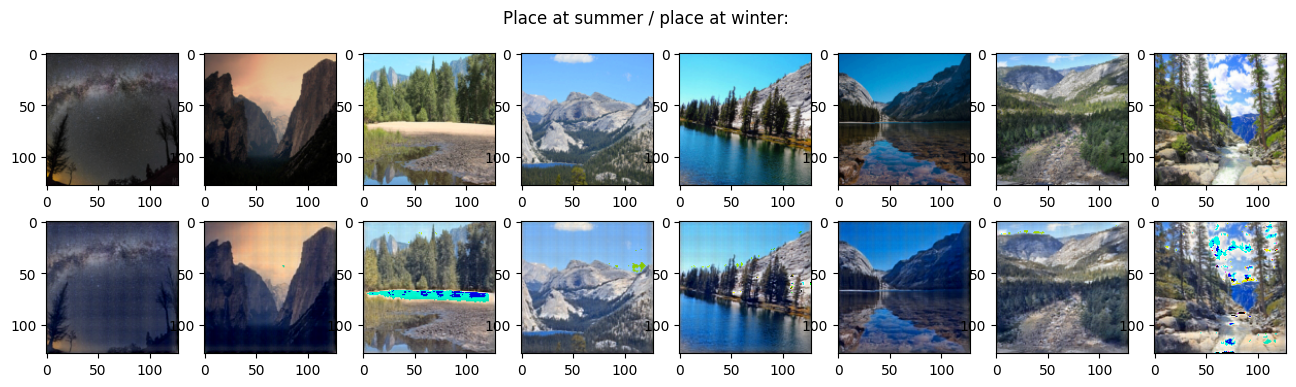

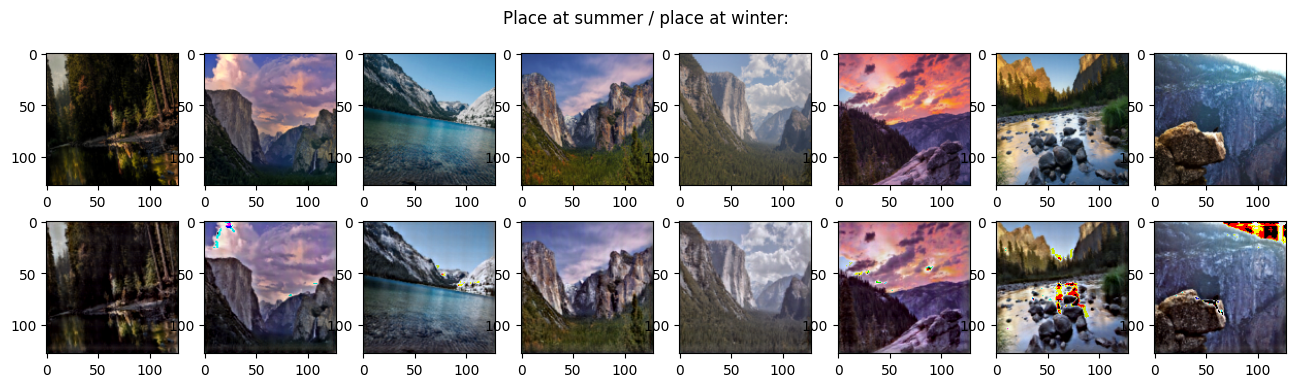

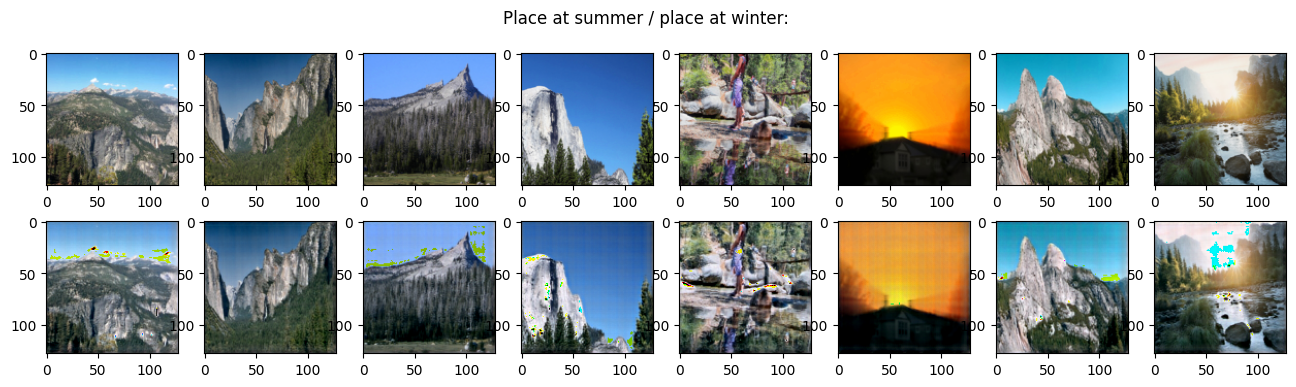

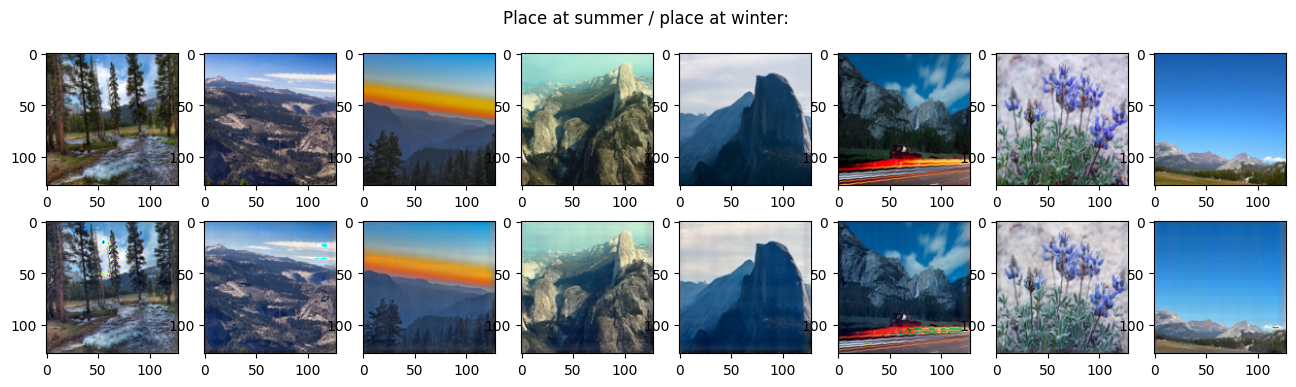

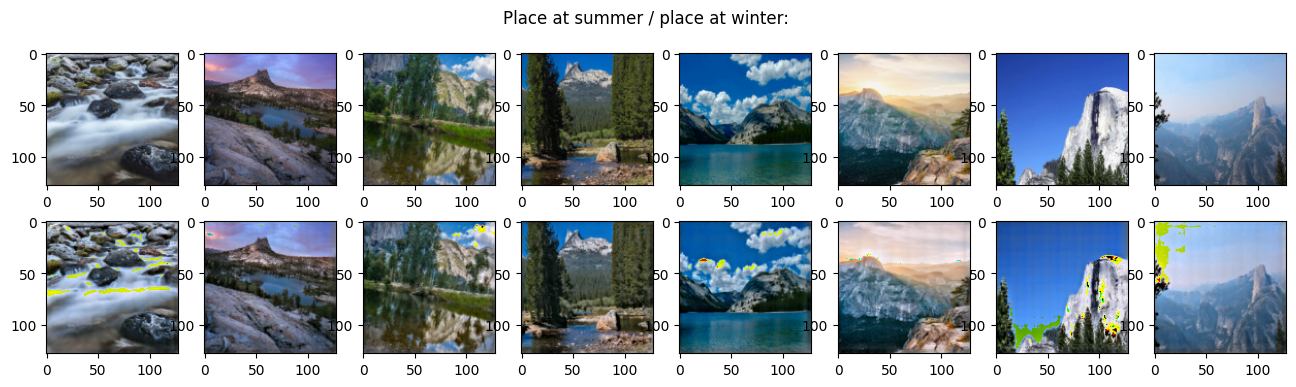

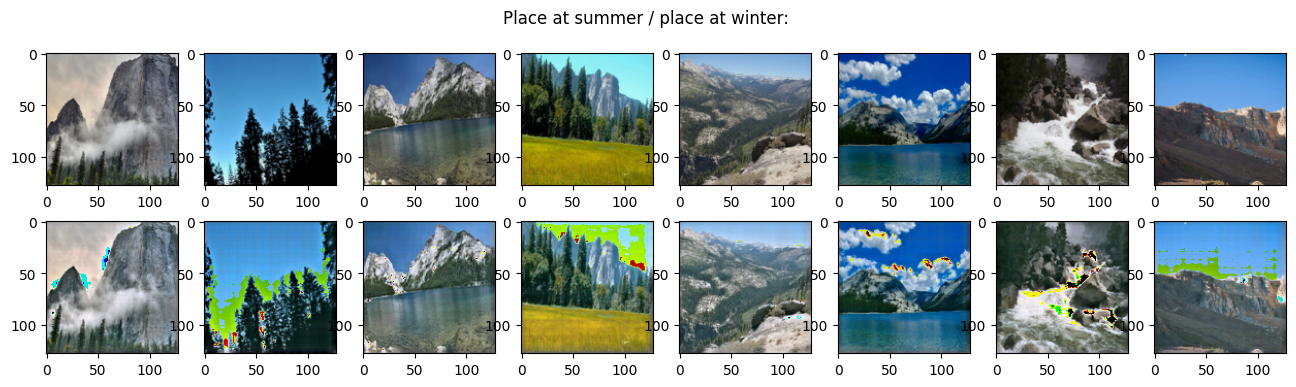

In [12]:
# Main training loop
epochs = 30
for epoch in range(epochs):
    d_iter = iter(dataloader)

    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        imgs = next(d_iter)[0]
        X = dataloader.dataset.take(imgs, A=True)
        Y = dataloader.dataset.take(imgs, A=False)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"W Dist={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

    Val_iter = iter(dataVal)
    X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
    X_test.requires_grad_(True)
    Y_generated = trainer.generate(X_test).detach().cpu()
    
    cols = 8
    
    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')
    
    for i in range(cols):
        X_img = np.asarray(dataVal.dataset.to_image(X_test.detach().cpu())[i], dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)
    
        Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)
    
    #plt.tight_layout()
    fig.show()

/tmp/ipykernel_343059/3445529341.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


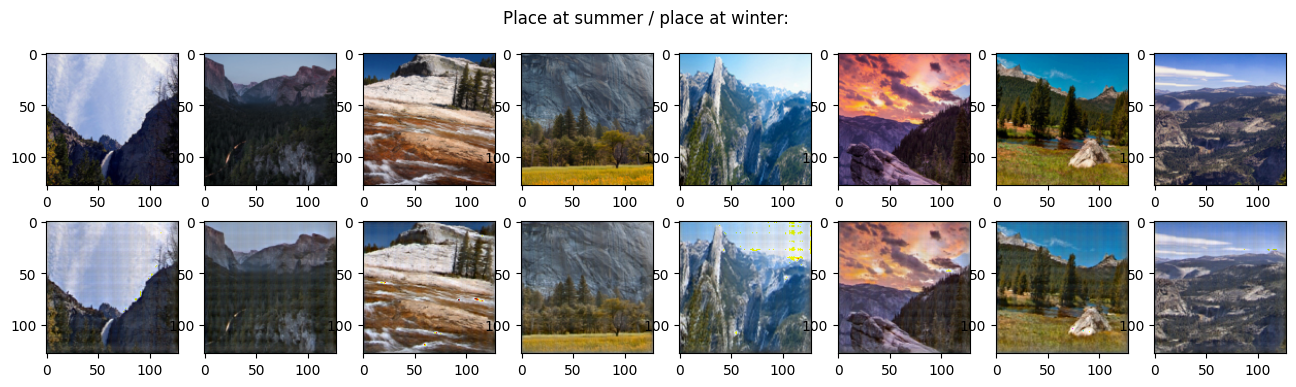

In [15]:
Val_iter = iter(dataVal)
X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
X_test.requires_grad_(True)
Y_generated = trainer.generate(X_test).detach().cpu()

cols = 8

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

for i in range(cols):
    X_img = np.asarray(dataVal.dataset.to_image(X_test.detach().cpu())[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()